In [21]:
STR_PIECES = [
"""
W#
##
""",
"""
W##
# #
""",
"""
 W
###
 #
""",
"""
#W#
##
""",
"""
 #
 #
W#
#
""",
"""
#W###
""",
"""
  #
#W##
""",
"""
#
W##
#
""",
"""
 W#
##
#
""",
"""
##
 W
 ##
""",
"""
  #
  #
##W
""",
"""
 #
 W#
##
""",
"""
   #
##W#
"""
]

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from PIL import Image
from scipy.signal import convolve
from IPython.display import display
from enum import Enum
from dataclasses import dataclass
from functools import cached_property


SCALE = 50

class Piece:
    
    E = 0
    W = 1
    B = 2
    P = 3
    _CHAR_TYPE_MAP = " WB#"
    CHAR_TO_TYPE = {c:i for i,c in enumerate(_CHAR_TYPE_MAP)}
    
    def __init__(self, arr:np.array, pin:(int, int)):
        self.arr = arr
        self.pin = pin
        
    @classmethod
    def from_str(cls, piece_str:str) -> "Piece":
        arr, pin = Piece.process_piece(piece_str)
        return cls(arr, pin)

    @staticmethod
    def process_piece(piece_str: str) -> (np.array, (int, int)):
        lines = piece_str.strip("\n").split("\n")
        nrows, ncols = len(lines), max(map(len, lines))

        piece_arr = np.zeros((nrows, ncols), dtype=np.uint8)
        for y,x in product(range(nrows), range(ncols)):
            line = lines[y]
            piece_arr[y,:len(line)] = [Piece.CHAR_TO_TYPE[c] for c in line]

        _py, _px = np.where(piece_arr == Piece.W)
        assert len(_py) == 1 and len(_px) == 1
        py, px = _py[0], _px[0]
        parity = (py + px) & 1

        for y,x in product(range(nrows), range(ncols)):
            c = piece_arr[y,x]
            piece_arr[y,x] = (Piece.W if (y+x)&1 == parity else Piece.B) if c == Piece.P else c
        piece_arr[py, px] = Piece.P
        return piece_arr, (py, px)

    def plot_piece(self) -> Image:
        y,x = self.arr.shape
        img = np.zeros((y,x, 4), dtype=np.uint8)
        img[self.arr == Piece.W] = img[self.arr == Piece.P] = [242, 163, 126,255]
        img[self.arr == Piece.B] = [92, 30, 1,255]
        img[self.arr == Piece.E] = [0,0,0,0]
        img = img.repeat(SCALE, axis=0).repeat(SCALE, axis=1)
        
        py,px = self.pin
        mid_y, mid_x = py * SCALE + SCALE//2, px * SCALE + SCALE//2
        pin_sz = SCALE // 4
        img[
            mid_y - pin_sz : mid_y + pin_sz, 
            mid_x - pin_sz : mid_x + pin_sz] = [255,0,0,255]
        return Image.fromarray(img)
    
    @staticmethod
    def is_equivalent_piece(p1, p2) -> bool:
        p1s, p2s = p1.copy(), p2.copy()
        p1s[p1 == Piece.P] = p2s[p2 == Piece.P] = Piece.W
        return np.array_equal(p1s, p2s)
    
    def get_unique_orientations(self) -> "list[piece]":
        unique = []
        is_seen = lambda a: any(Piece.is_equivalent_piece(a, u) for u in unique)
        def get_pin(a):
            py, px = np.where(a == Piece.P)
            return (py[0], px[0])
        
        for k in range(4):
            a = np.rot90(self.arr, k)
            if not is_seen(a): unique.append(a)
            a = np.fliplr(a)
            if not is_seen(a): unique.append(a)
        return [Piece(u, get_pin(u)) for u in unique]
    
class Board:
    
    SHAPE = (8,8)
    
    def __init__(self, arr, pieces):
        self.arr = arr
        self.pieces = pieces
        
    @classmethod
    def empty(cls):
        return cls(np.zeros(Board.SHAPE, dtype=np.uint8), [])
        
    @staticmethod
    def is_white(loc: (int, int)) -> bool:
        return sum(loc) & 1 == 0
    
    def place_piece(self, piece:Piece, loc:(int, int)) -> "None | Board":
        if not Board.is_white(loc): return None
        py, px = piece.pin
        ly, lx = loc
        new_arr = self.arr.copy()
        piece_id = len(self.pieces) + 1
        for y,x in product(*map(range, piece.arr.shape)):
            c = piece.arr[y,x]
            if c == Piece.E: continue
            cy,cx = y-py+ly, x-px+lx
            if cy < 0 or cy >= Board.SHAPE[0] or cx < 0 or cx >= Board.SHAPE[1]: return None
            if new_arr[cy,cx] != Piece.E: return None
            new_arr[cy,cx] = piece_id
        return Board(new_arr, self.pieces + [(piece, loc)])
    
    def plot_board(self) -> Image:
        iy,ix = Board.SHAPE[0]*SCALE, Board.SHAPE[1]*SCALE
        img = np.zeros((iy,ix, 4), dtype=np.uint8)
        for p,(ly,lx) in self.pieces:
            sy,sx = p.arr.shape
            py,px = p.pin
            img[SCALE*(ly-py):SCALE*(ly-py+sy),
                SCALE*(lx-px):SCALE*(lx-px+sx)] += np.array(p.plot_piece())
        img = (img.astype(np.float32)*0.5).astype(np.uint8)
        
        line_thickness = SCALE//16
        s1 = (SCALE+1)//line_thickness
        s2 = line_thickness
        padsz = SCALE//2
        bordersz = line_thickness*2
        linecol = [3, 252, 204, 255]
        
        piecemap = self.arr.repeat(s1, axis=0).repeat(s1, axis=1)
        hx = np.array ([[1,0,-1],[2,0,-2],[1,0,-1]])
        hy = np.array ([[1,2,1],[0,0,0],[-1,-2,-1]])
        Gx = piecemap.copy()
        Gx = convolve(piecemap, hx)
        Gy = convolve(piecemap, hy)
        G = np.sqrt(Gx*Gx+Gy*Gy)
        G = G.astype(np.uint8).repeat(s2, axis=0).repeat(s2, axis=1)
        dy,dx = G.shape[0] - iy, G.shape[1] - ix
        ey,ex = dy//2, dx//2
        ry,rx = dy-ey, dx-ex
        G = G[ey:-ry,ex:-rx]
        img[G > 0] = linecol

        nimg = np.zeros((img.shape[0] + bordersz*2, img.shape[1] + bordersz*2, 4), dtype=np.uint8)
        nimg[:,:] = linecol
        nimg[bordersz:-bordersz, bordersz:-bordersz,] = img
        img = nimg
        img = np.pad(img, ((padsz, padsz), (padsz, padsz), (0, 0)), mode='constant', constant_values=128) 
        img[:,:,-1] = 255

        return Image.fromarray(img)

In [25]:
pieces = [*map(Piece.from_str, STR_PIECES)]
assert sum((p.arr != 0).sum() for p in pieces) == 8*8
oriented_pieces = [p.get_unique_orientations() for p in pieces]

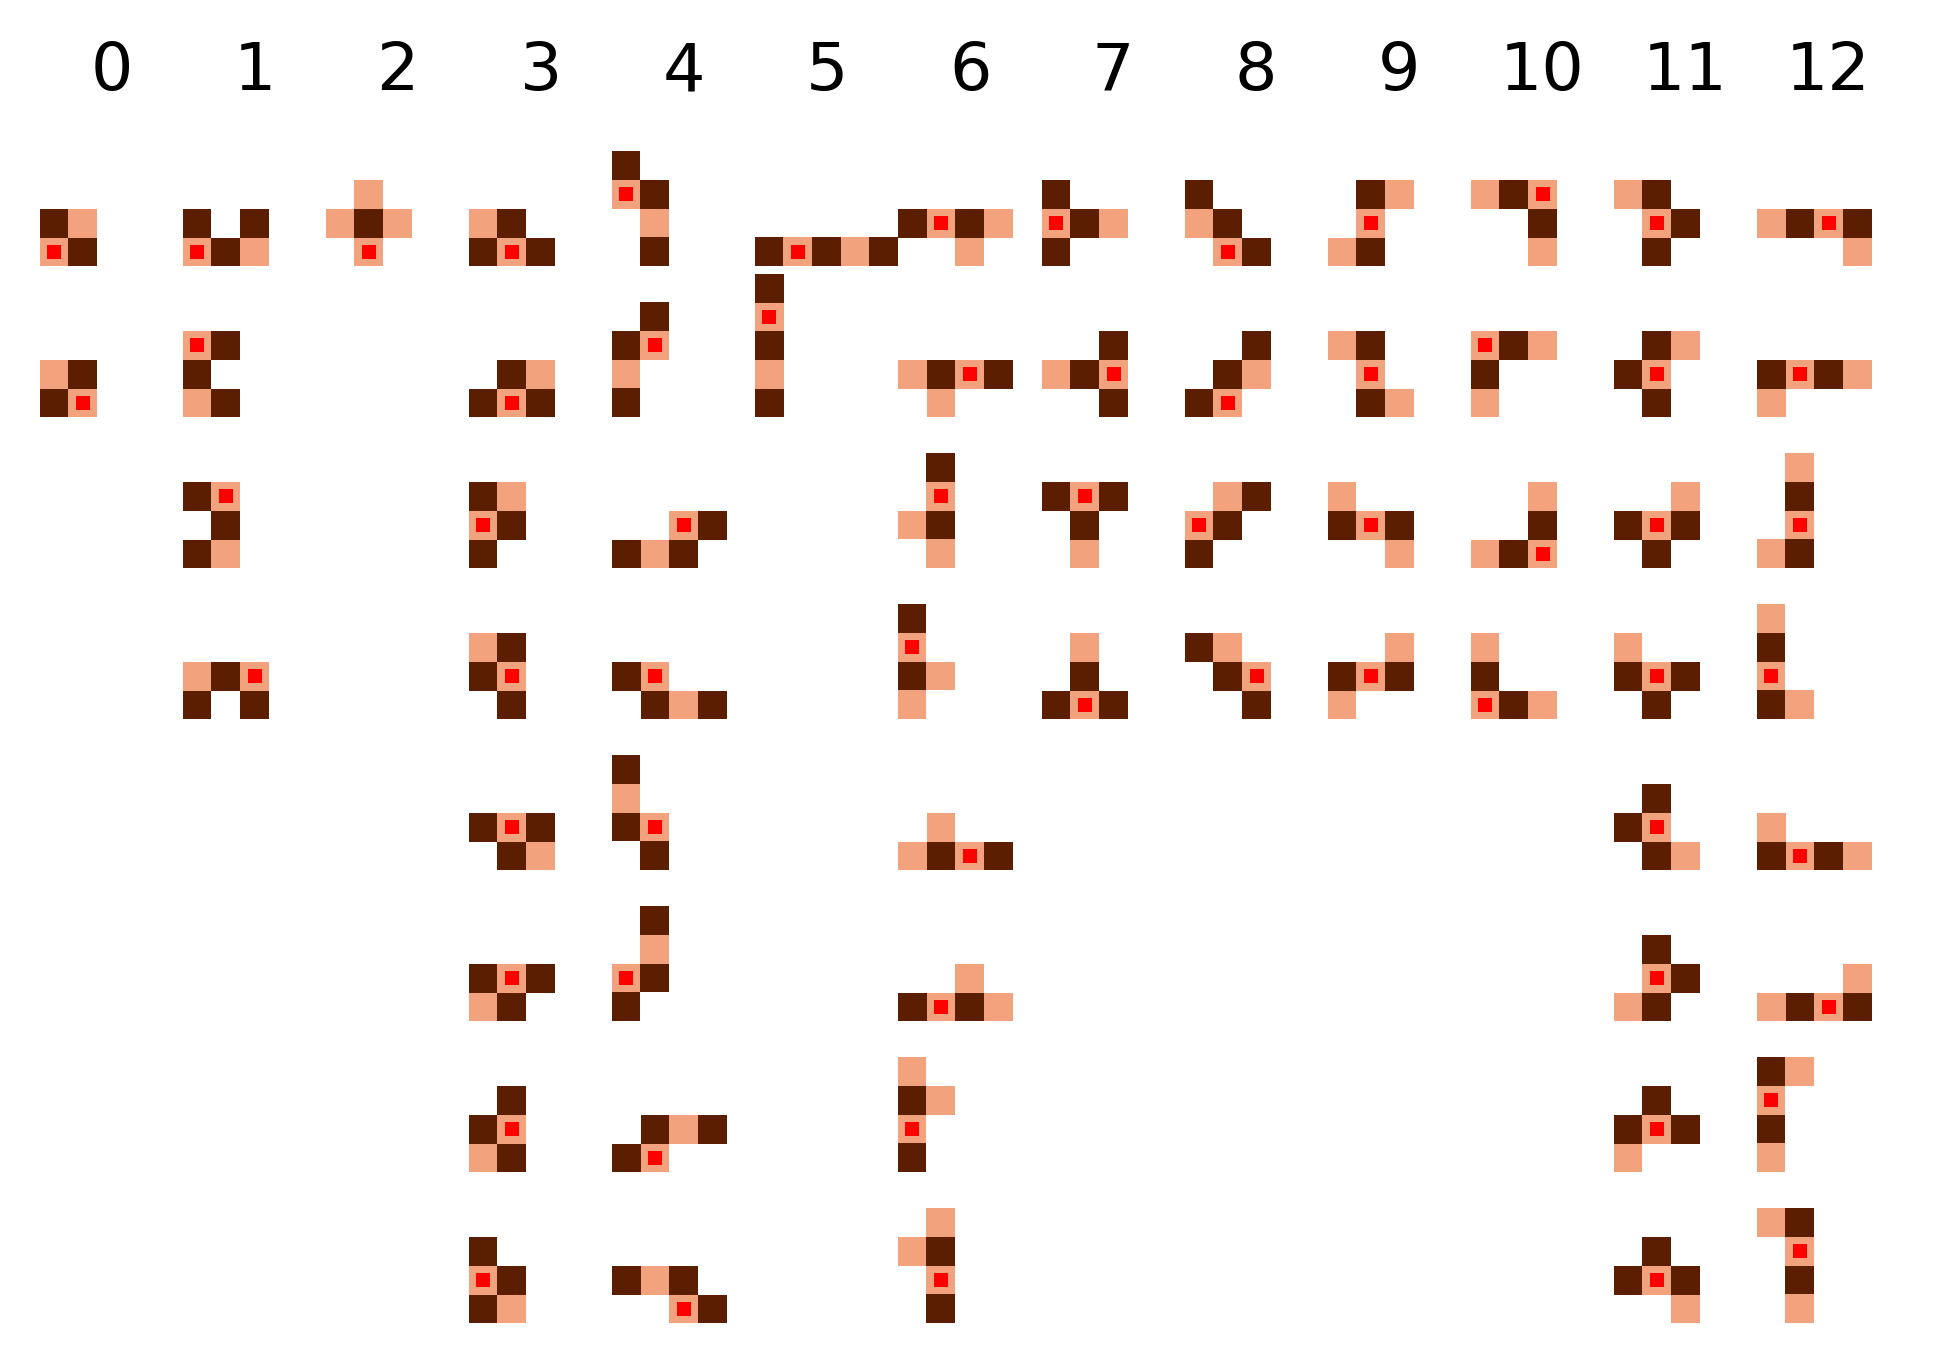

In [27]:
f, axarr = plt.subplots(max(map(len, oriented_pieces)), len(pieces))
f.set_dpi(400)
[a.axis("off") for axs in axarr for a in axs]
[a.set_xlim([0,5*SCALE]) for axs in axarr for a in axs]
[a.set_ylim([0,5*SCALE]) for axs in axarr for a in axs]
[a.set_xticklabels([]) for axs in axarr for a in axs]
[a.set_yticklabels([]) for axs in axarr for a in axs]
[a.imshow([[]]) for axs in axarr for a in axs]

plt.subplots_adjust(wspace=0, hspace=0)
for y,os in enumerate(oriented_pieces):
    for x,p in enumerate(os):
        if x == 0: axarr[x,y].set_title(f"{y}")
        axarr[x,y].imshow(np.array(p.plot_piece(), dtype=np.uint8), interpolation='nearest')

In [28]:
s = MixedIntegerLinearProgram(solver="Gurobi")

lpboard = np.array([[0 for x in range(Board.SHAPE[1])] for y in range(Board.SHAPE[0])], dtype=object)
bgens = s.new_variable(binary=True)
nbgens = 0
pos_vars = {}
empty = Board.empty()
for ip, ps in enumerate(oriented_pieces):
    cons = []
    for io, p in enumerate(ps):
        for loc in product(*map(range, Board.SHAPE)):
            
            placed = empty.place_piece(p, loc)
            if placed is None: continue
            
            b_pos = bgens[nbgens]
            pos_vars[nbgens] = (p, loc)
            nbgens += 1
            
            py,px = np.nonzero(placed.arr)
            for y,x in zip(py,px):
                lpboard[y,x] = lpboard[y,x] + b_pos
            cons.append(b_pos)

    s.add_constraint(sum(cons) == 1)

for b in np.ravel(lpboard):
    s.add_constraint(b == 1)

Solution #1


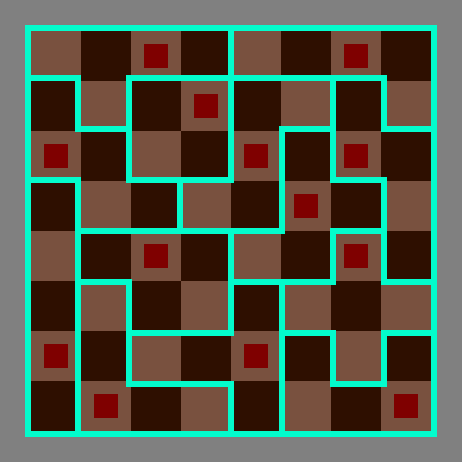


Solution #2


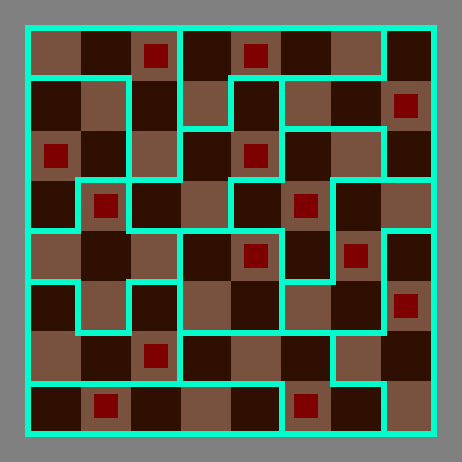


Solution #3


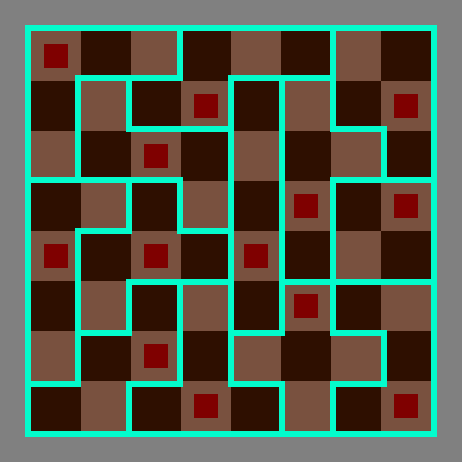


Solution #4


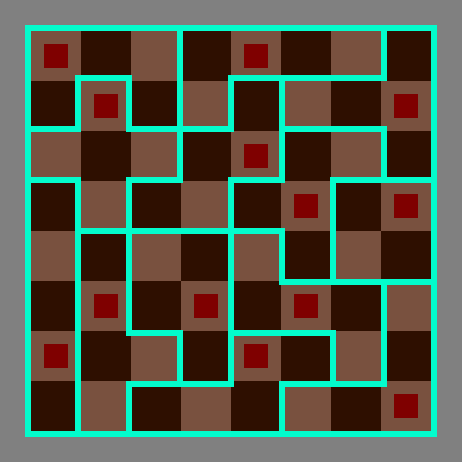


Solution #5


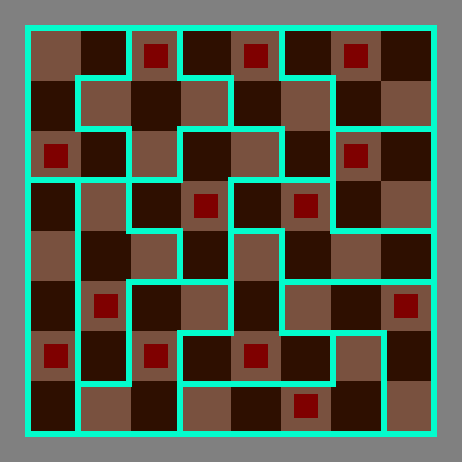


Solution #6


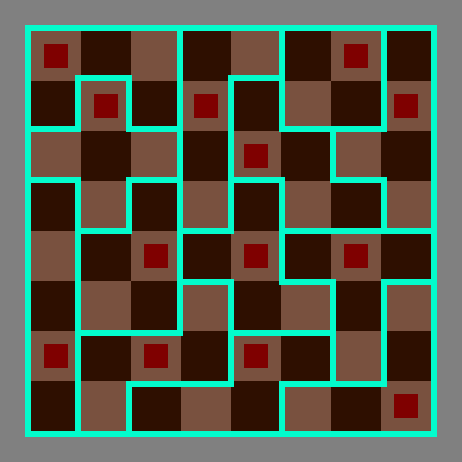


Solution #7


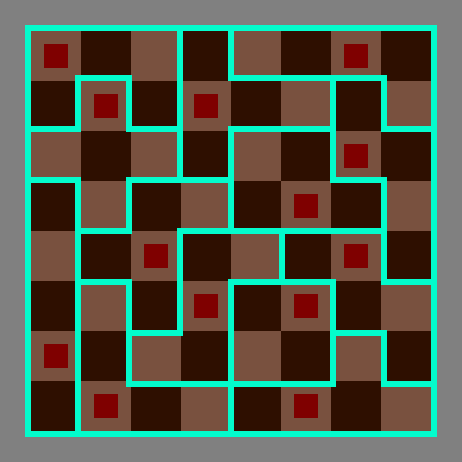


Solution #8


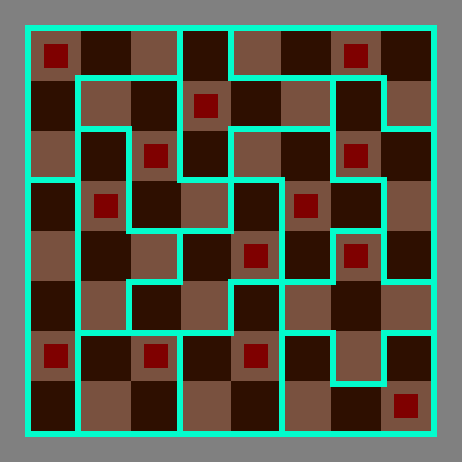


Solution #9


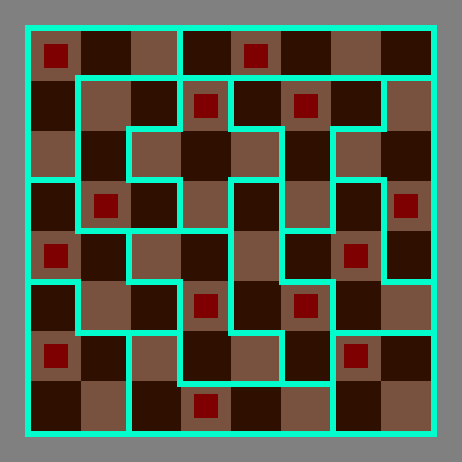


Solution #10


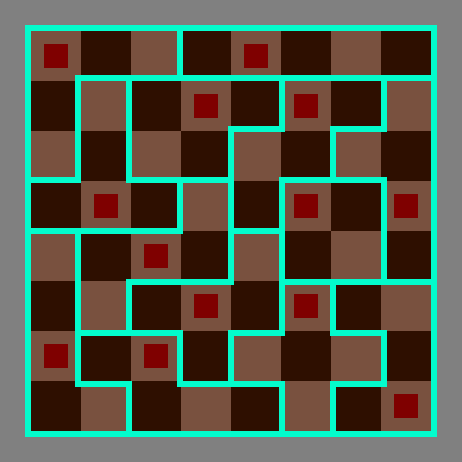


Solution #11


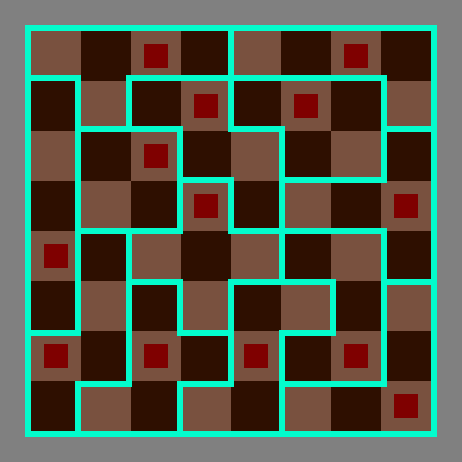


Solution #12


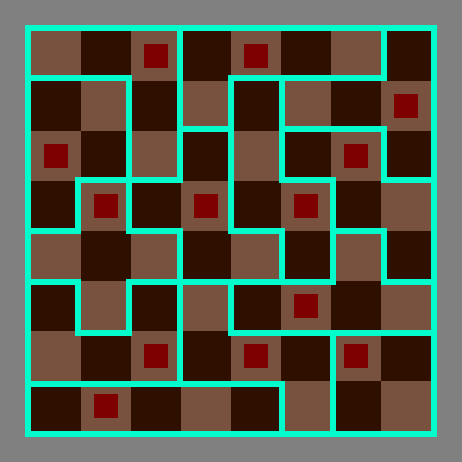


Solution #13


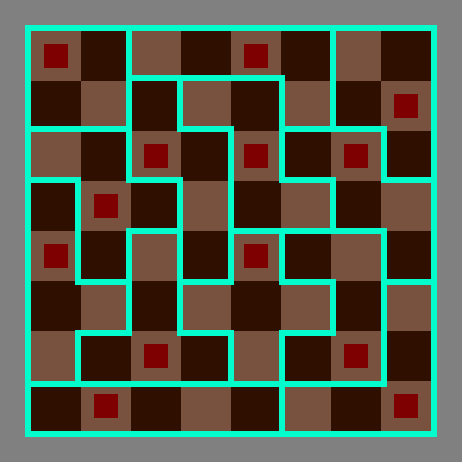


Solution #14


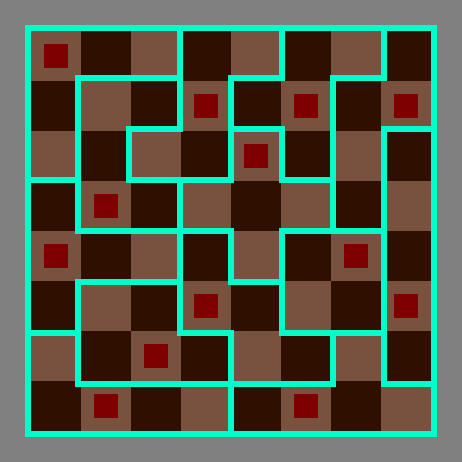


Solution #15


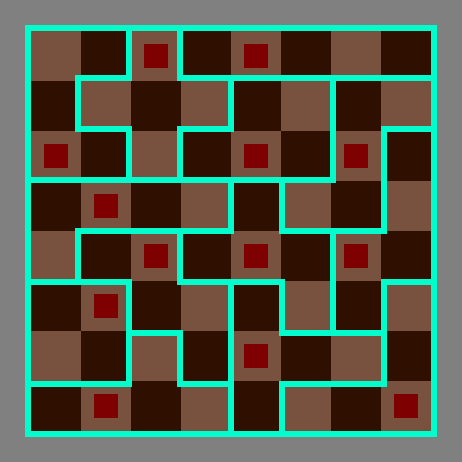


Solution #16


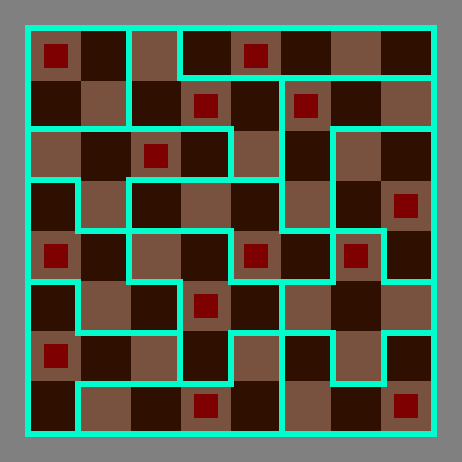


Solution #17


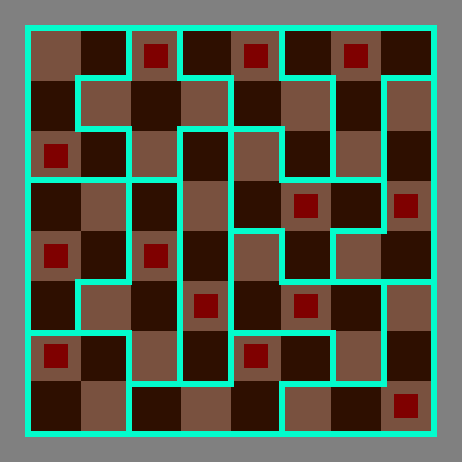


Solution #18


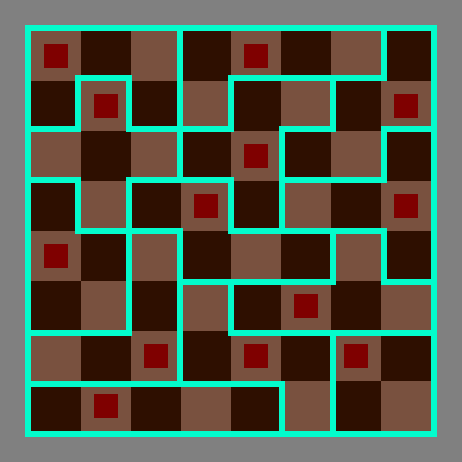


Solution #19


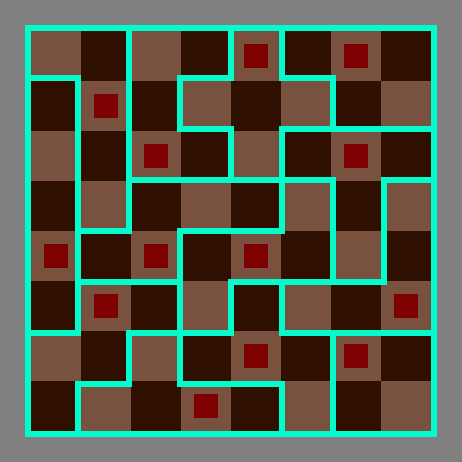


Solution #20


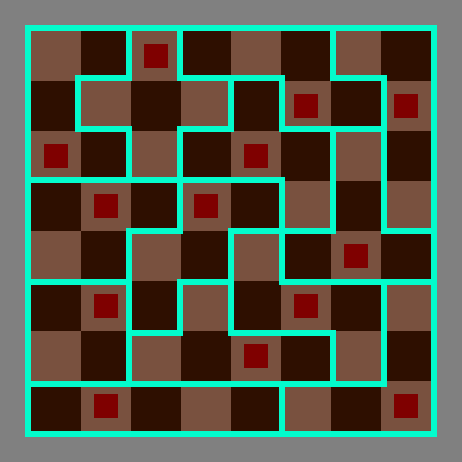


Solution #21


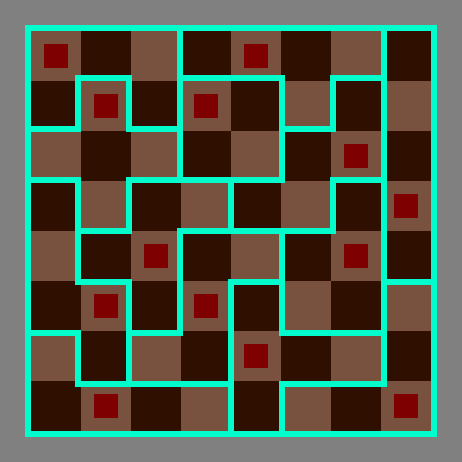


Solution #22


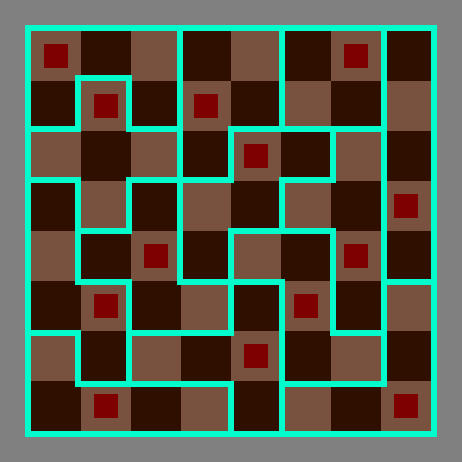


Solution #23


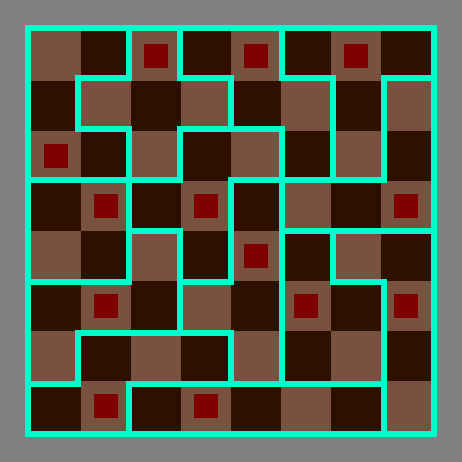


Solution #24


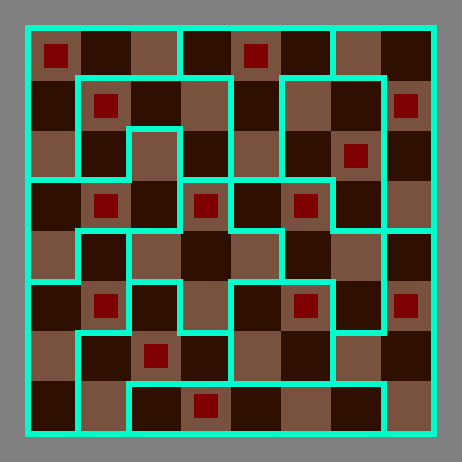


Solution #25


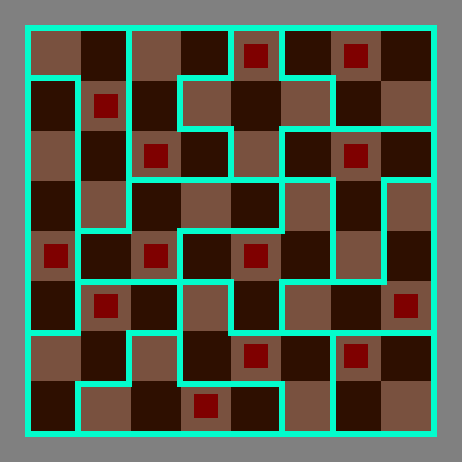


Solution #26


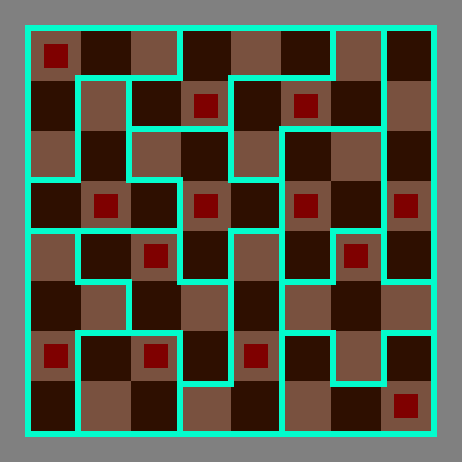


Solution #27


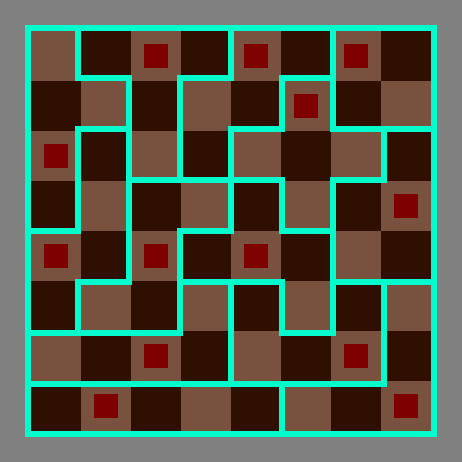


Solution #28


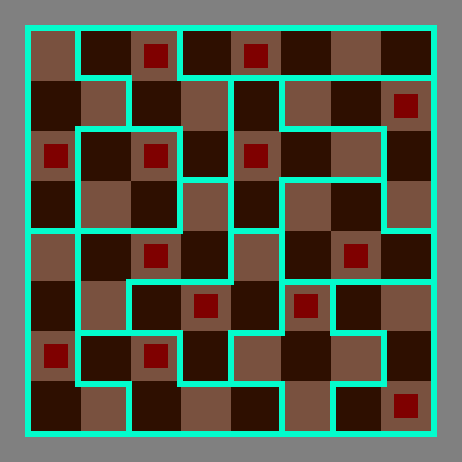


Solution #29


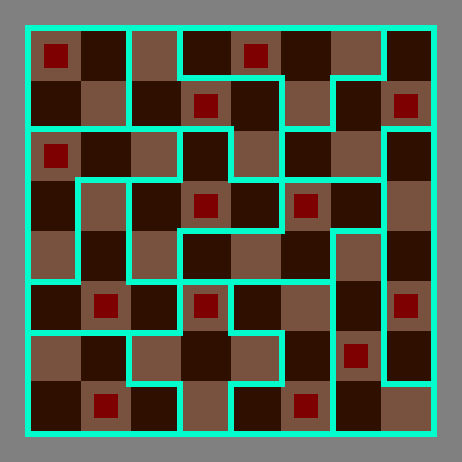


Solution #30


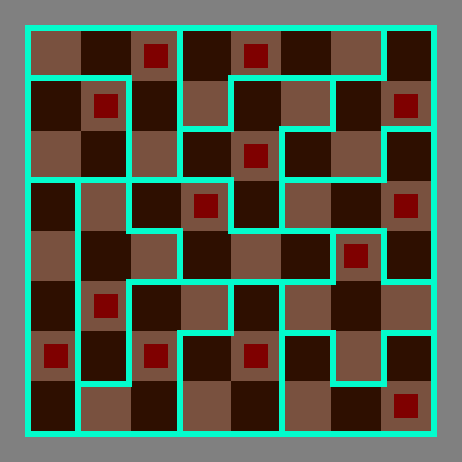


Solution #31


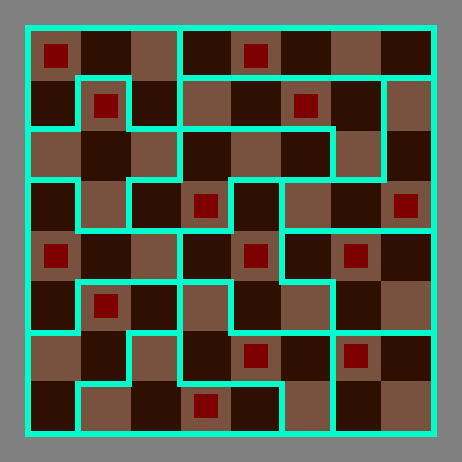


Solution #32


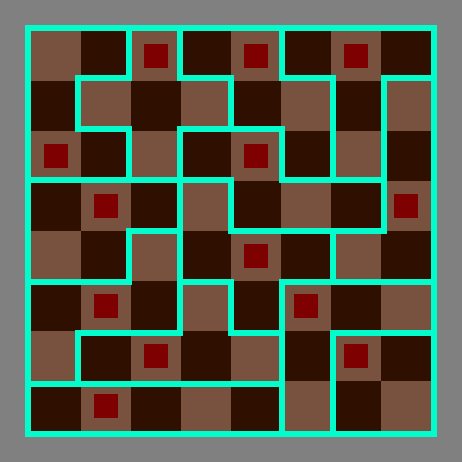


Solution #33


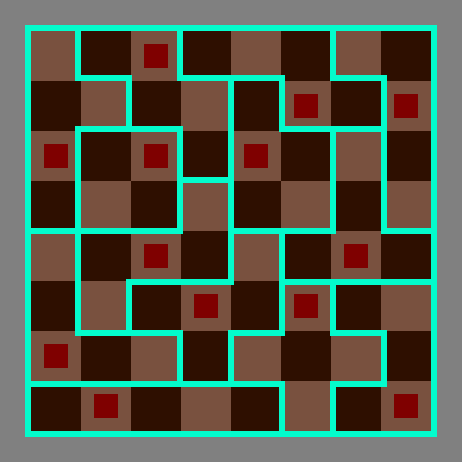


Solution #34


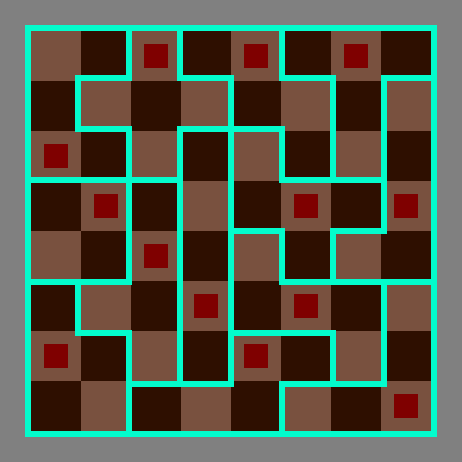


Solution #35


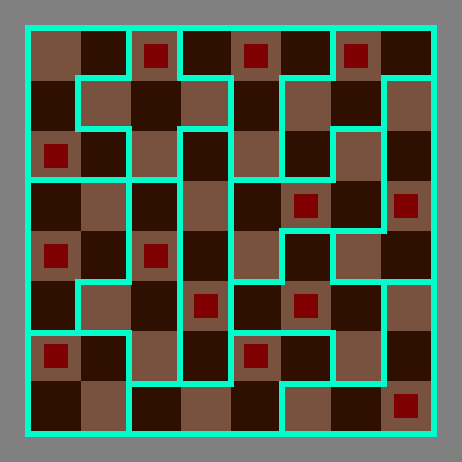


Solution #36


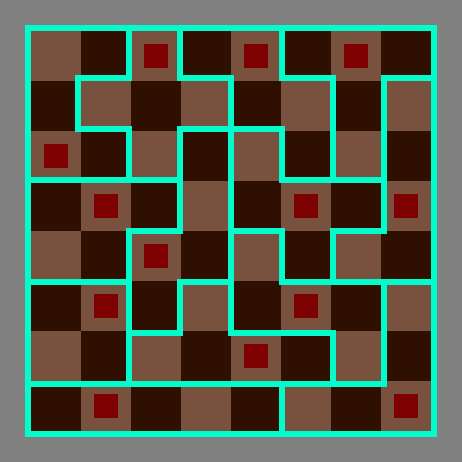


Solution #37


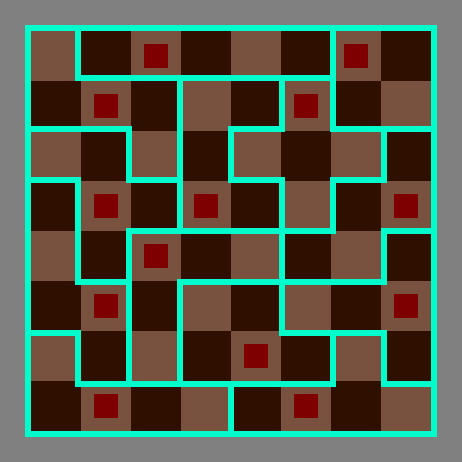


Solution #38


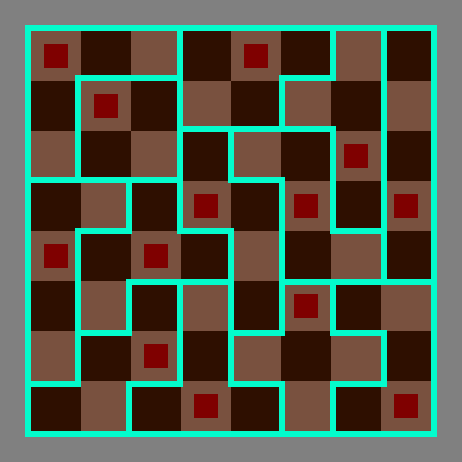


Solution #39


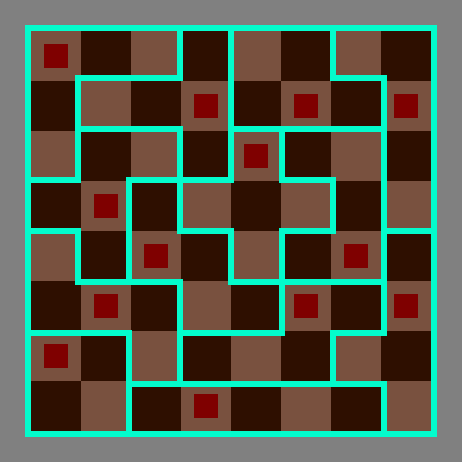


Solution #40


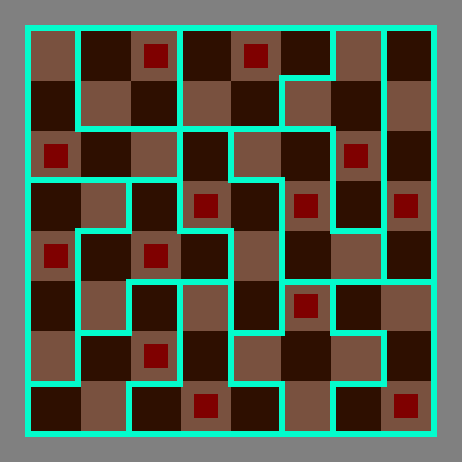


Solution #41


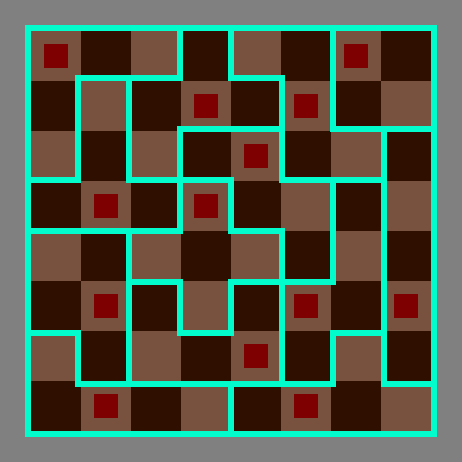


Solution #42


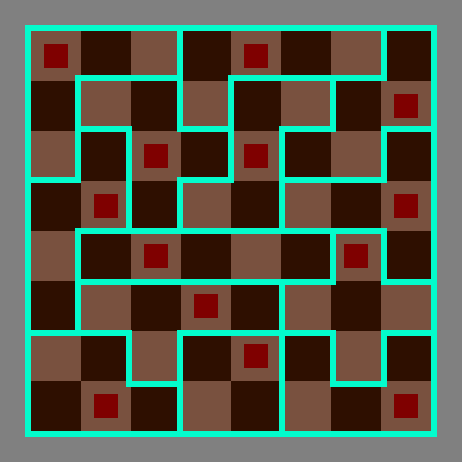


Solution #43


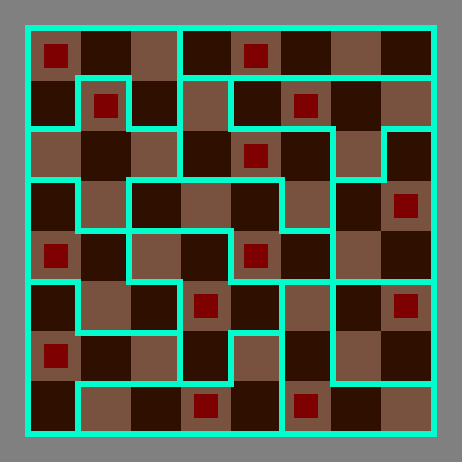


Solution #44


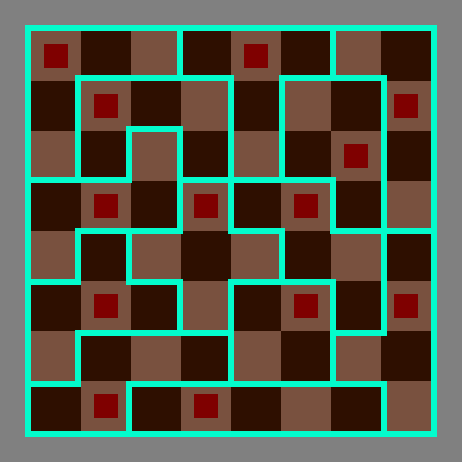


Solution #45


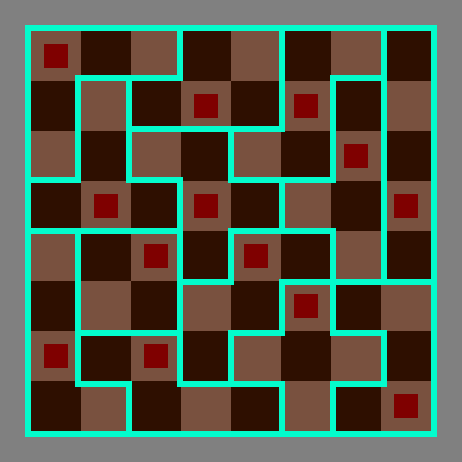


Solution #46


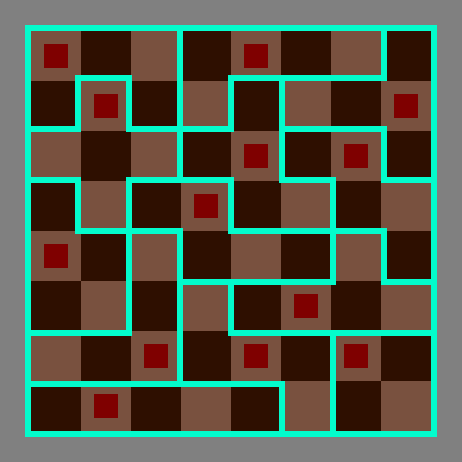


Solution #47


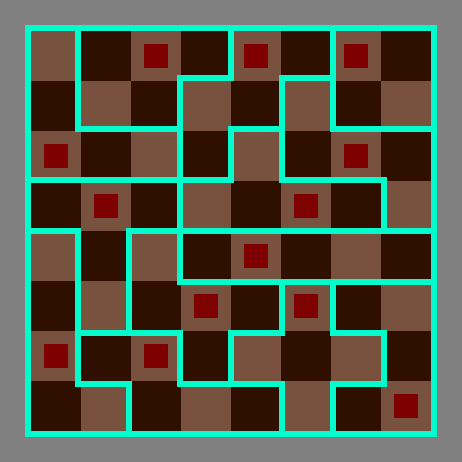


Solution #48


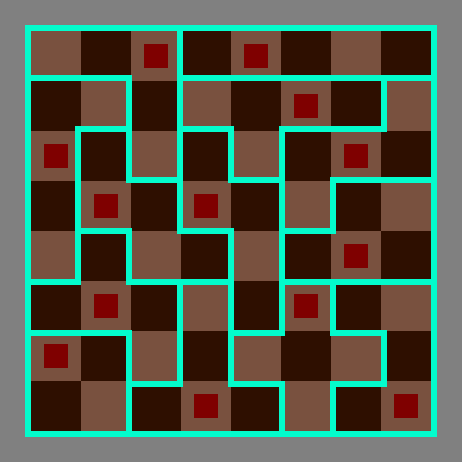


Solution #49


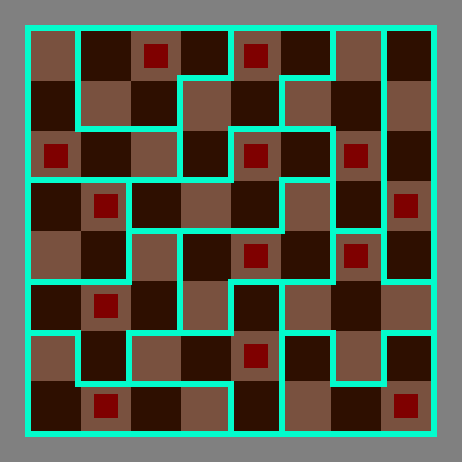


Solution #50


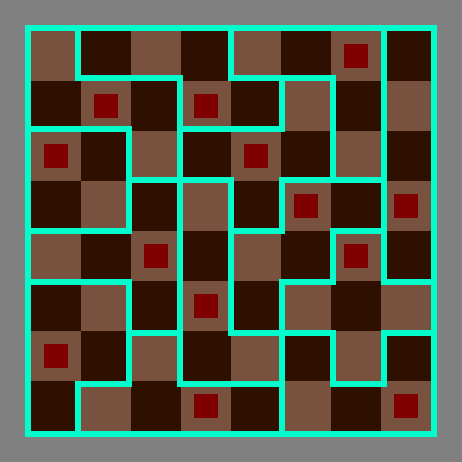


Solution #51


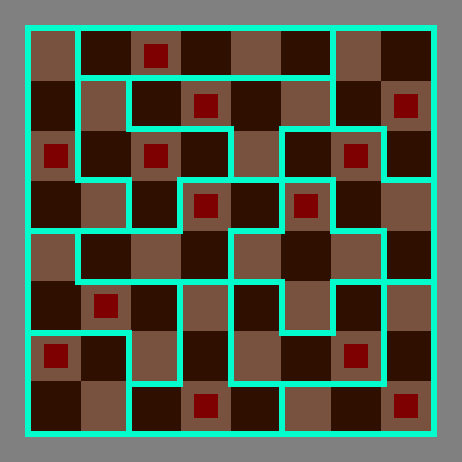


Solution #52


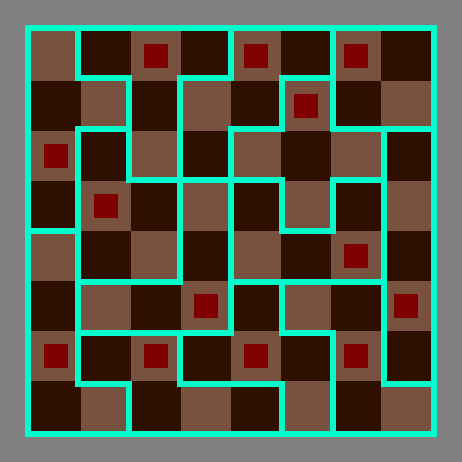


Solution #53


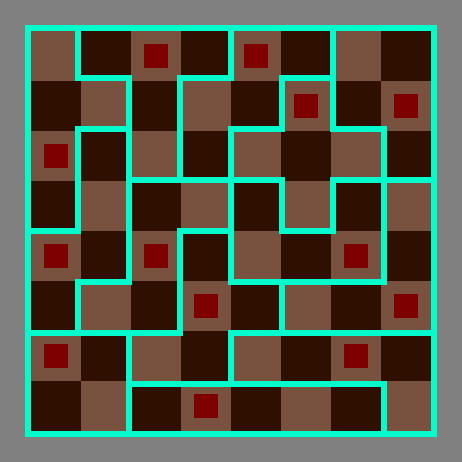


Solution #54


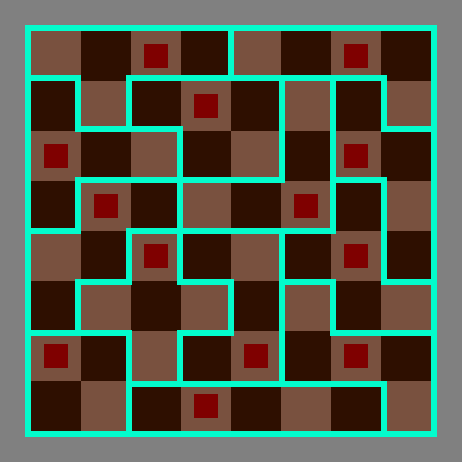


Solution #55


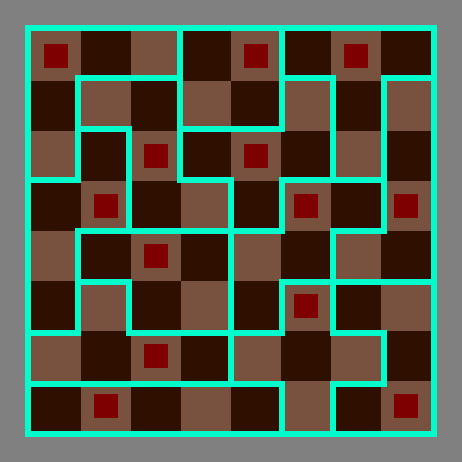


Solution #56


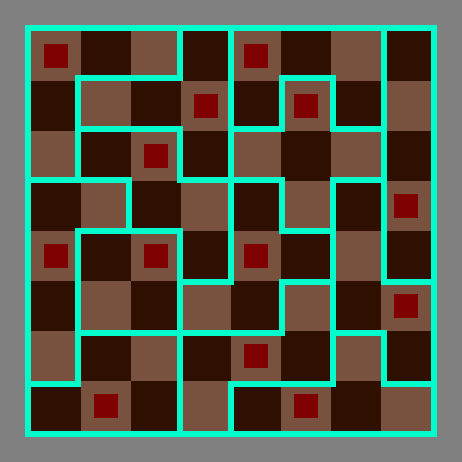


Solution #57


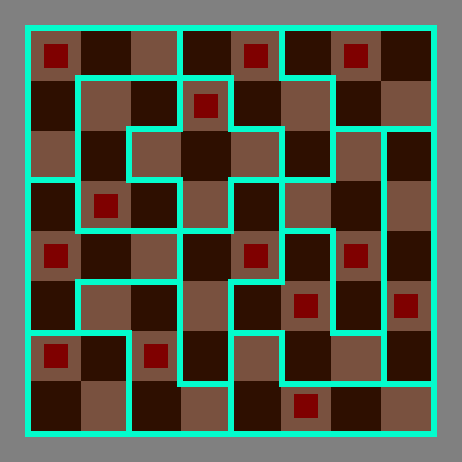


Solution #58


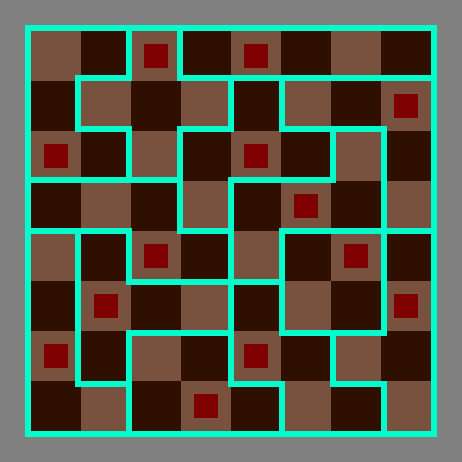


Solution #59


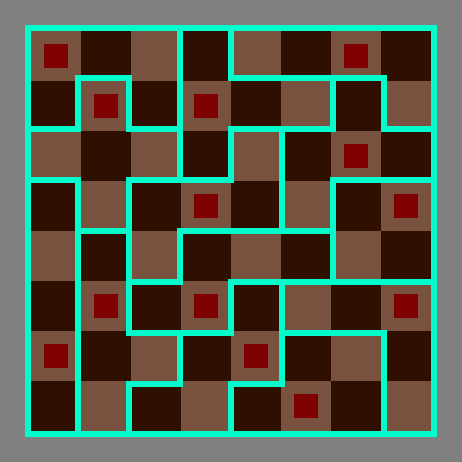


Solution #60


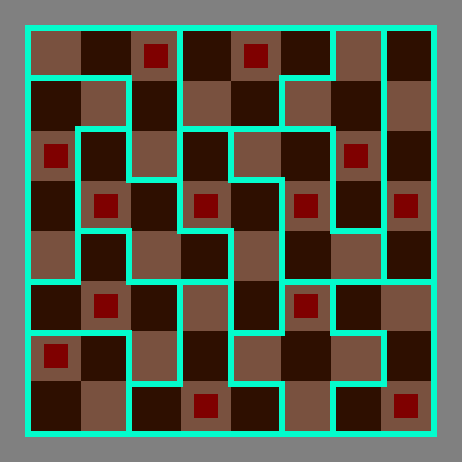


Solution #61


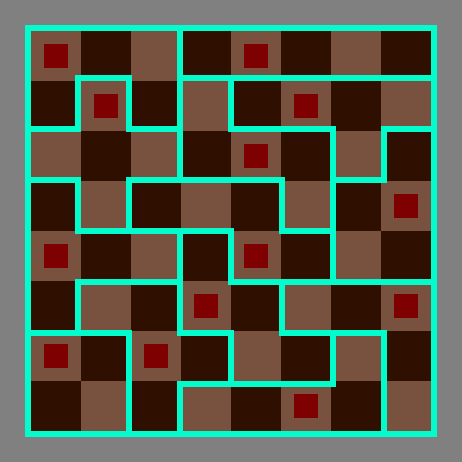


Solution #62


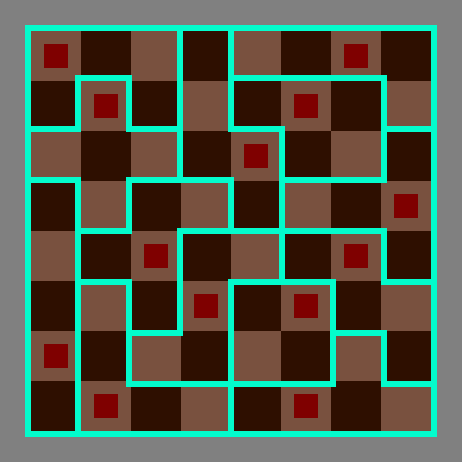


Solution #63


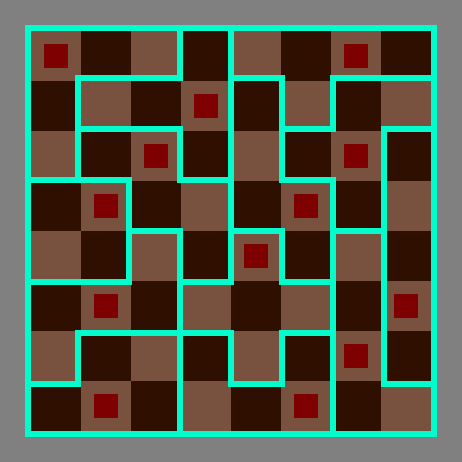


Solution #64


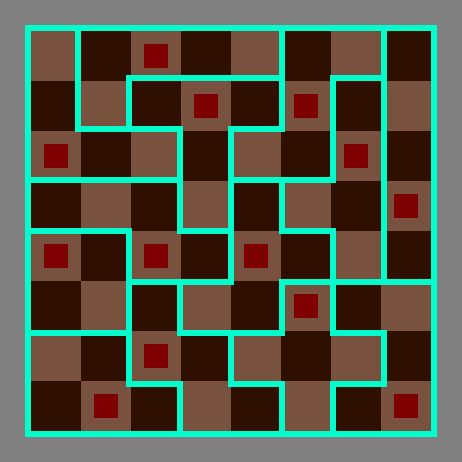


Solution #65


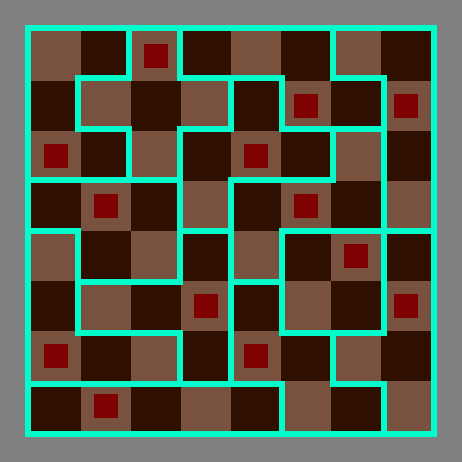


Solution #66


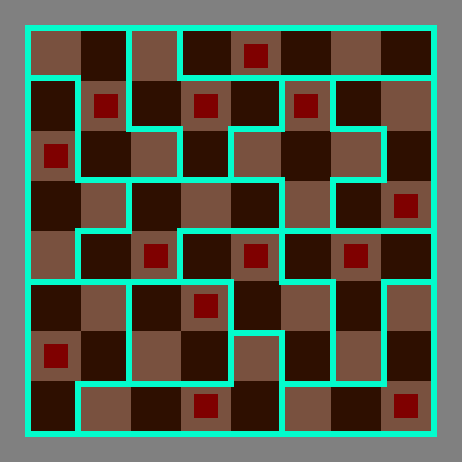


Solution #67


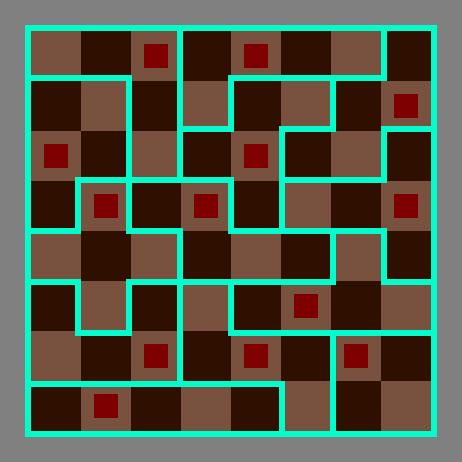


Solution #68


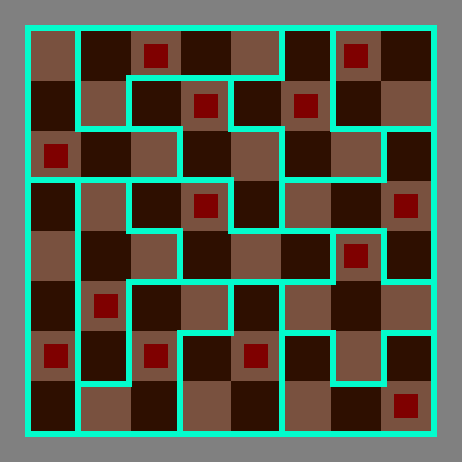


Solution #69


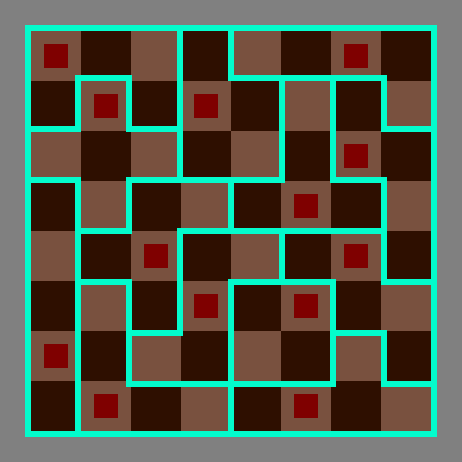


Solution #70


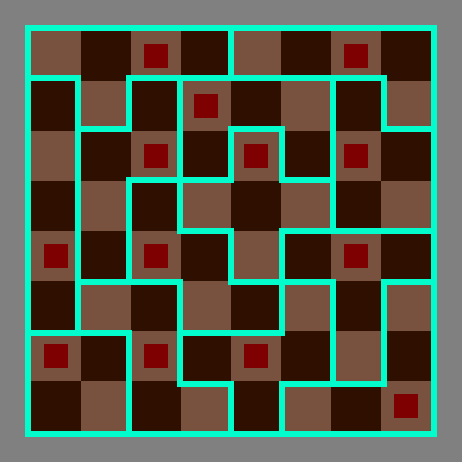


Solution #71


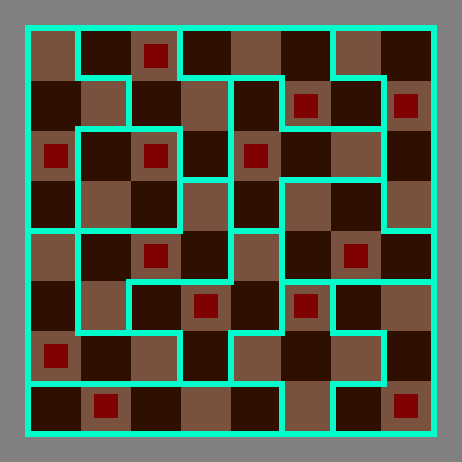


Solution #72


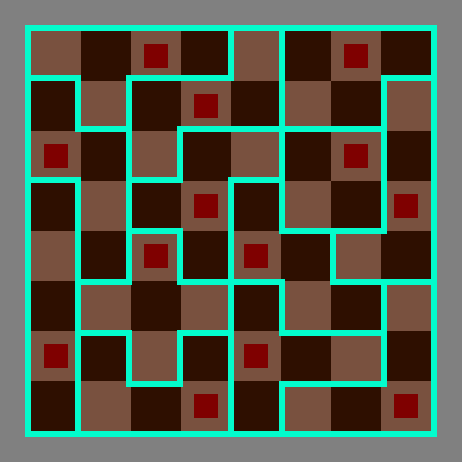


Solution #73


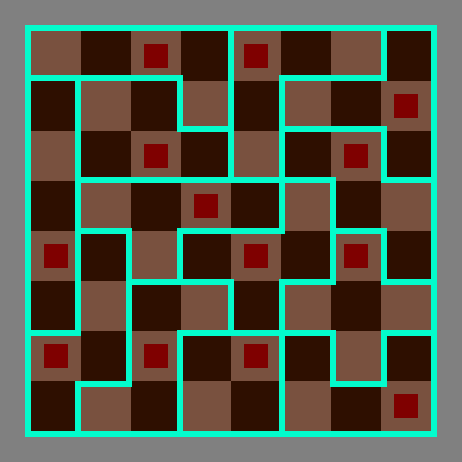


Solution #74


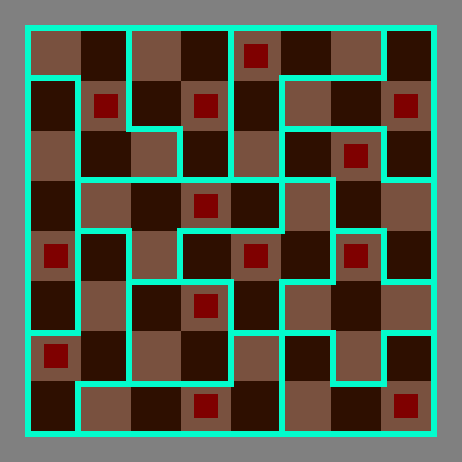


Solution #75


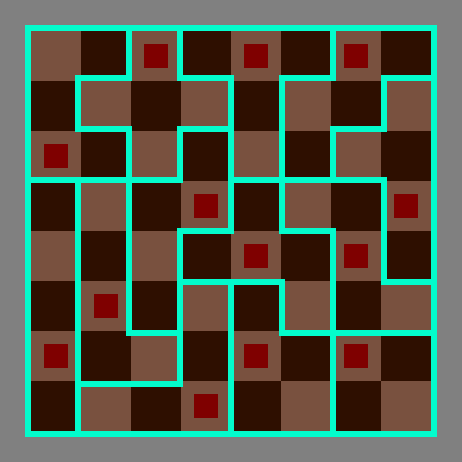


Solution #76


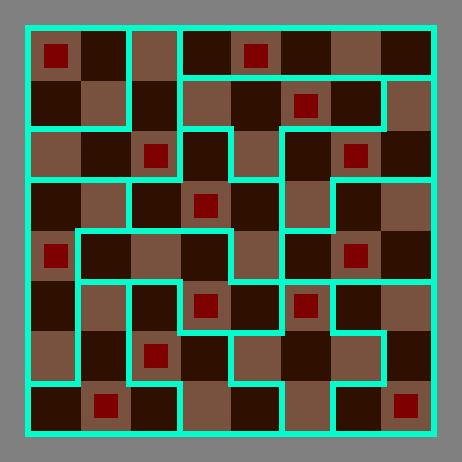


Solution #77


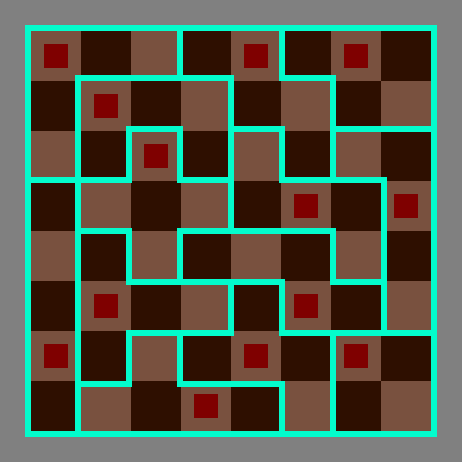


Solution #78


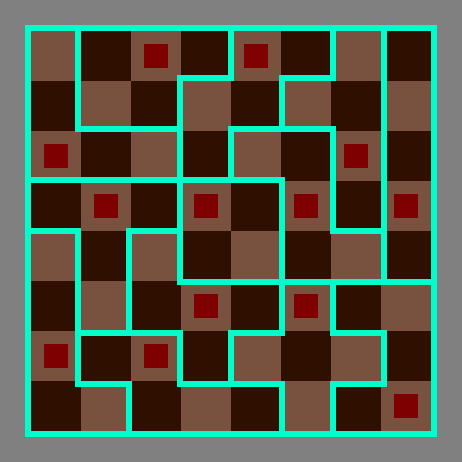


Solution #79


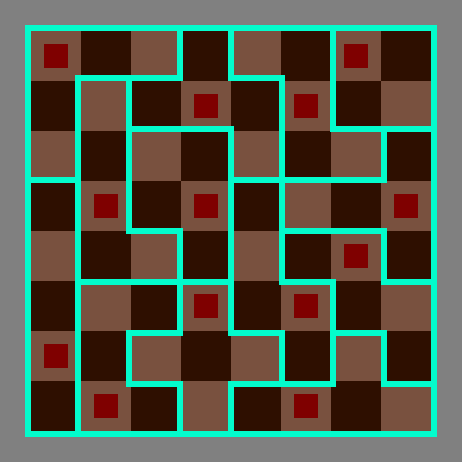


Solution #80


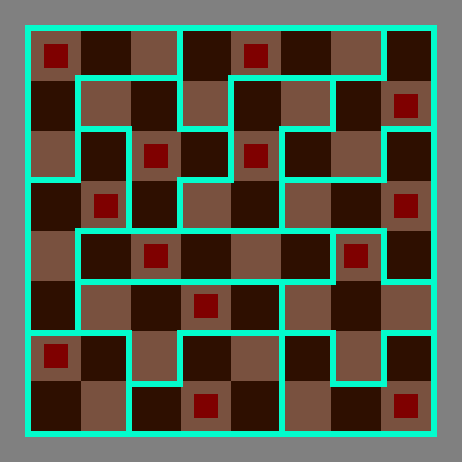


Solution #81


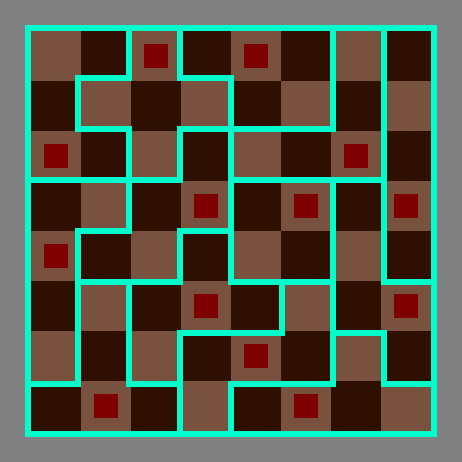


Solution #82


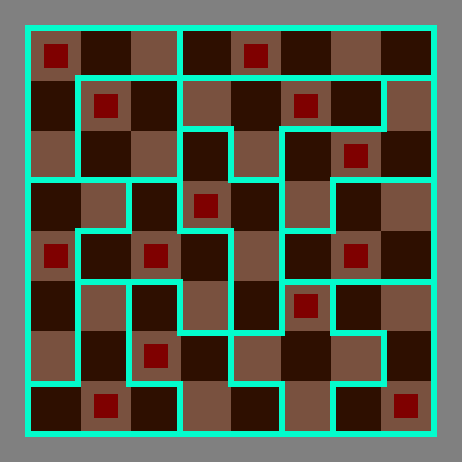


Solution #83


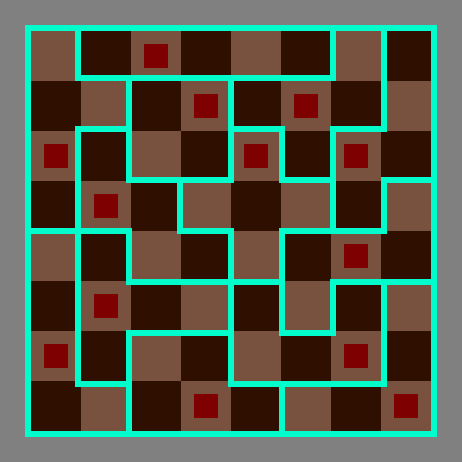


Solution #84


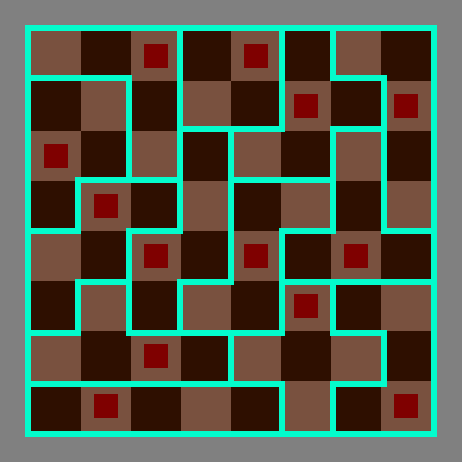


Solution #85


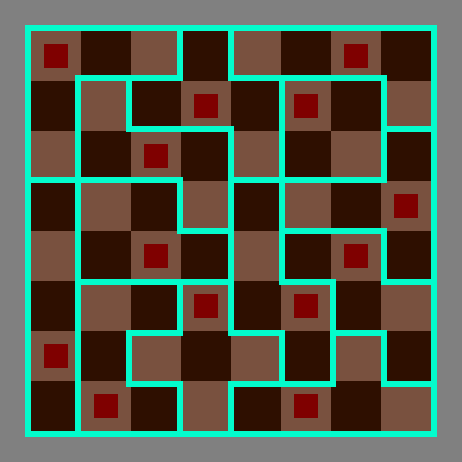


Solution #86


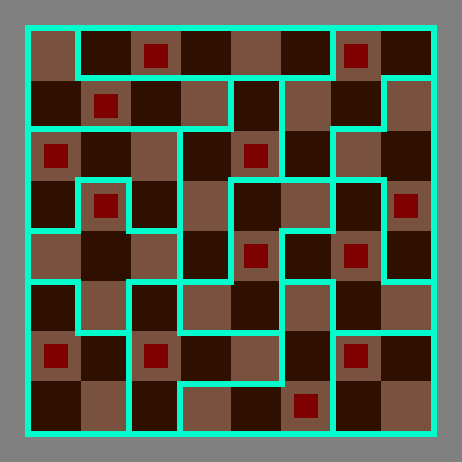


Solution #87


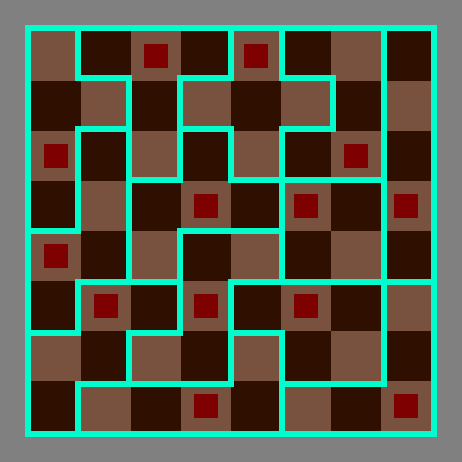


Solution #88


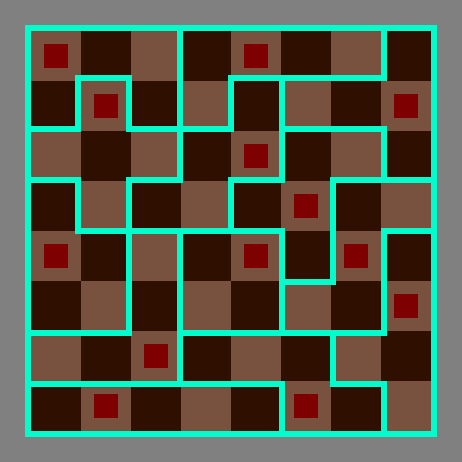


Solution #89


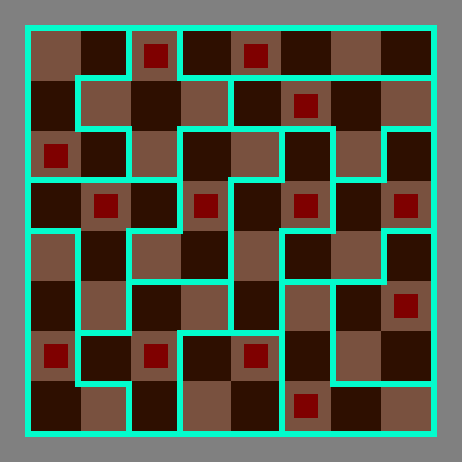


Solution #90


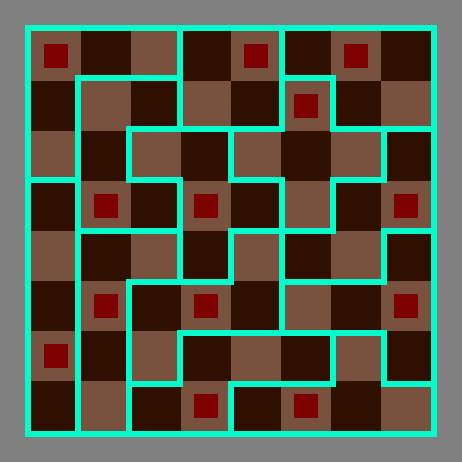


Solution #91


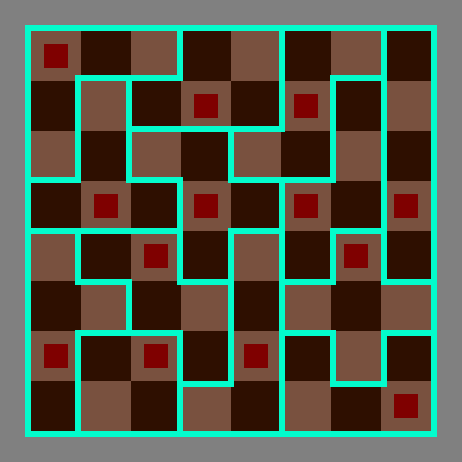


Solution #92


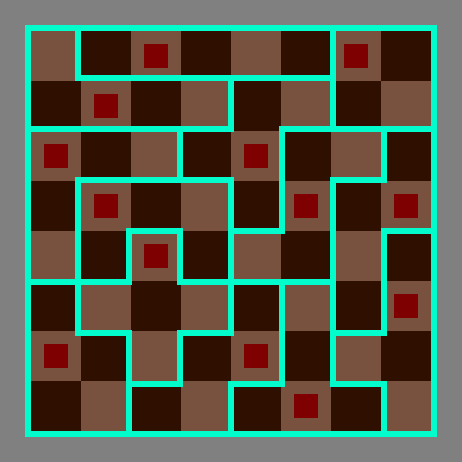


Solution #93


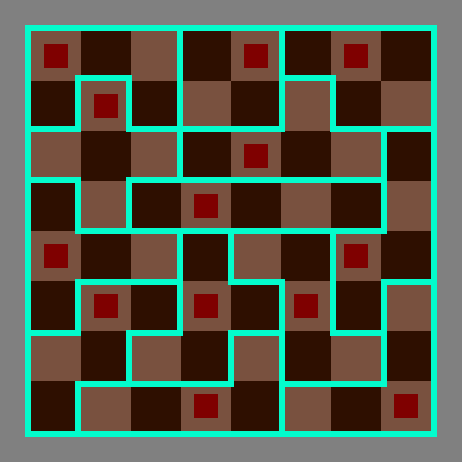


Solution #94


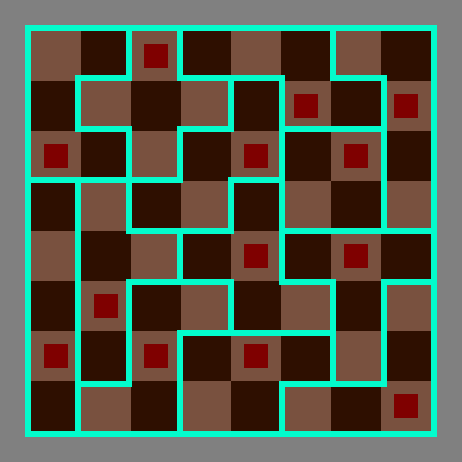


Solution #95


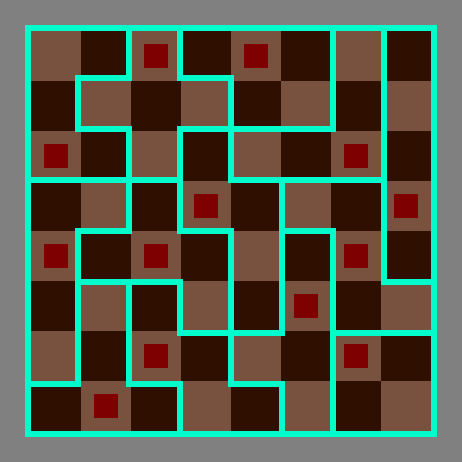


Solution #96


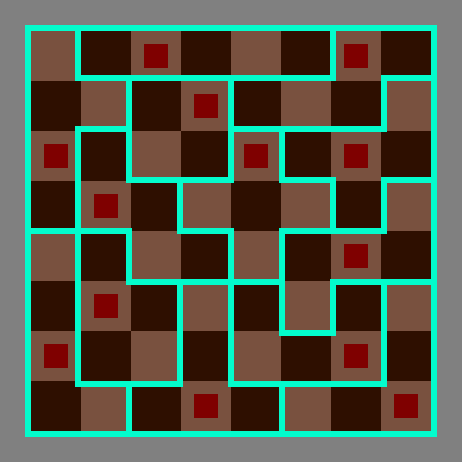


Solution #97


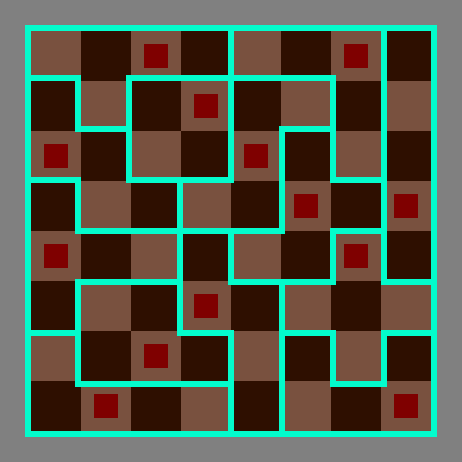


Solution #98


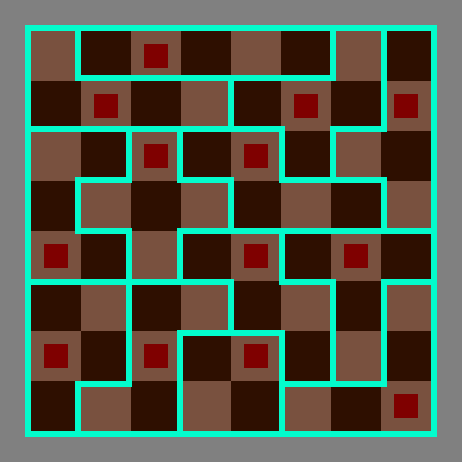


Solution #99


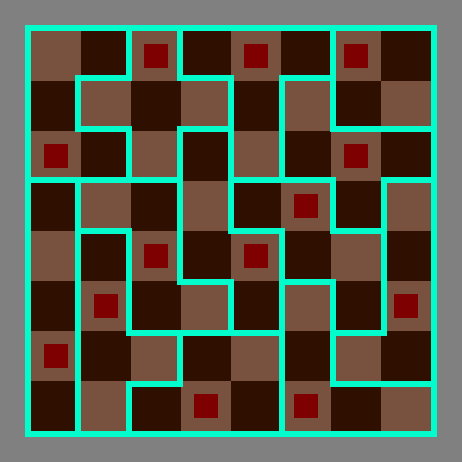


Solution #100


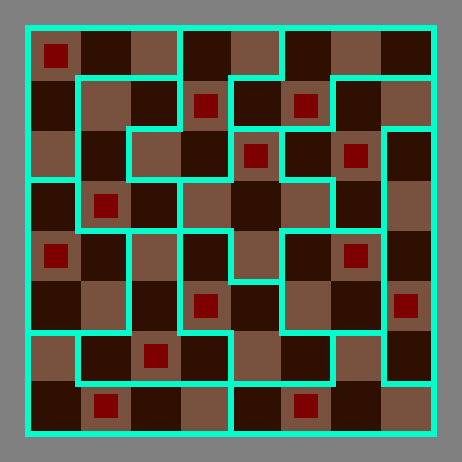


Solution #101


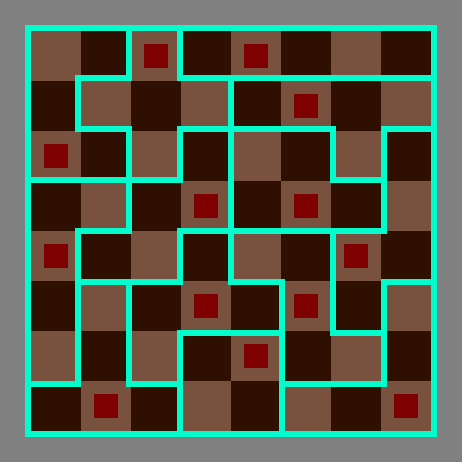


Solution #102


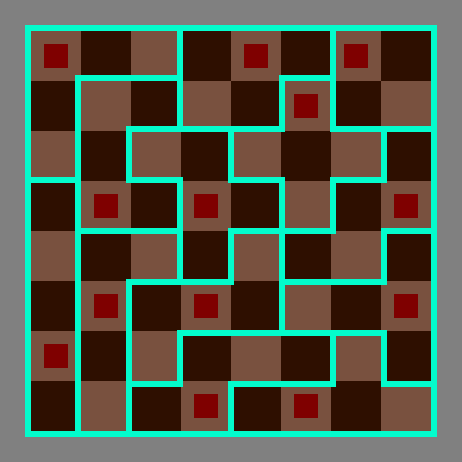


Solution #103


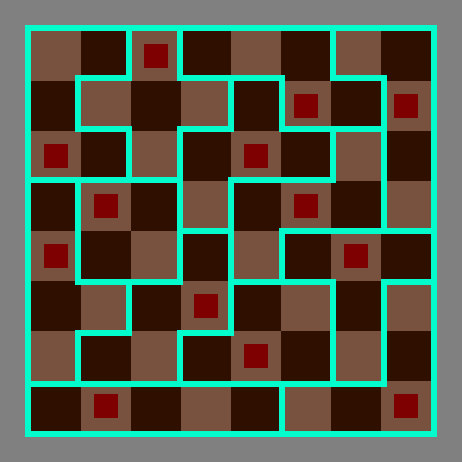


Solution #104


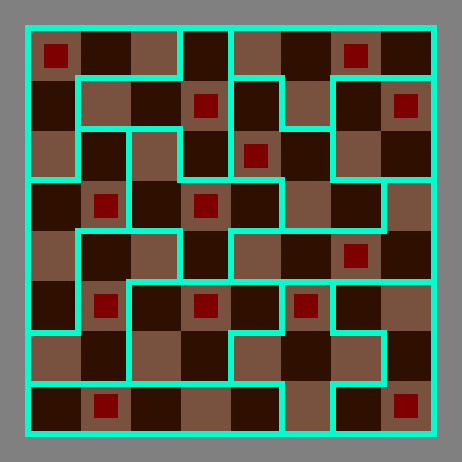


Solution #105


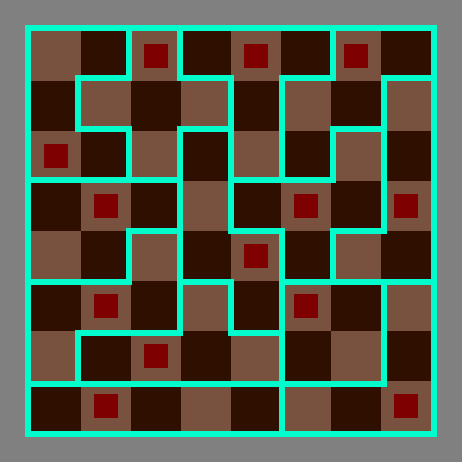


Solution #106


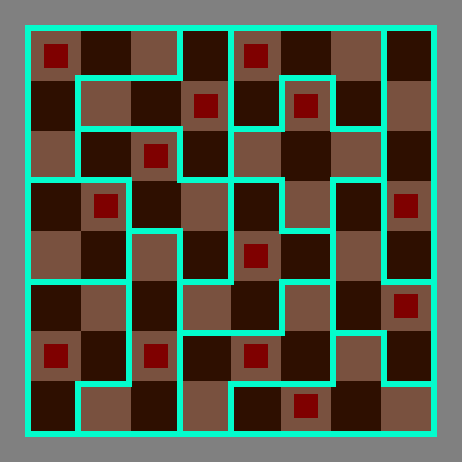


Solution #107


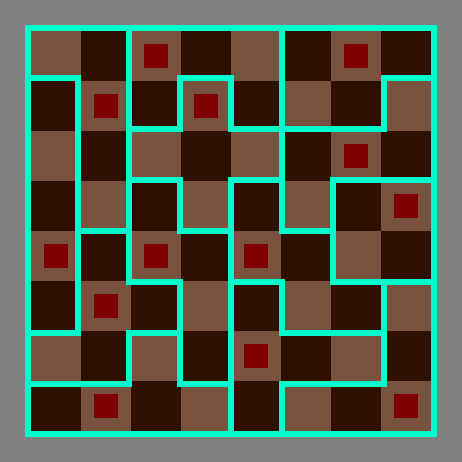


Solution #108


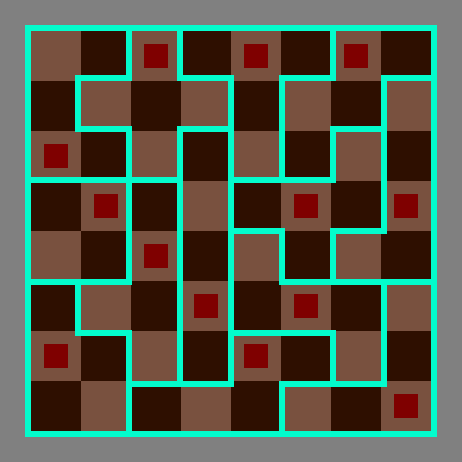


Solution #109


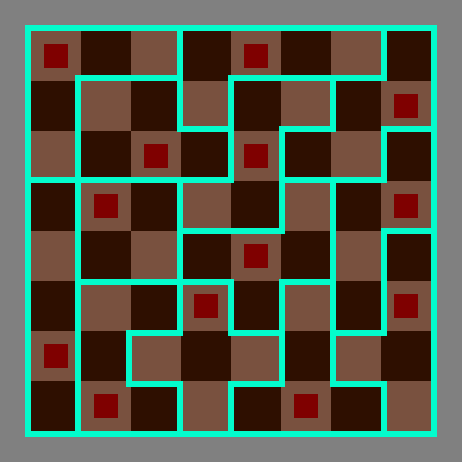


Solution #110


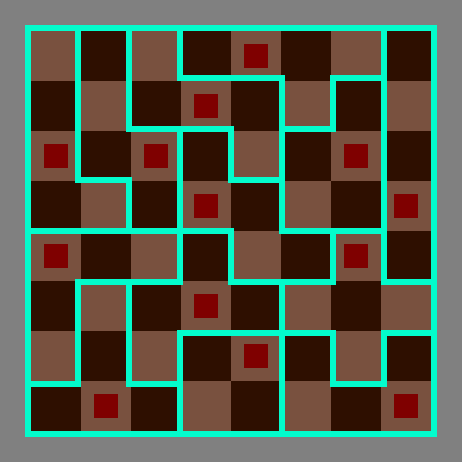


Solution #111


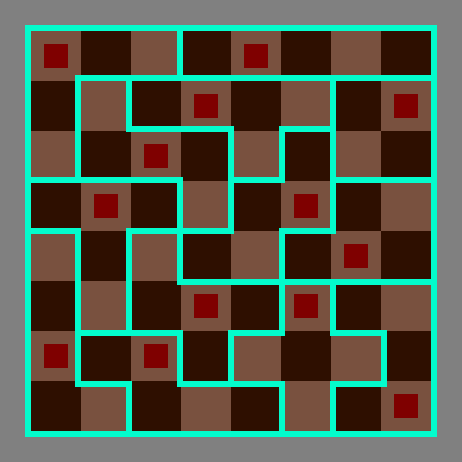


Solution #112


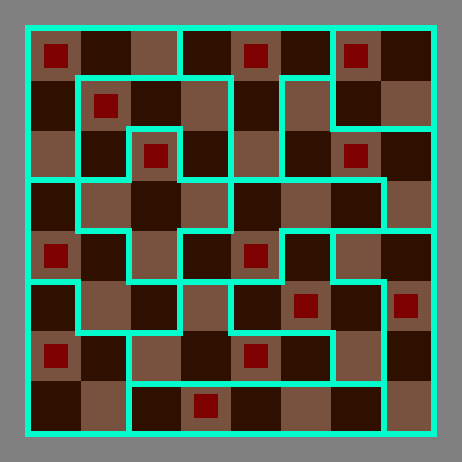


Solution #113


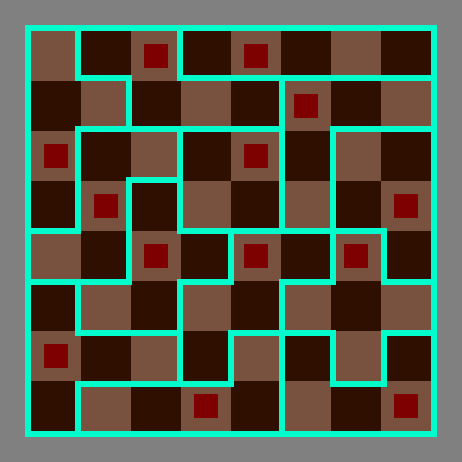


Solution #114


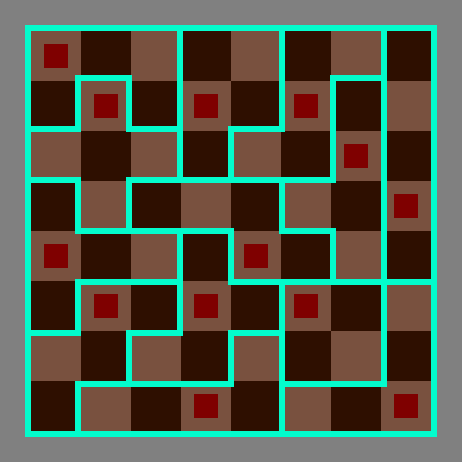


Solution #115


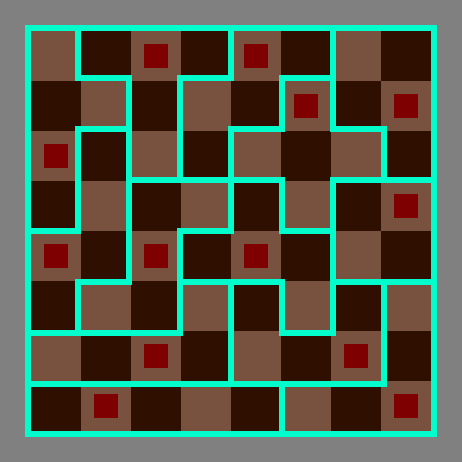


Solution #116


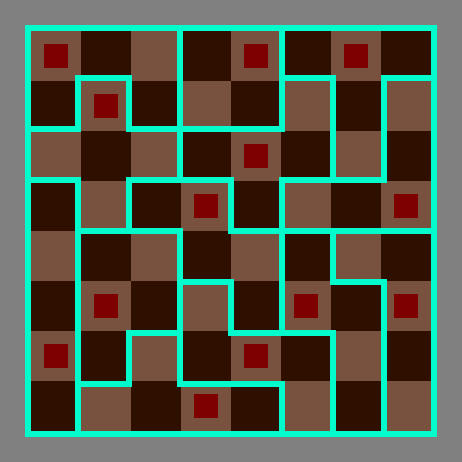


Solution #117


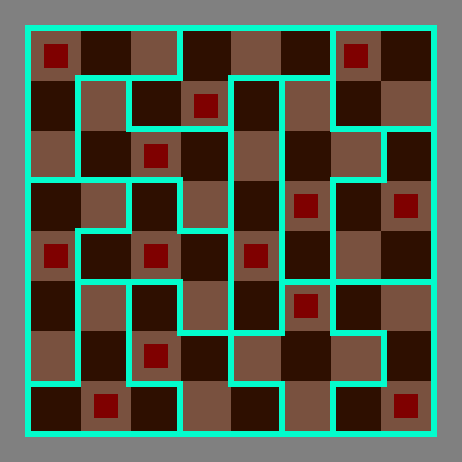


Solution #118


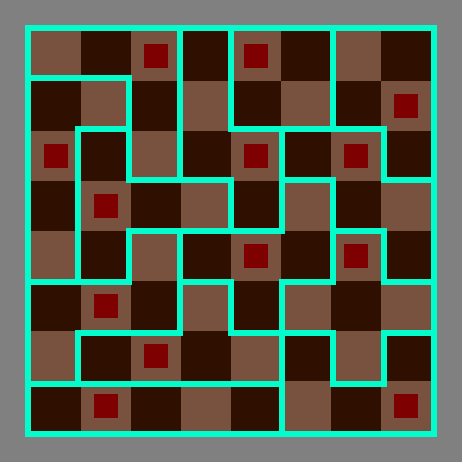


Solution #119


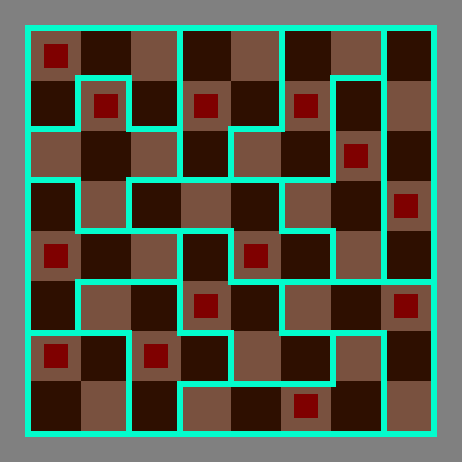


Solution #120


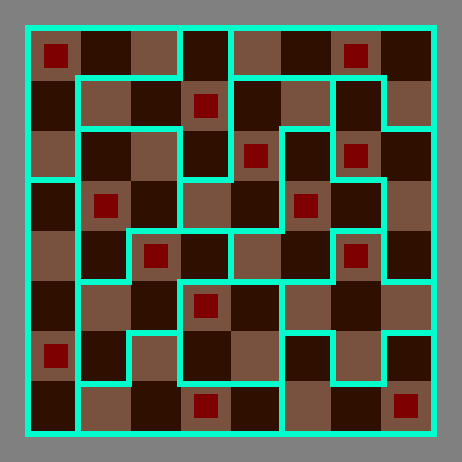


Solution #121


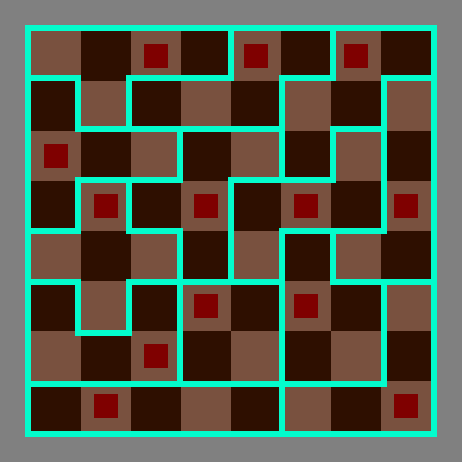


Solution #122


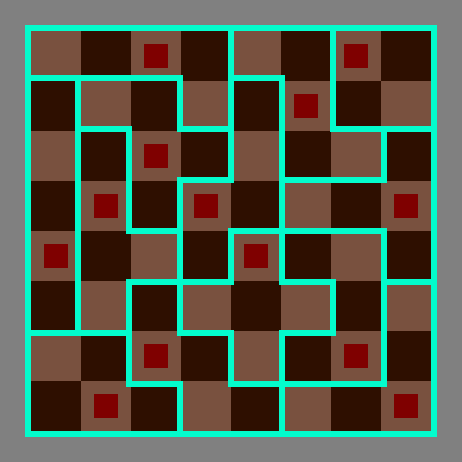


Solution #123


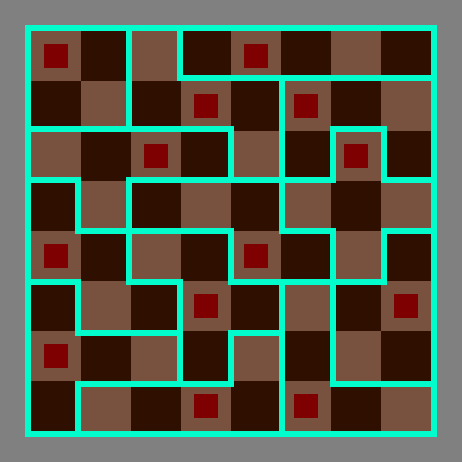


Solution #124


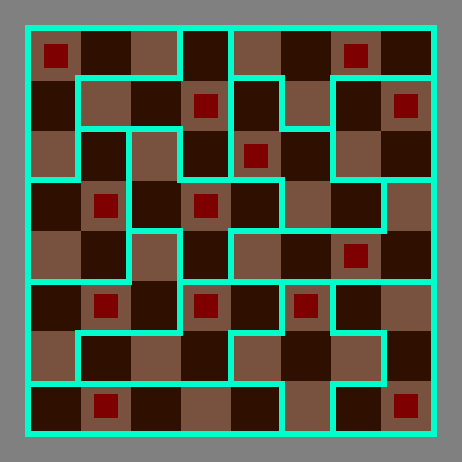


Solution #125


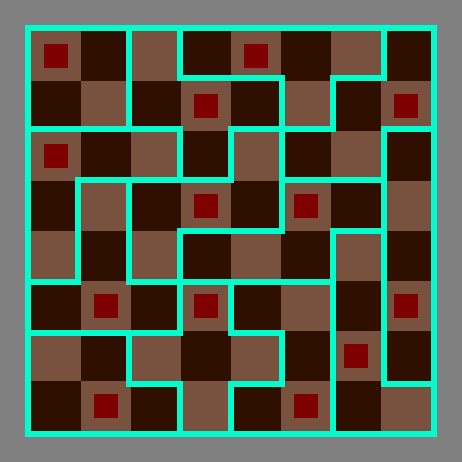


Solution #126


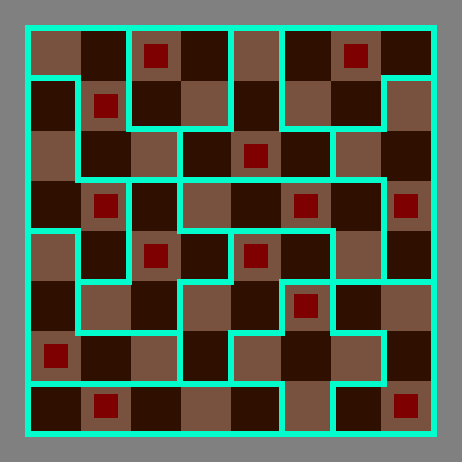


Solution #127


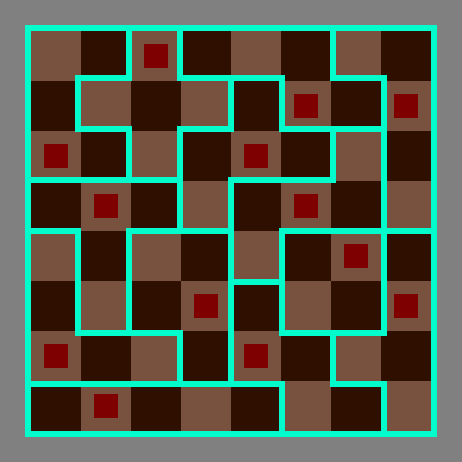


Solution #128


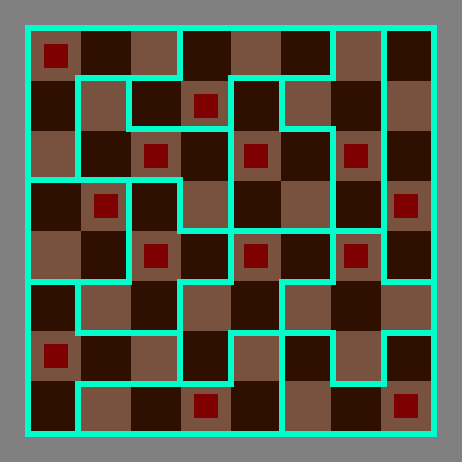


Solution #129


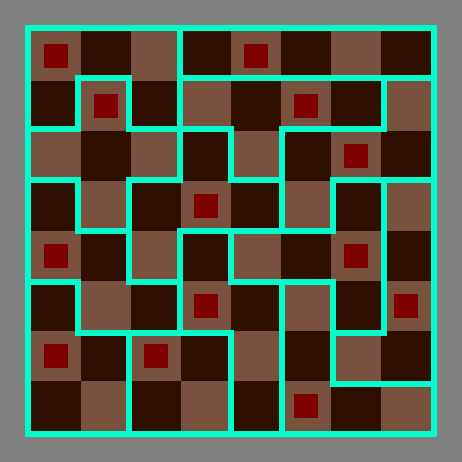


Solution #130


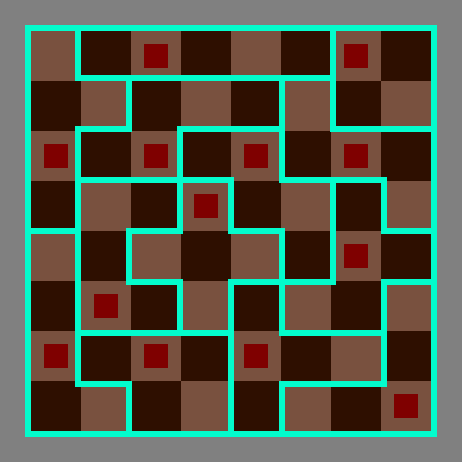


Solution #131


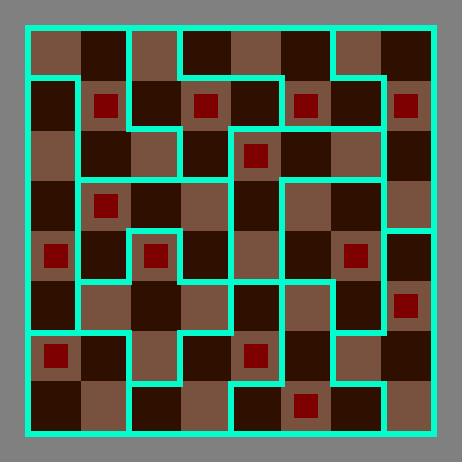


Solution #132


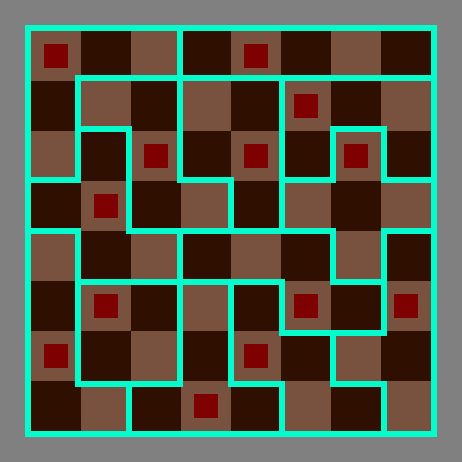


Solution #133


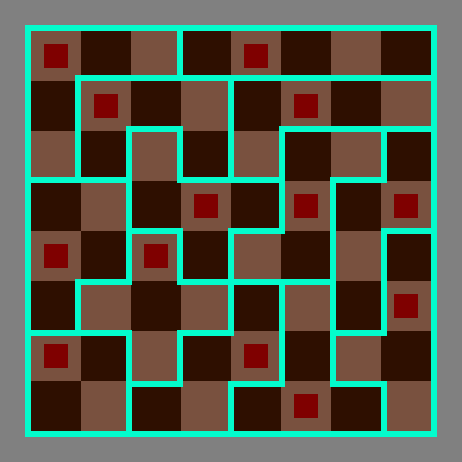


Solution #134


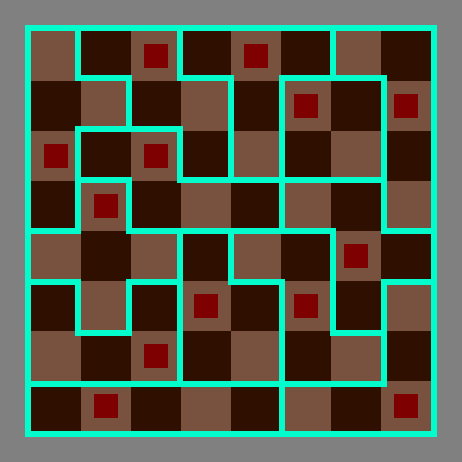


Solution #135


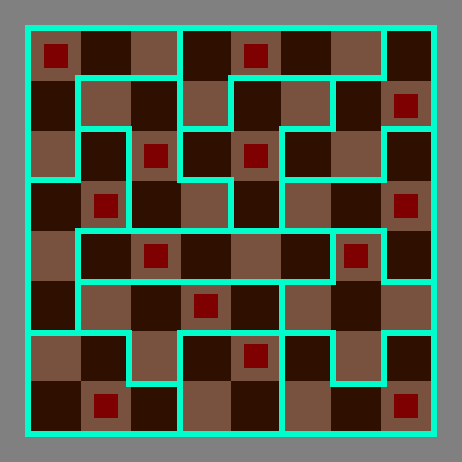


Solution #136


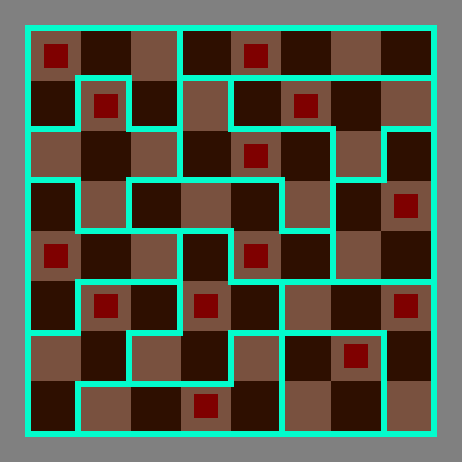


Solution #137


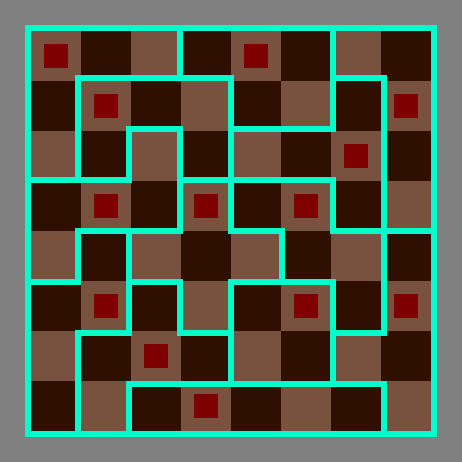


Solution #138


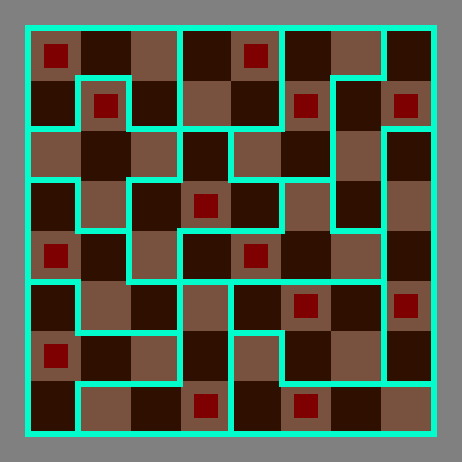


Solution #139


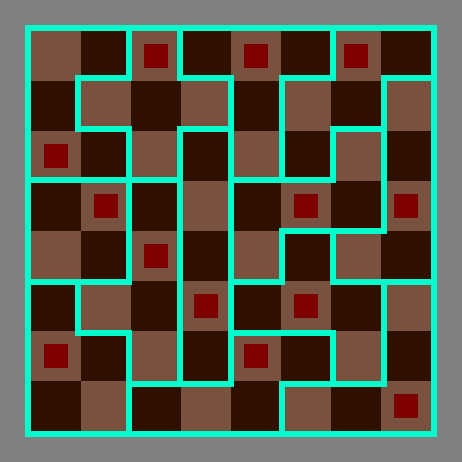


Solution #140


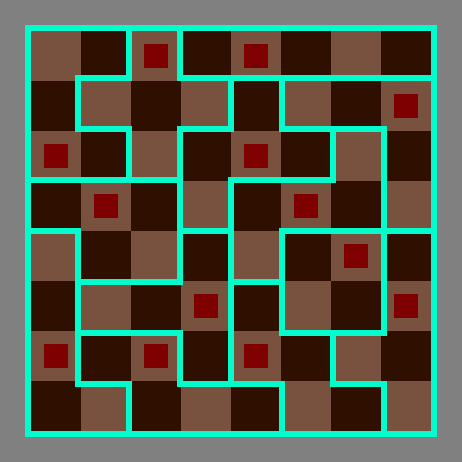


Solution #141


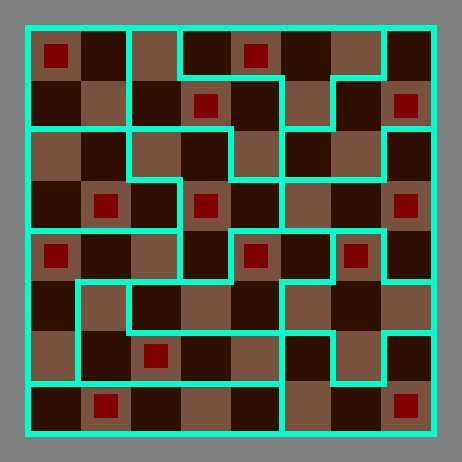


Solution #142


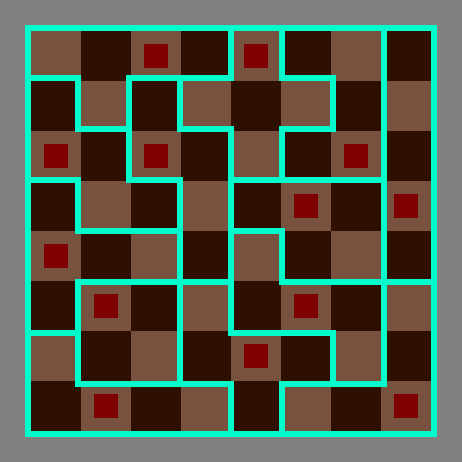


Solution #143


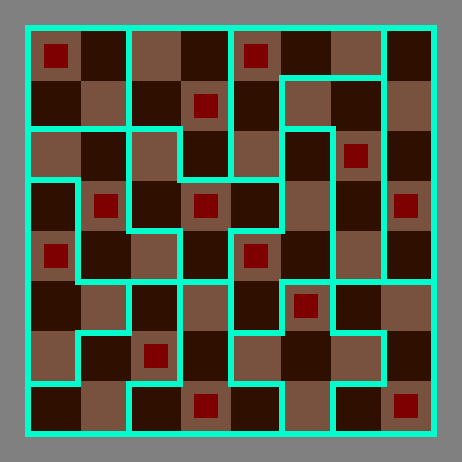


Solution #144


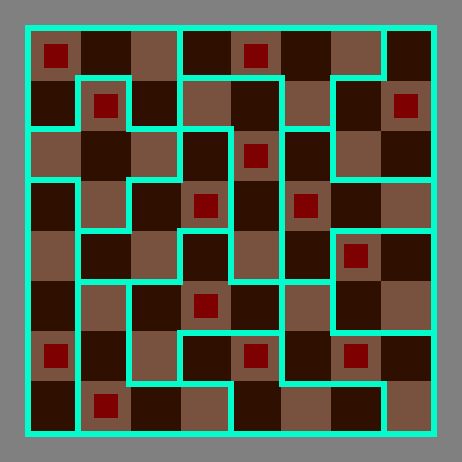


Solution #145


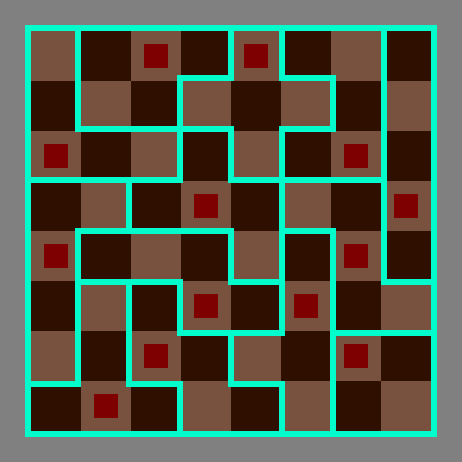


Solution #146


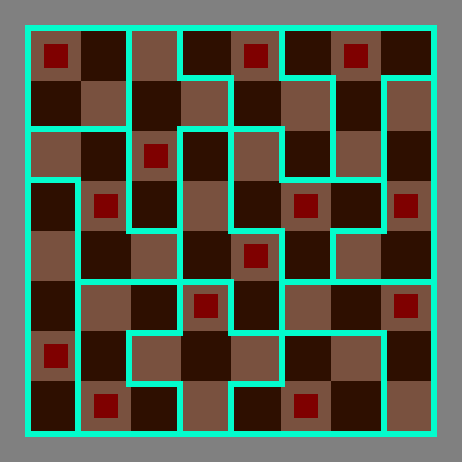


Solution #147


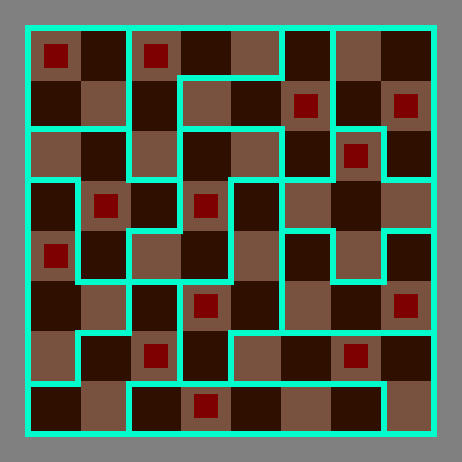


Solution #148


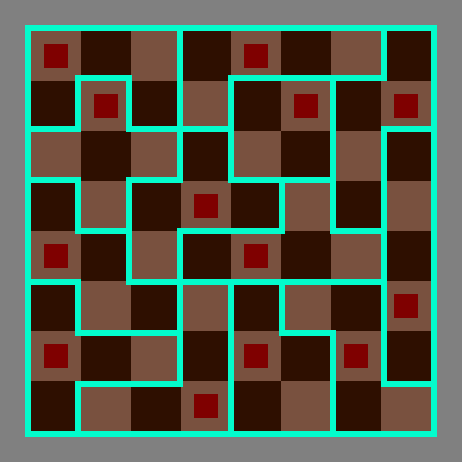


Solution #149


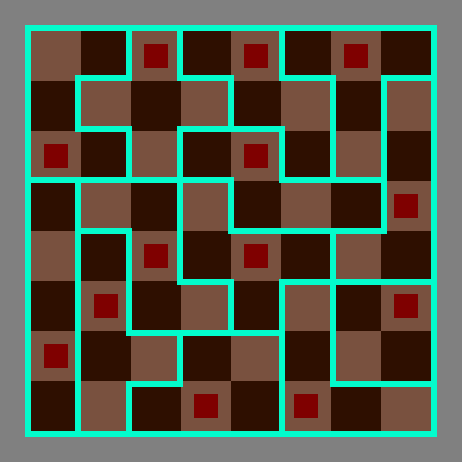


Solution #150


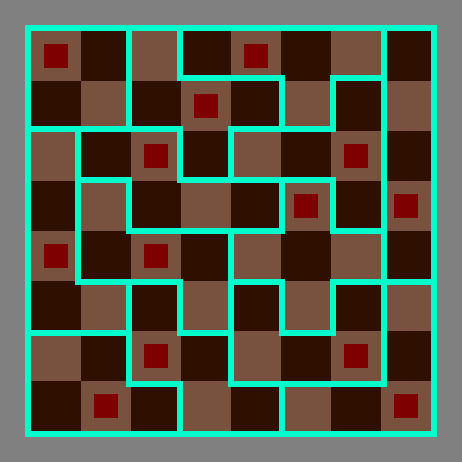


Solution #151


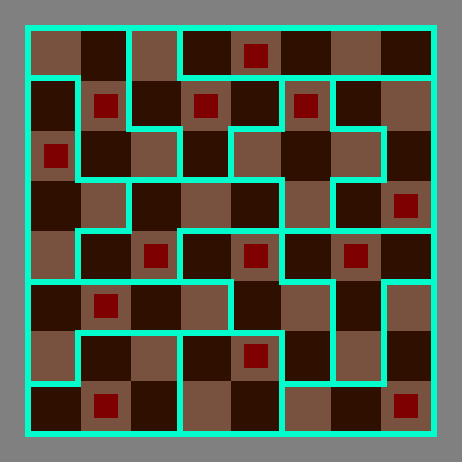


Solution #152


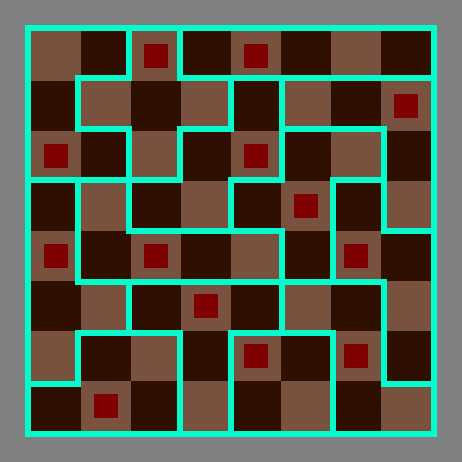


Solution #153


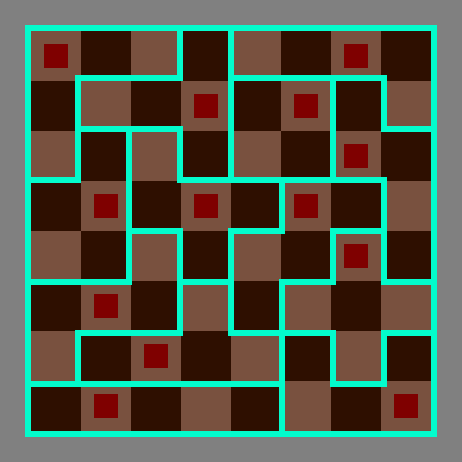


Solution #154


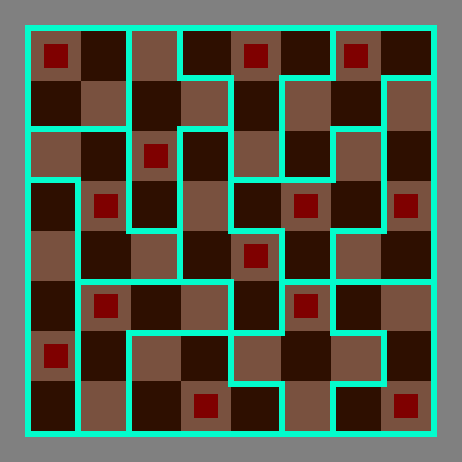


Solution #155


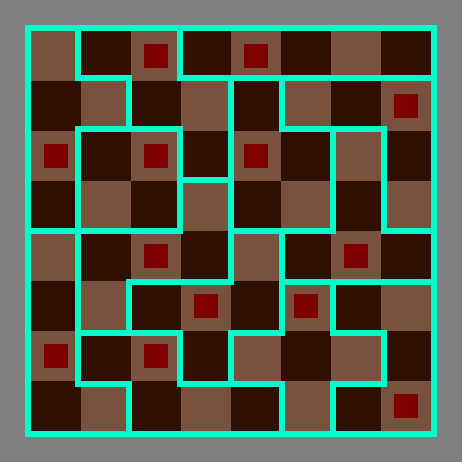


Solution #156


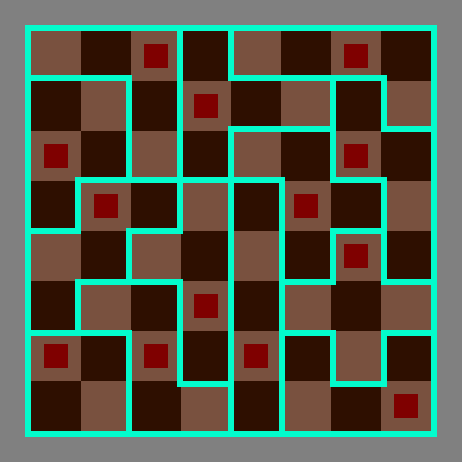


Solution #157


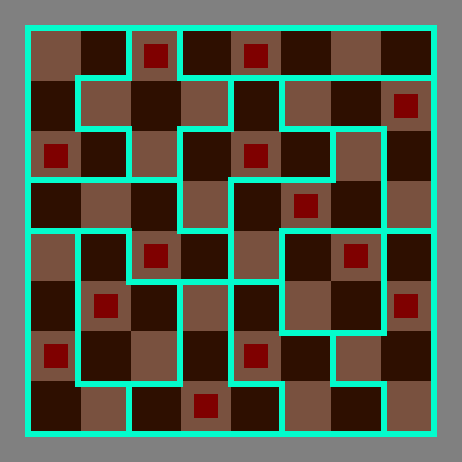


Solution #158


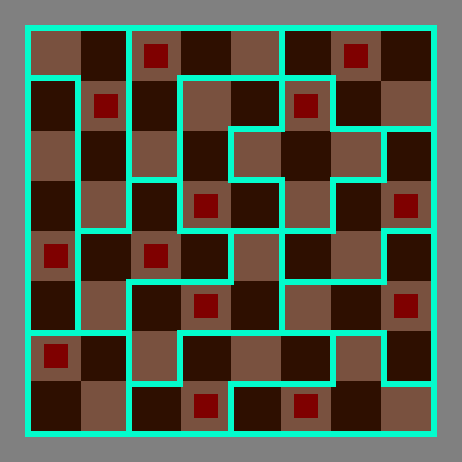


Solution #159


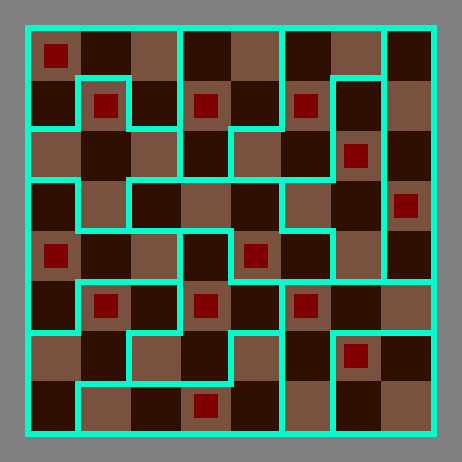


Solution #160


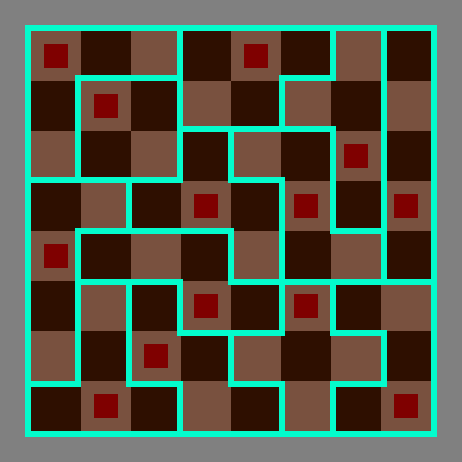


Solution #161


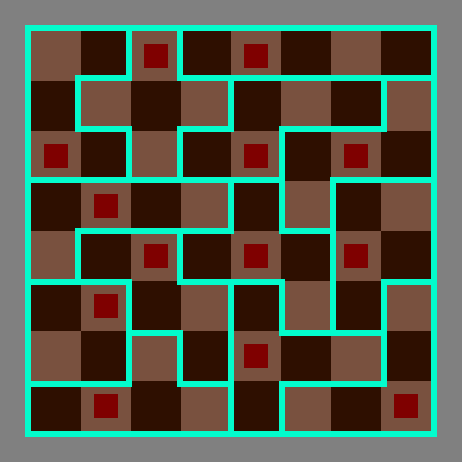


Solution #162


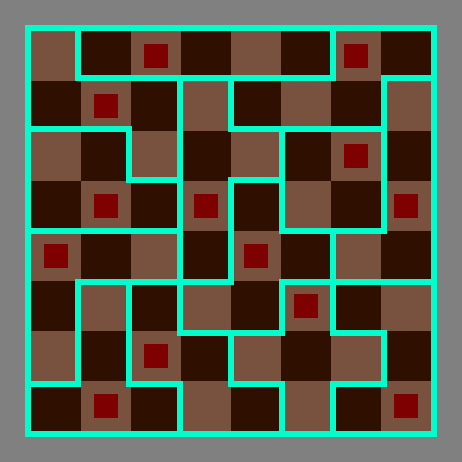


Solution #163


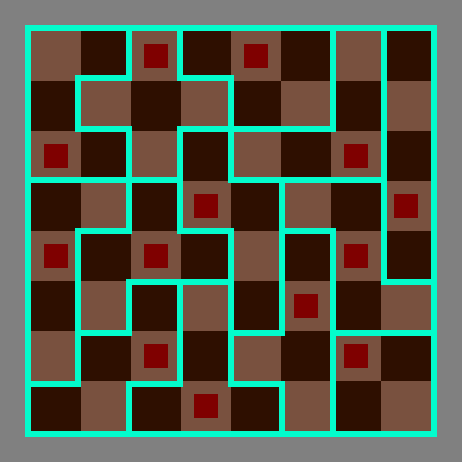


Solution #164


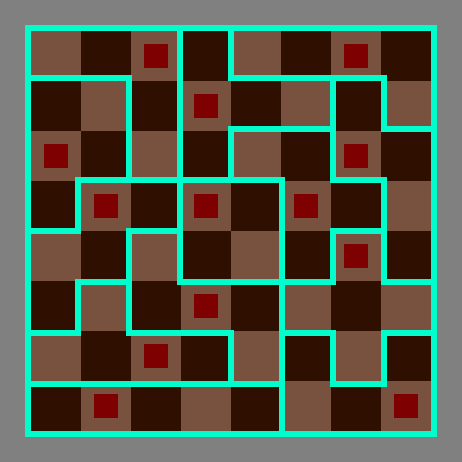


Solution #165


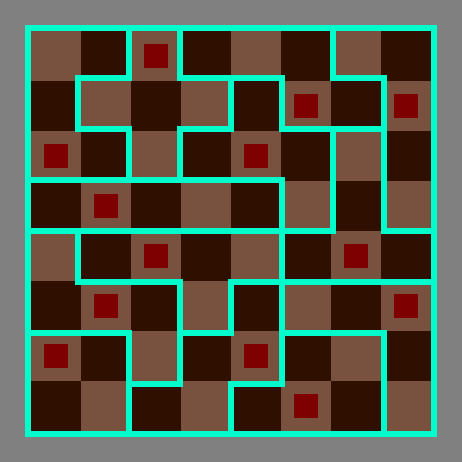


Solution #166


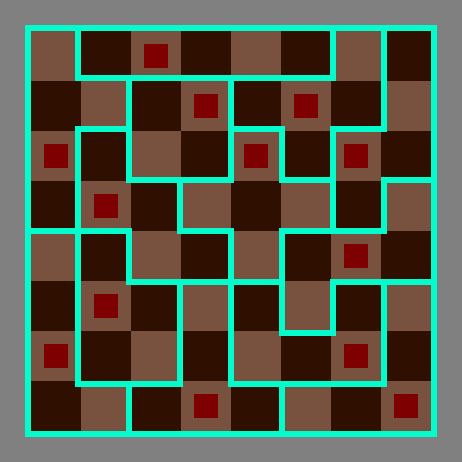


Solution #167


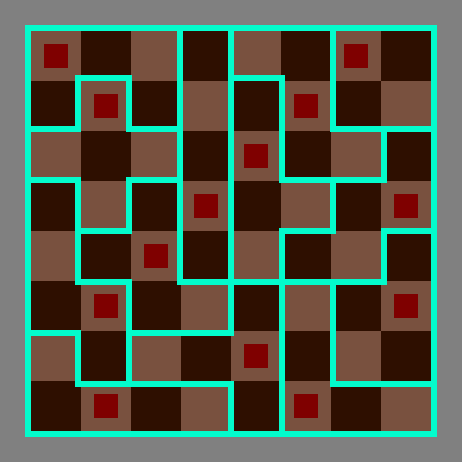


Solution #168


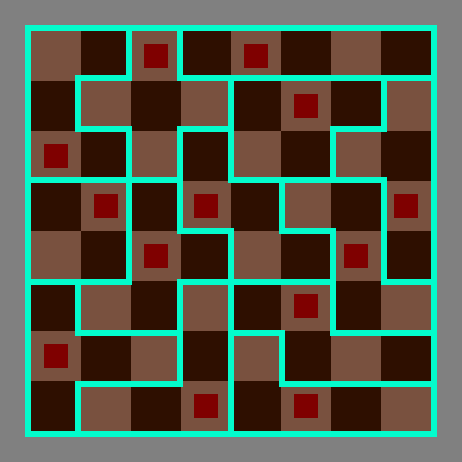


Solution #169


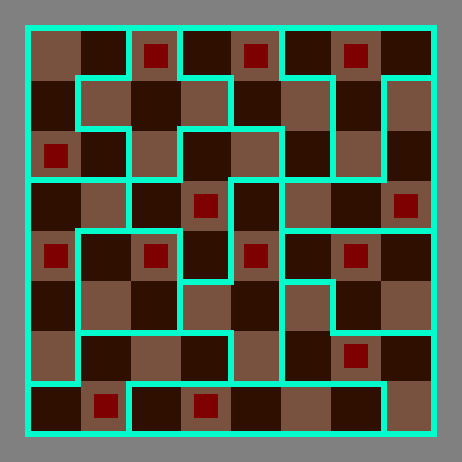


Solution #170


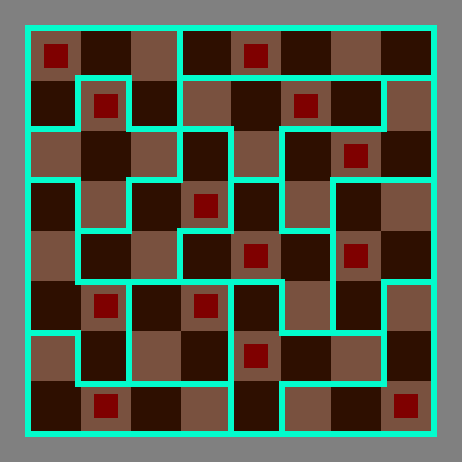


Solution #171


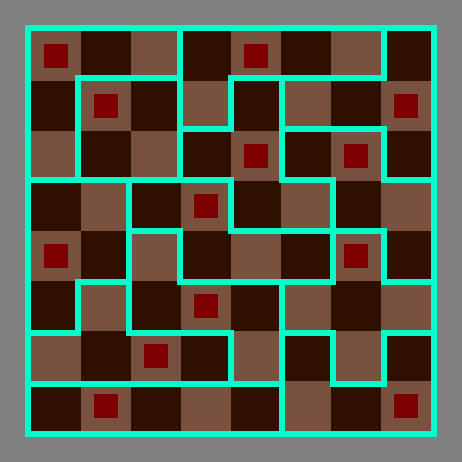


Solution #172


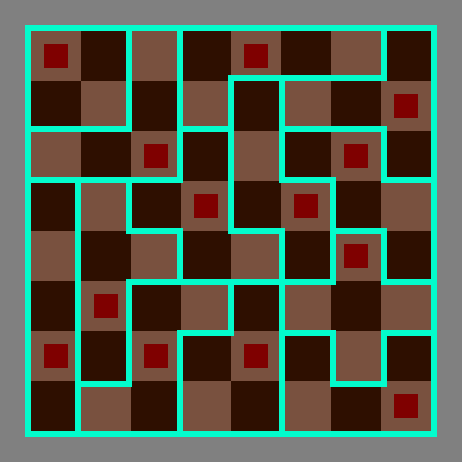


Solution #173


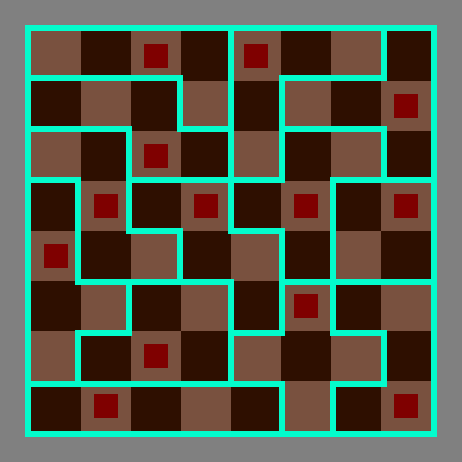


Solution #174


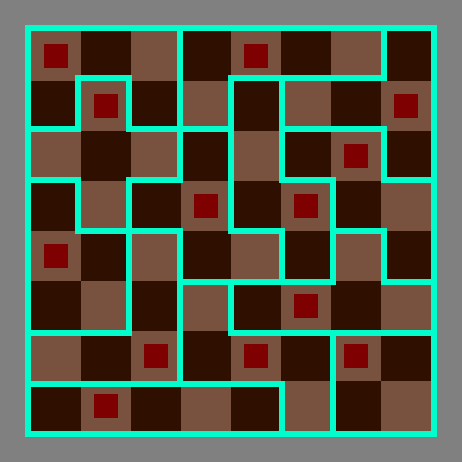


Solution #175


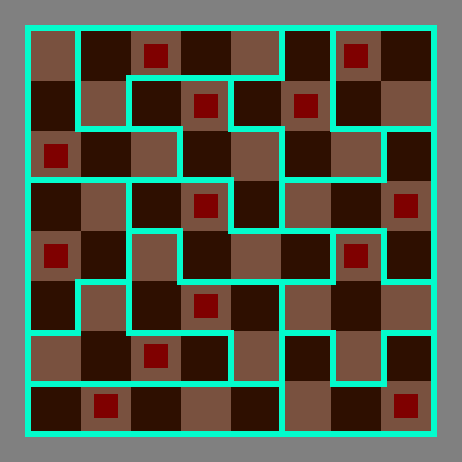


Solution #176


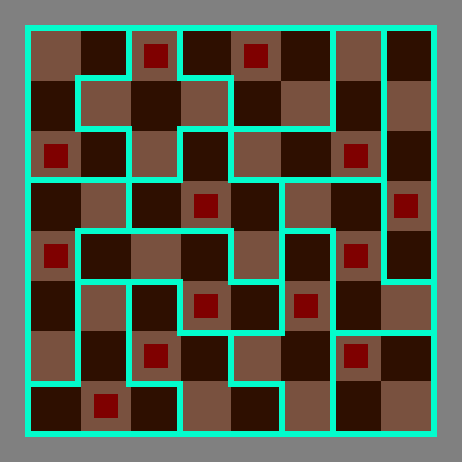


Solution #177


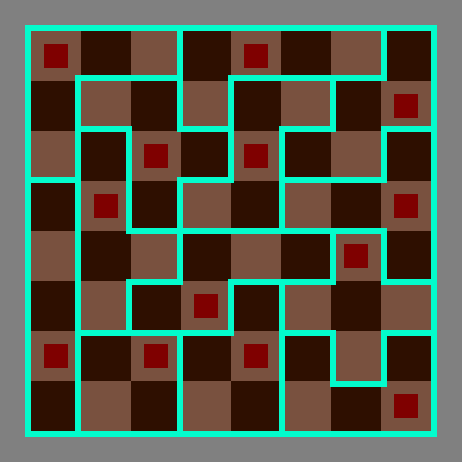


Solution #178


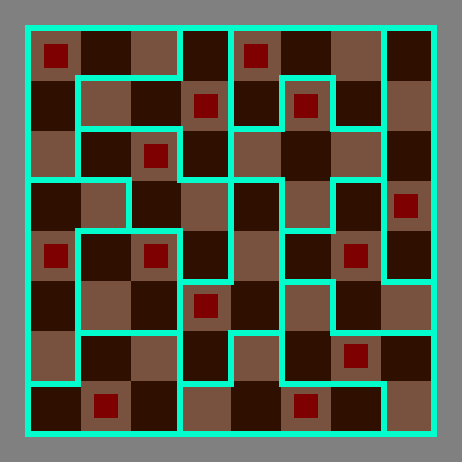


Solution #179


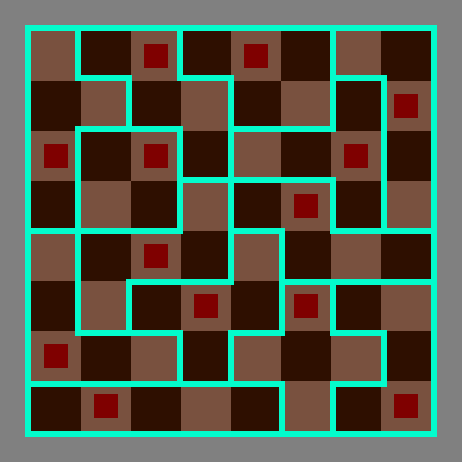


Solution #180


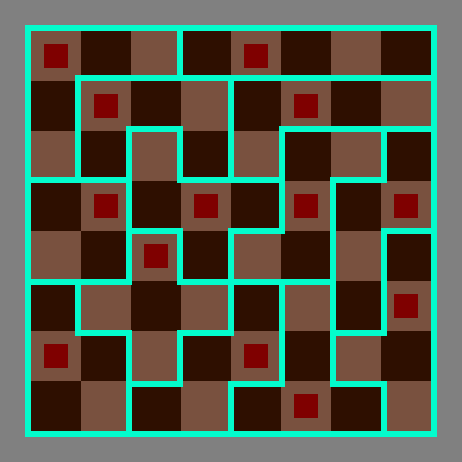


Solution #181


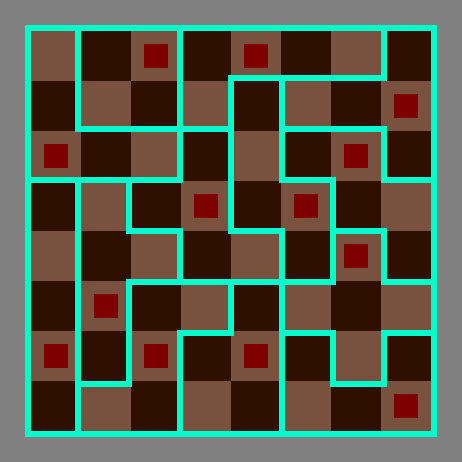


Solution #182


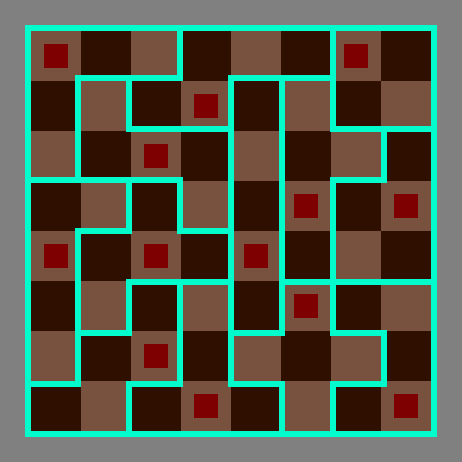


Solution #183


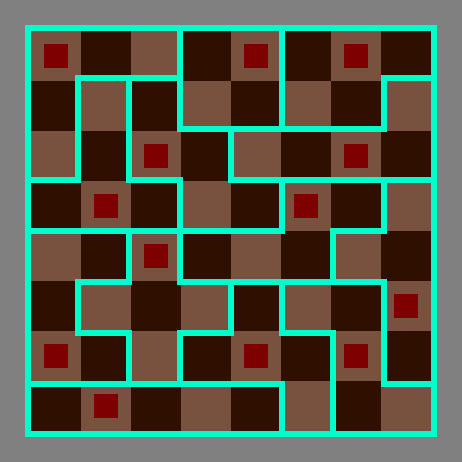


Solution #184


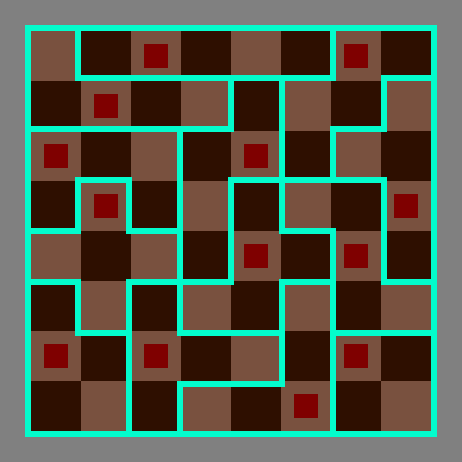


Solution #185


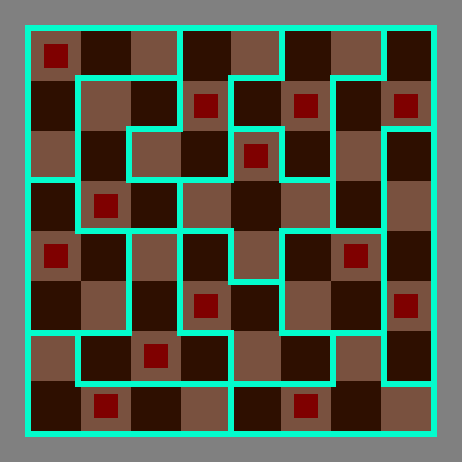


Solution #186


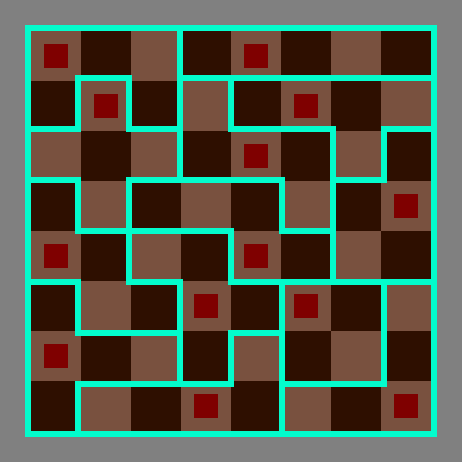


Solution #187


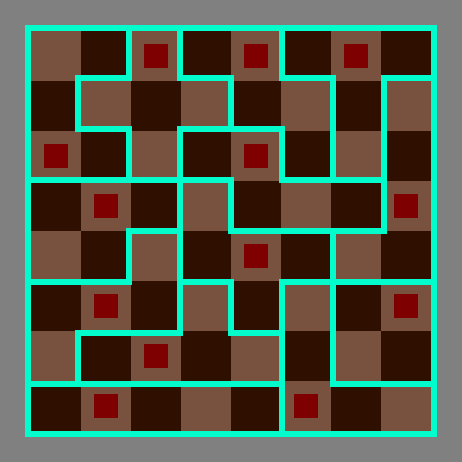


Solution #188


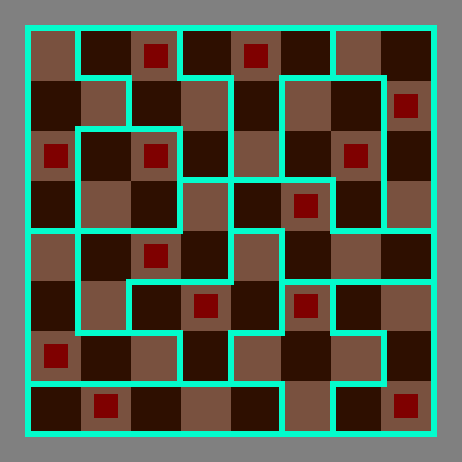


Solution #189


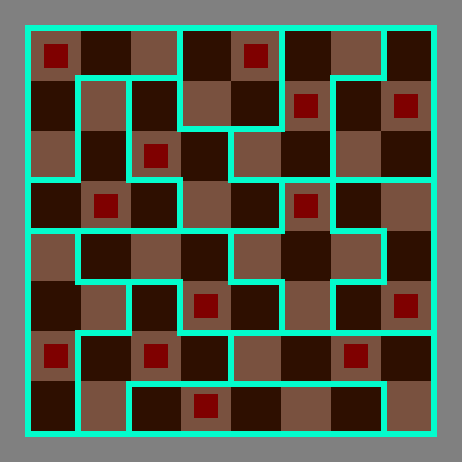


Solution #190


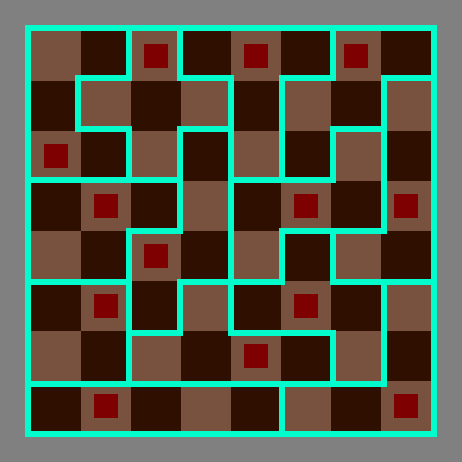


Solution #191


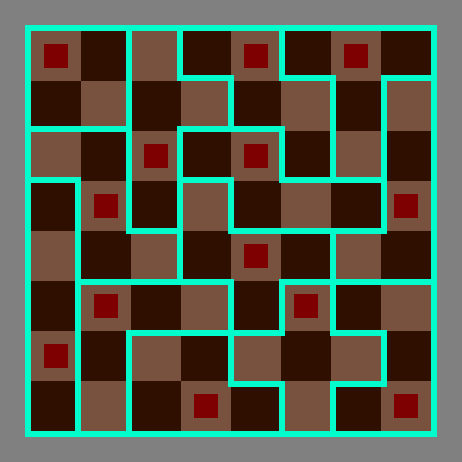


Solution #192


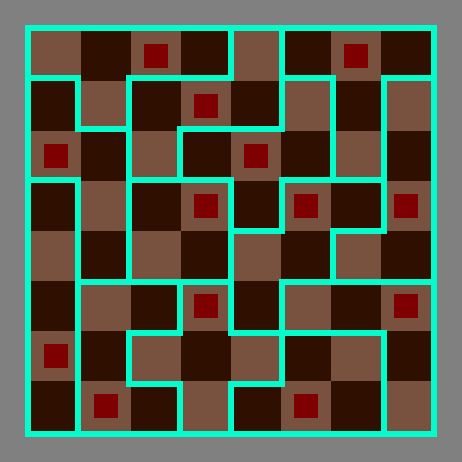


Solution #193


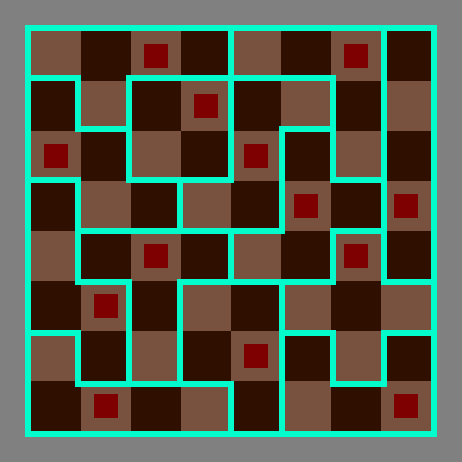


Solution #194


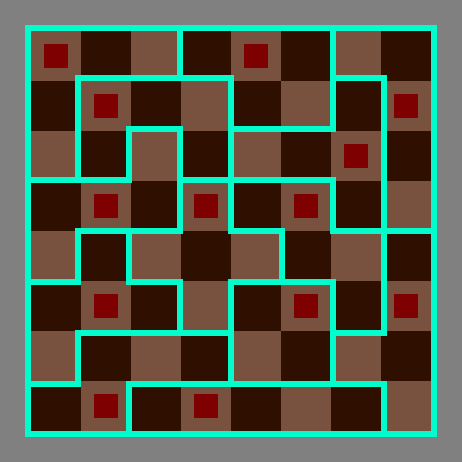


Solution #195


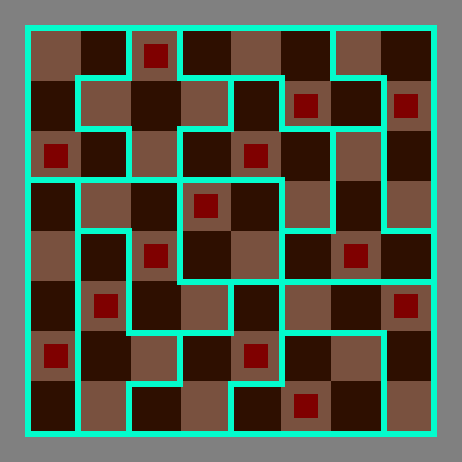


Solution #196


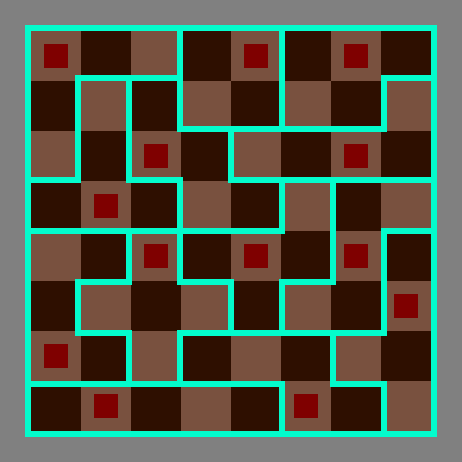


Solution #197


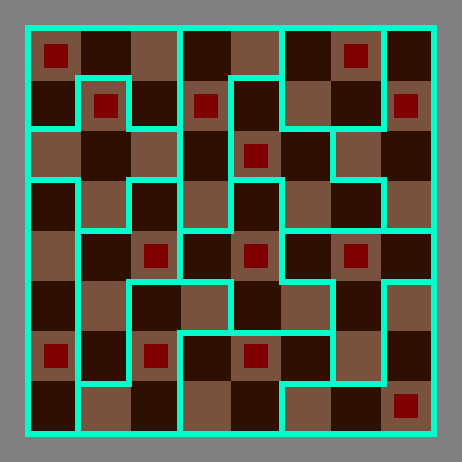


Solution #198


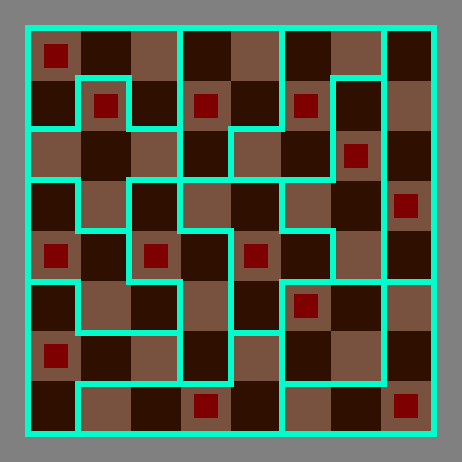


Solution #199


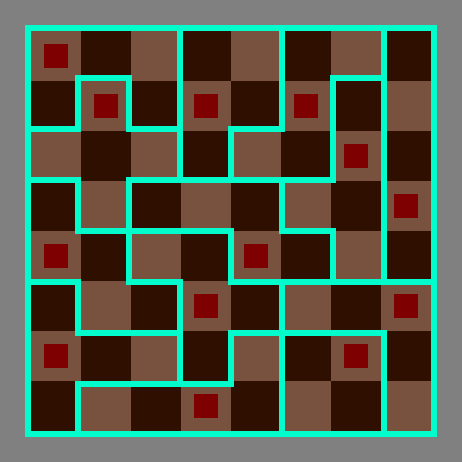


Solution #200


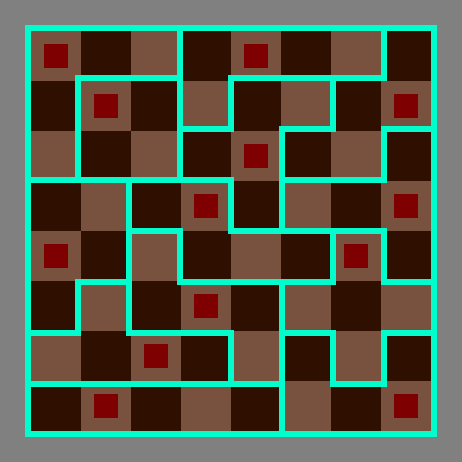


Solution #201


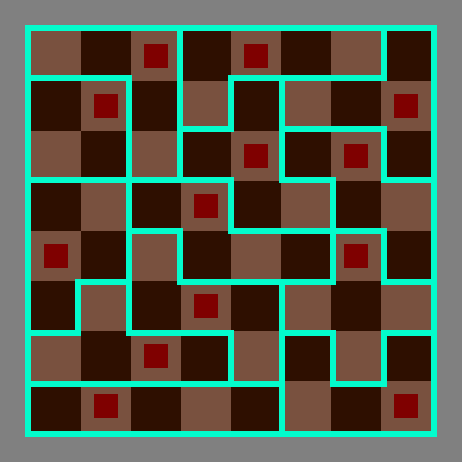


Solution #202


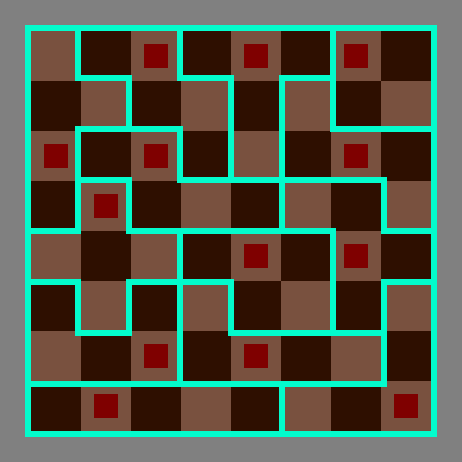


Solution #203


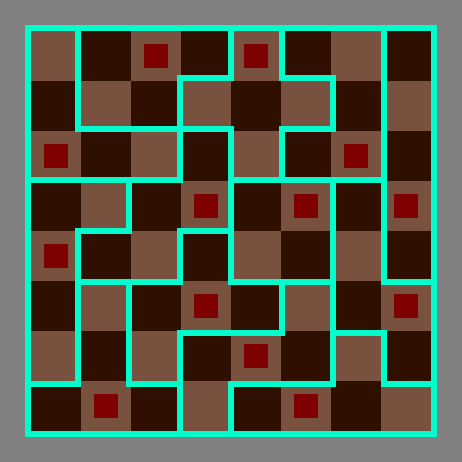


Solution #204


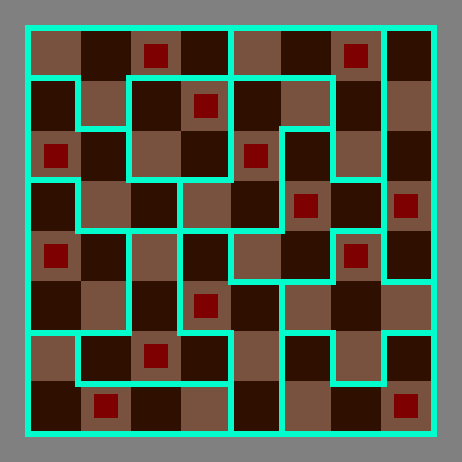


Solution #205


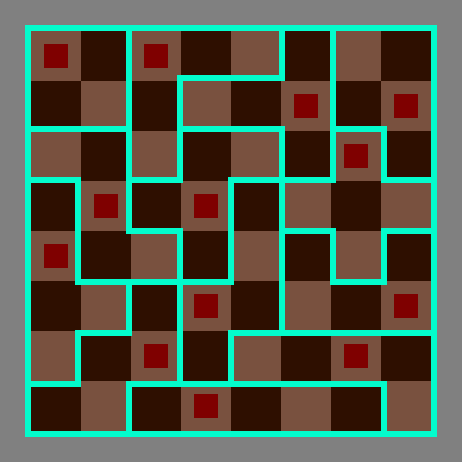


Solution #206


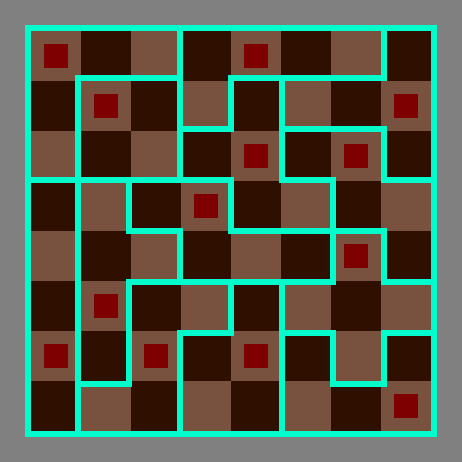


Solution #207


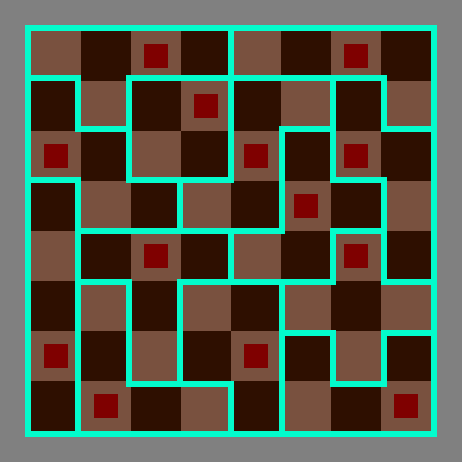


Solution #208


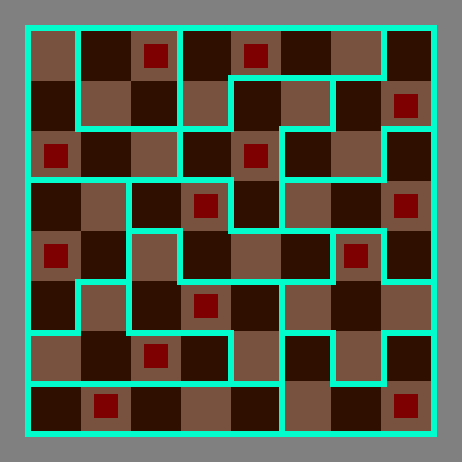


Solution #209


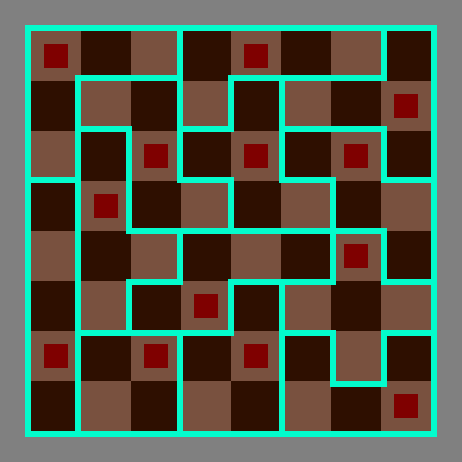


Solution #210


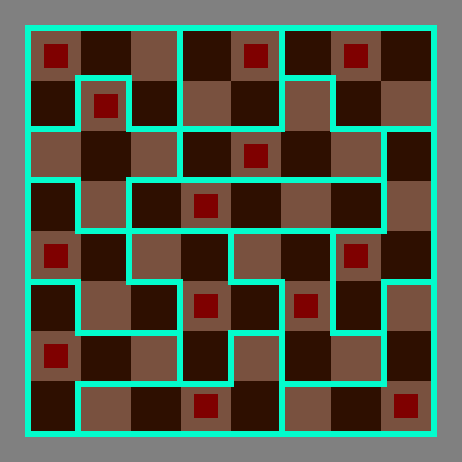


Solution #211


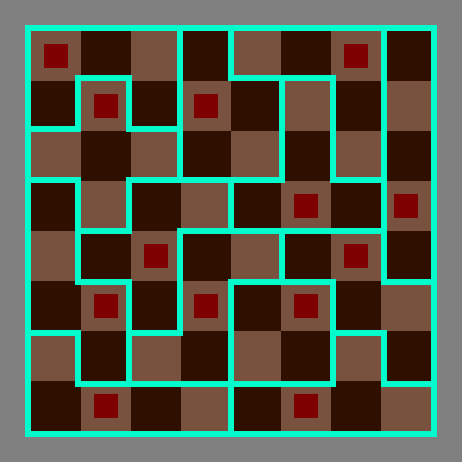


Solution #212


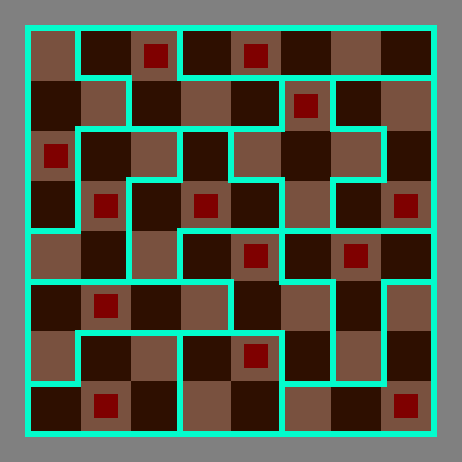


Solution #213


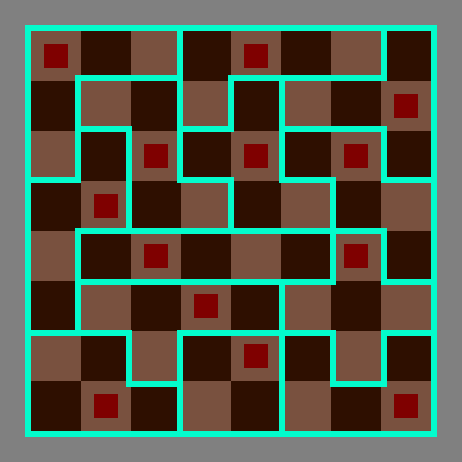


Solution #214


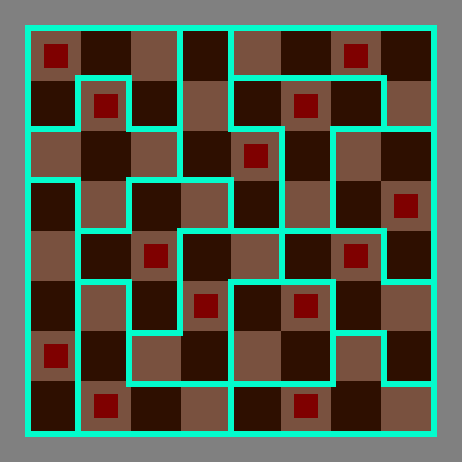


Solution #215


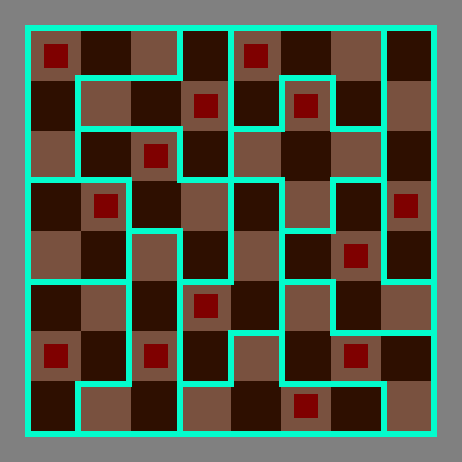


Solution #216


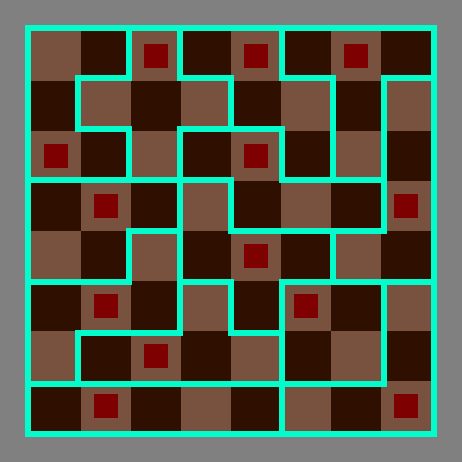


Solution #217


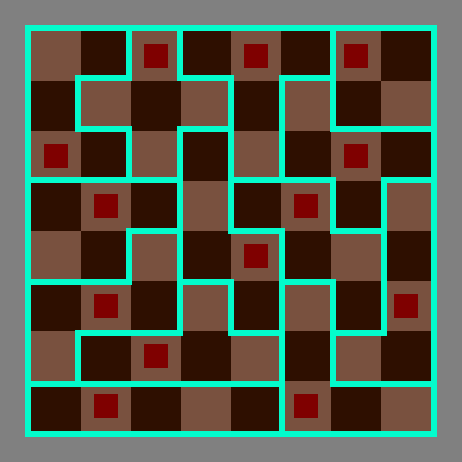


Solution #218


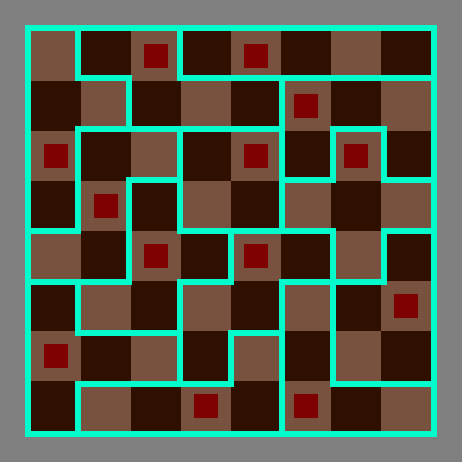


Solution #219


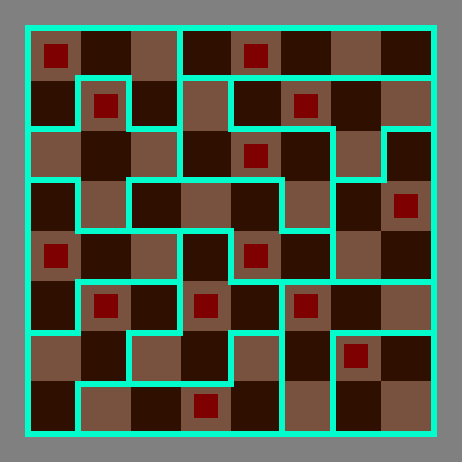


Solution #220


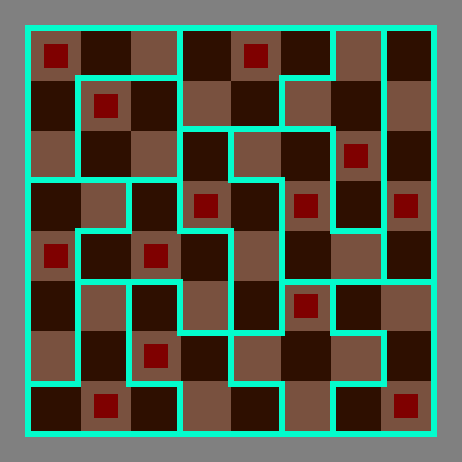


Solution #221


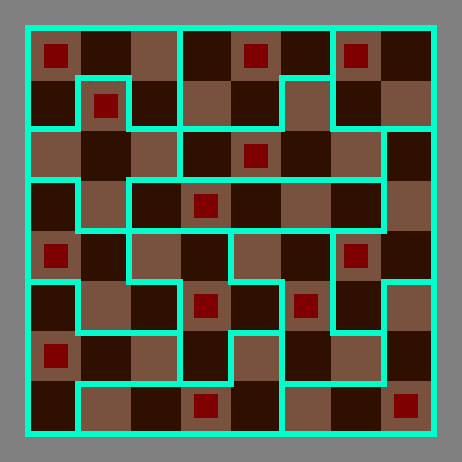


Solution #222


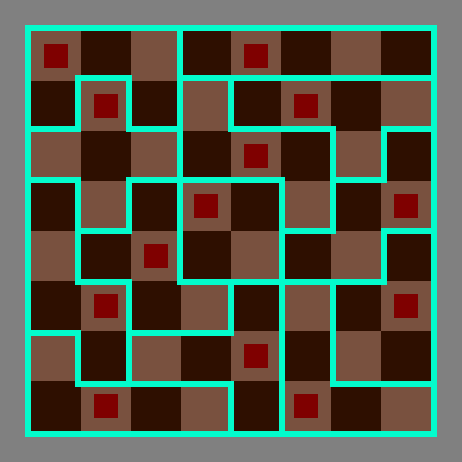


Solution #223


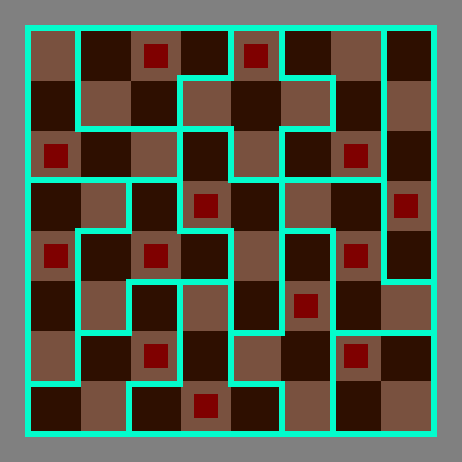


Solution #224


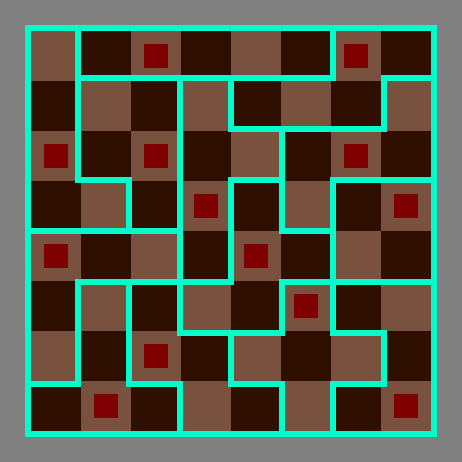


Solution #225


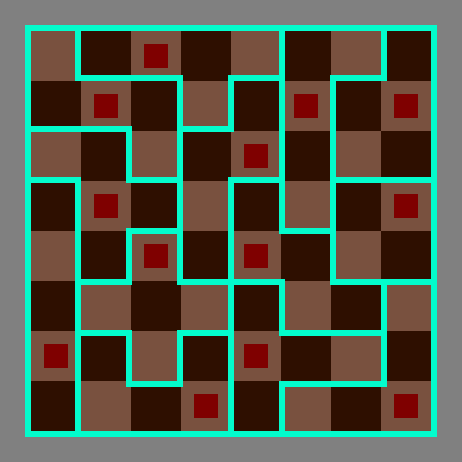


Solution #226


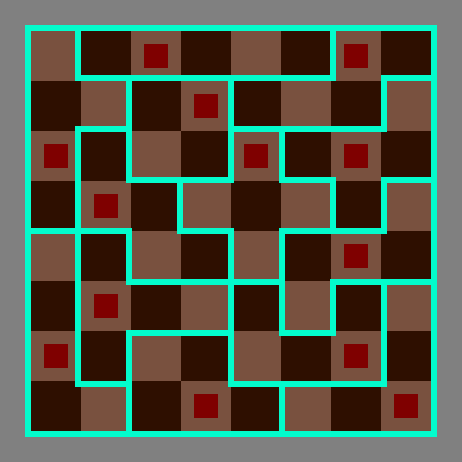


Solution #227


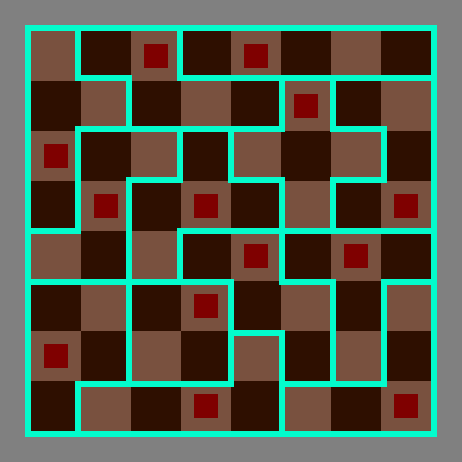


Solution #228


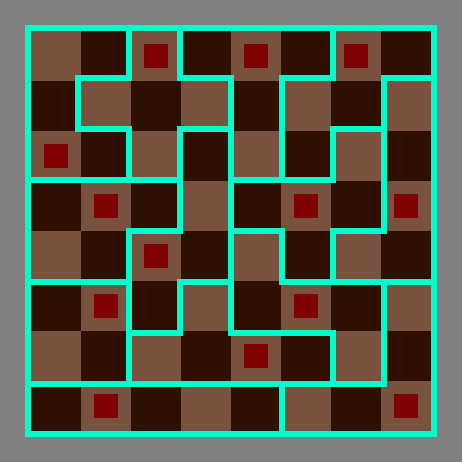


Solution #229


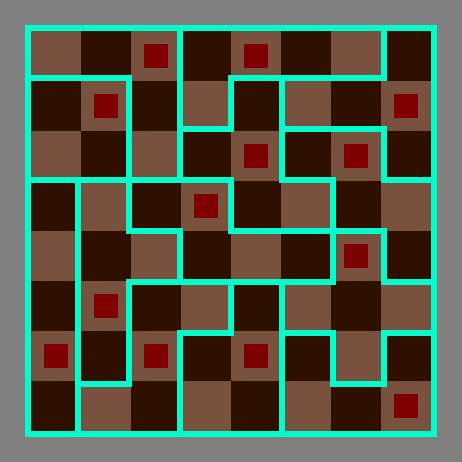


Solution #230


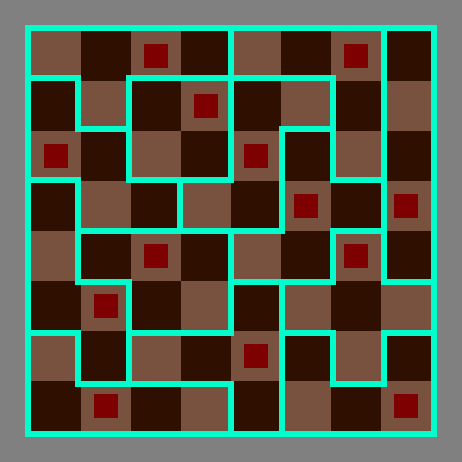


Solution #231


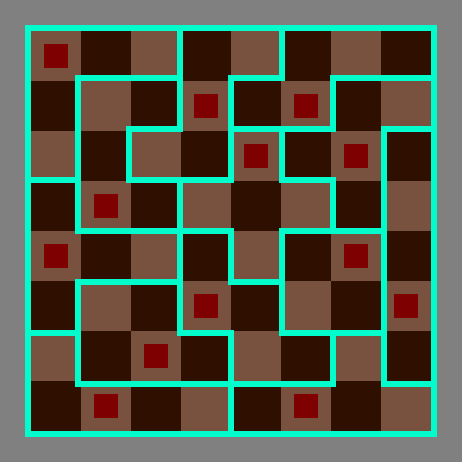


Solution #232


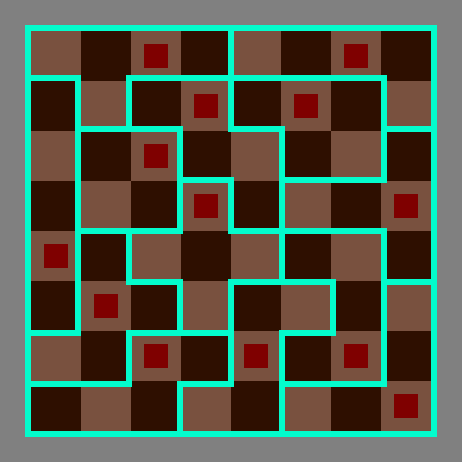


Solution #233


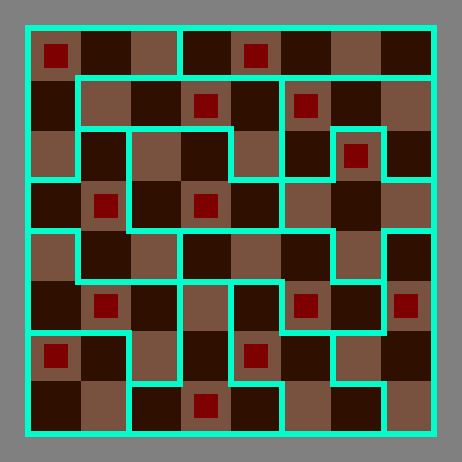


Solution #234


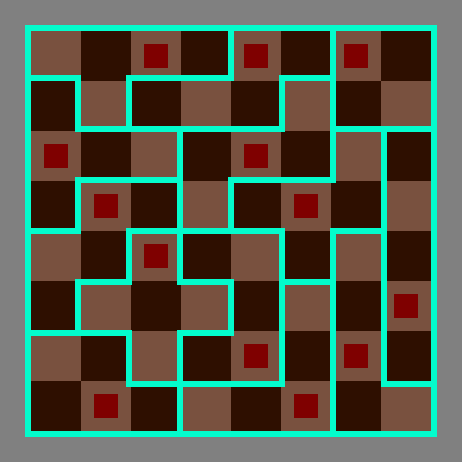


Solution #235


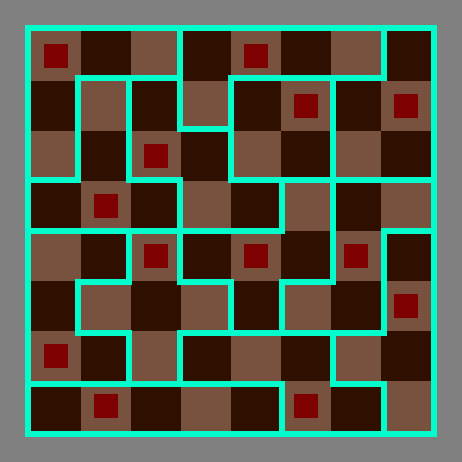


Solution #236


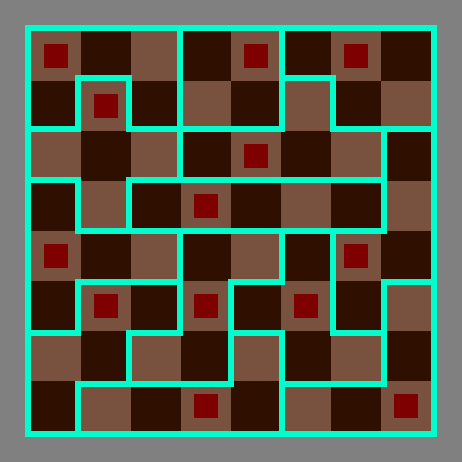


Solution #237


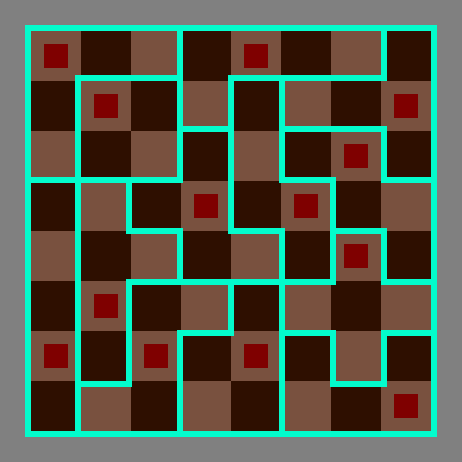


Solution #238


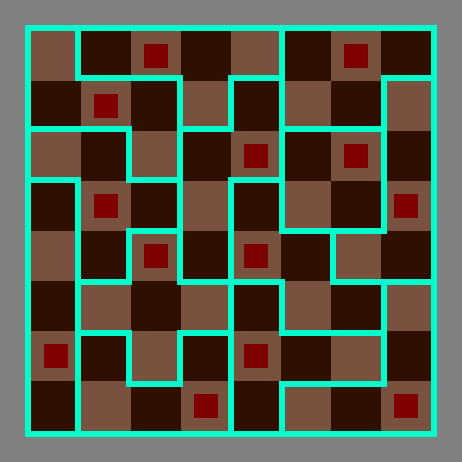


Solution #239


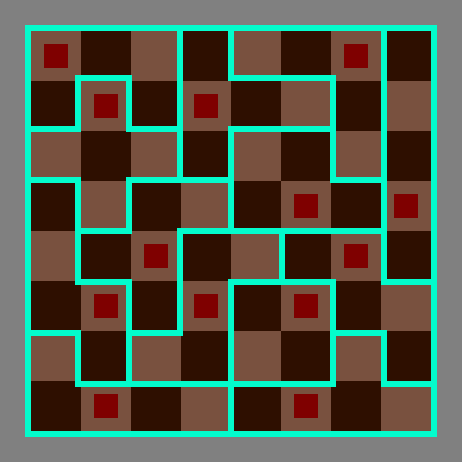


Solution #240


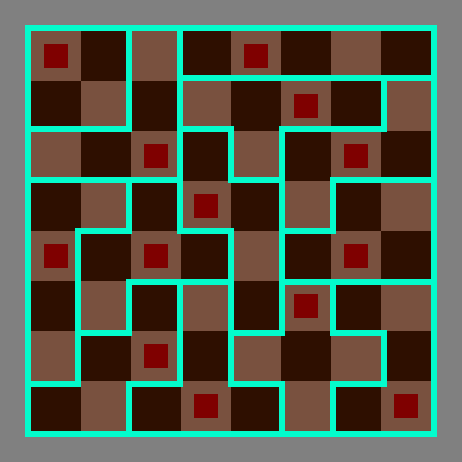


Solution #241


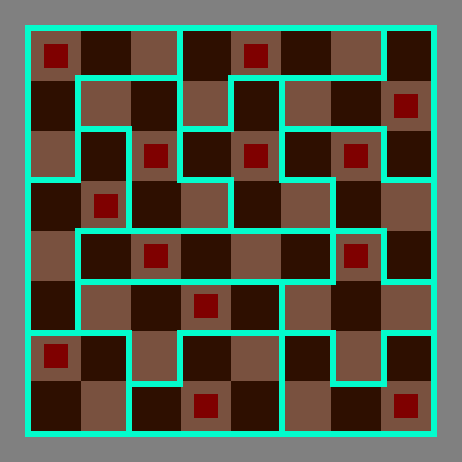


Solution #242


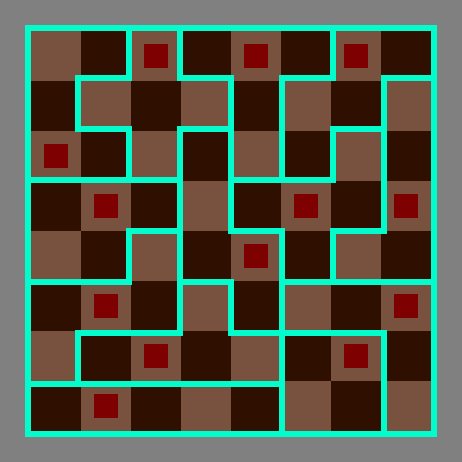


Solution #243


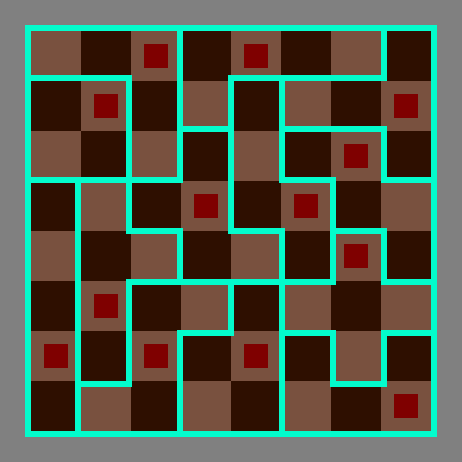


Solution #244


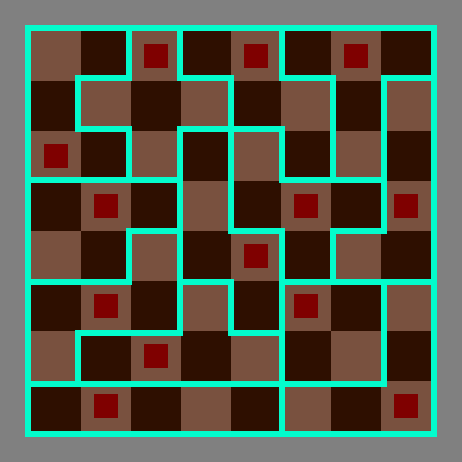


Solution #245


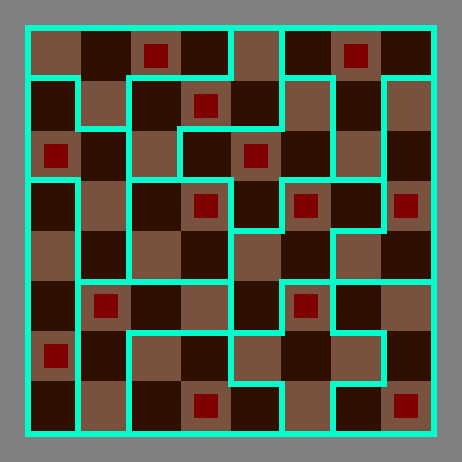


Solution #246


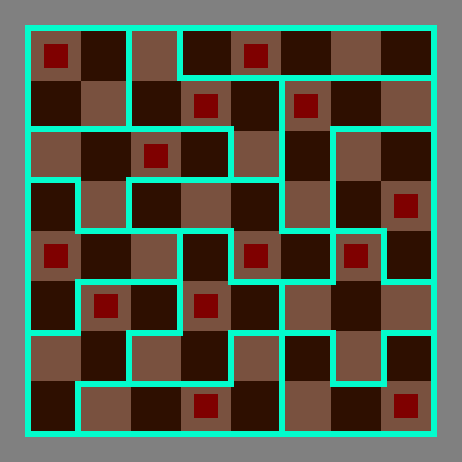


Solution #247


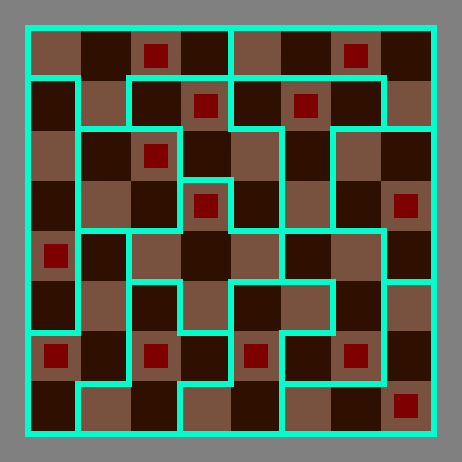


Solution #248


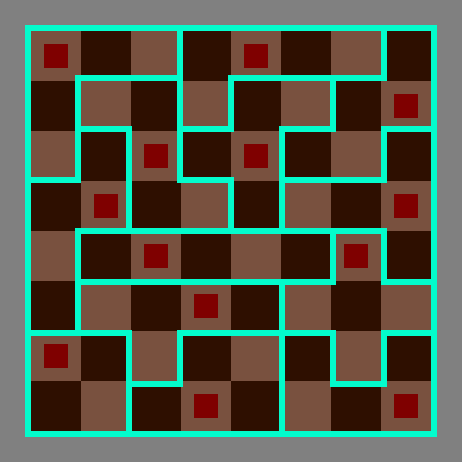


Solution #249


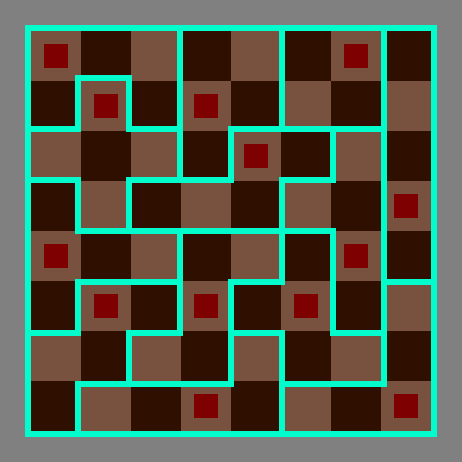


Solution #250


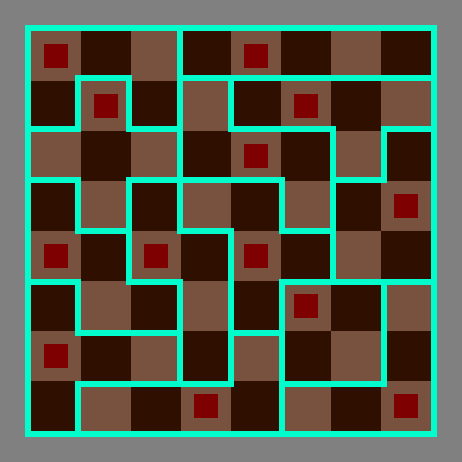


Solution #251


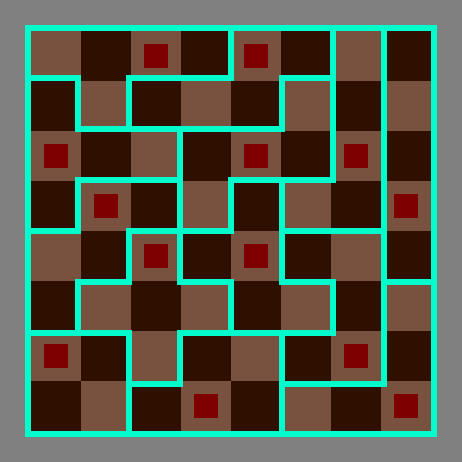


Solution #252


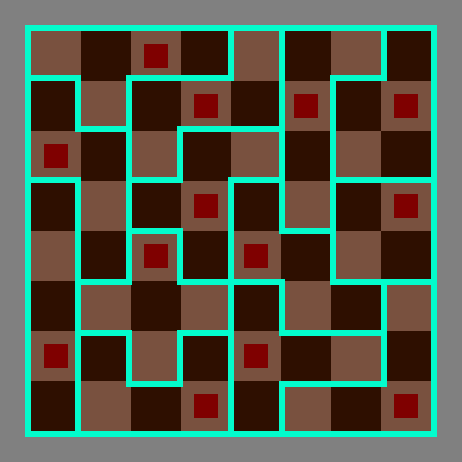


Solution #253


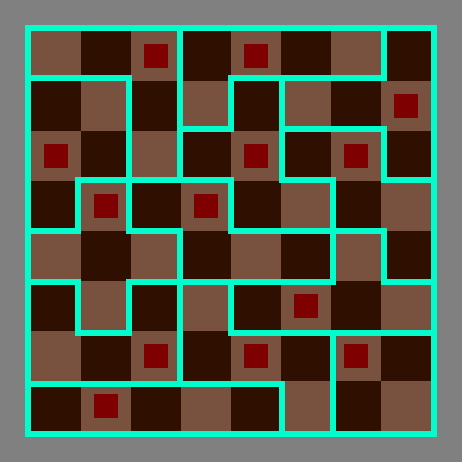


Solution #254


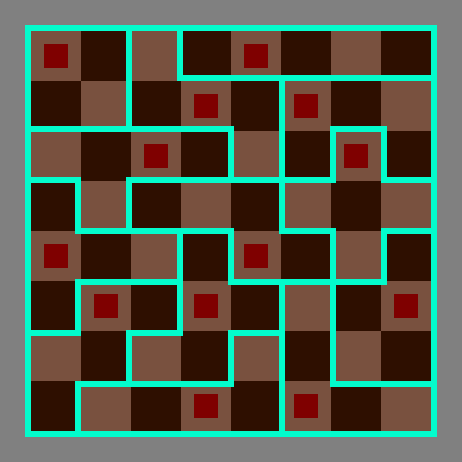


Solution #255


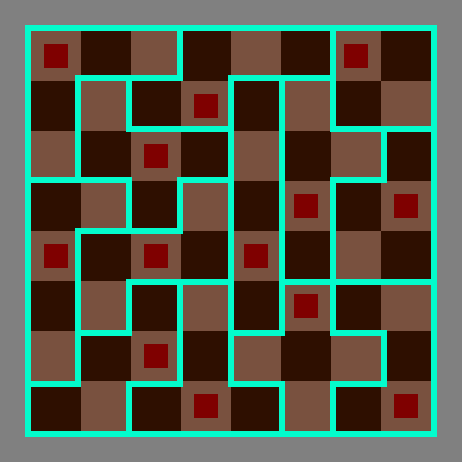


Solution #256


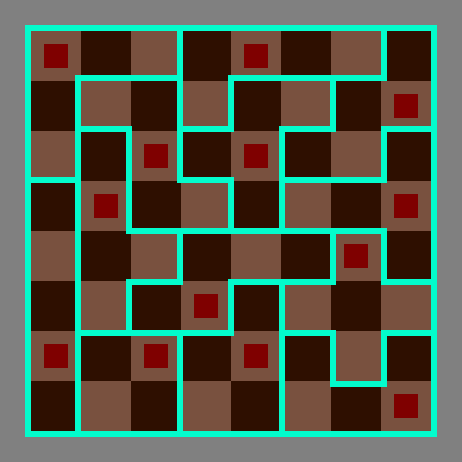


Solution #257


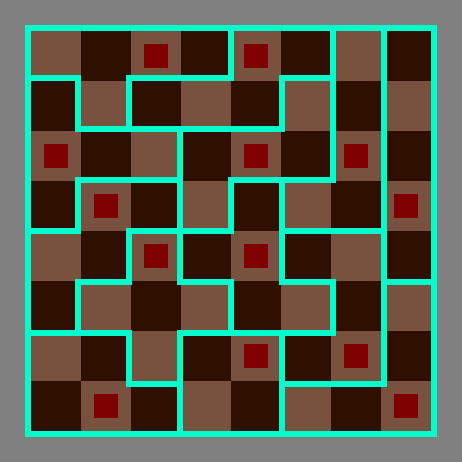


Solution #258


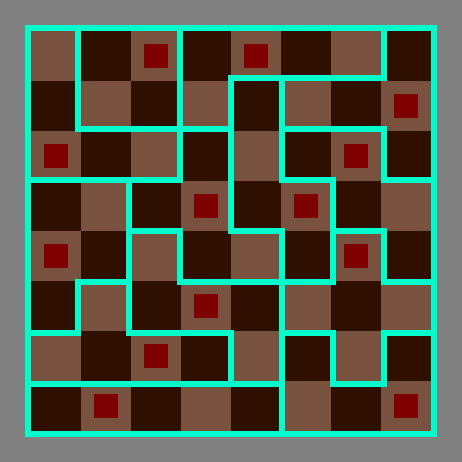


Solution #259


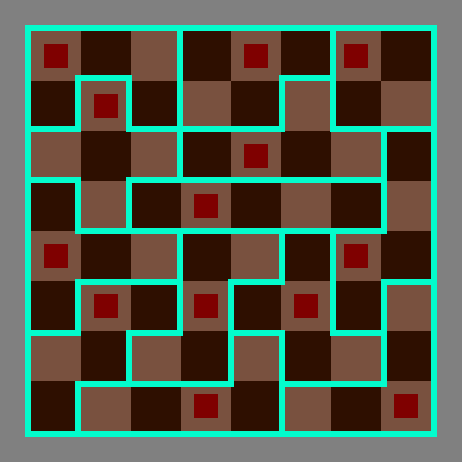


Solution #260


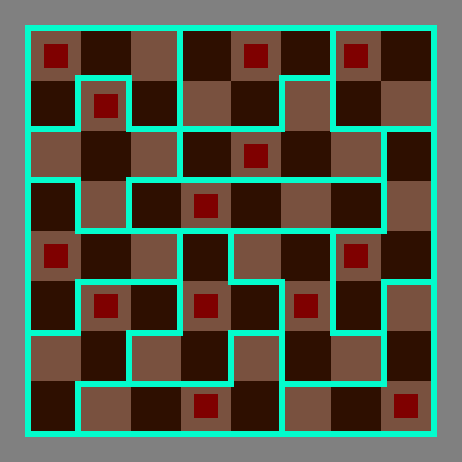


Solution #261


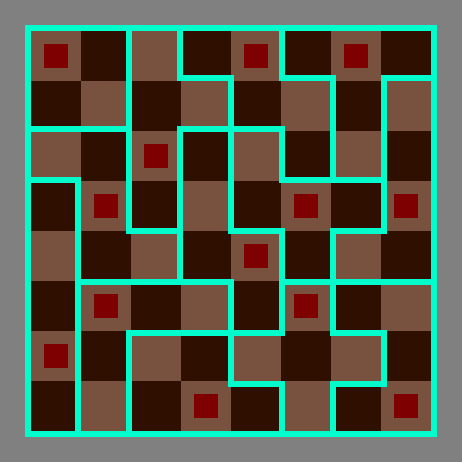


Solution #262


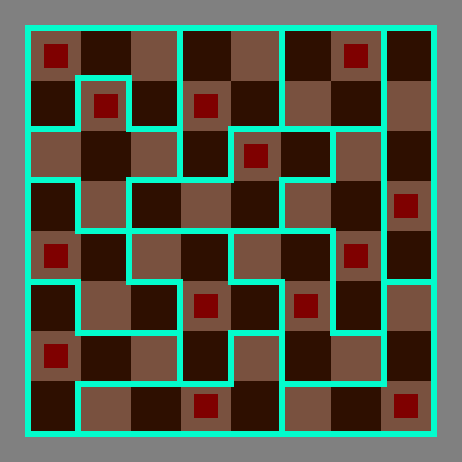


Solution #263


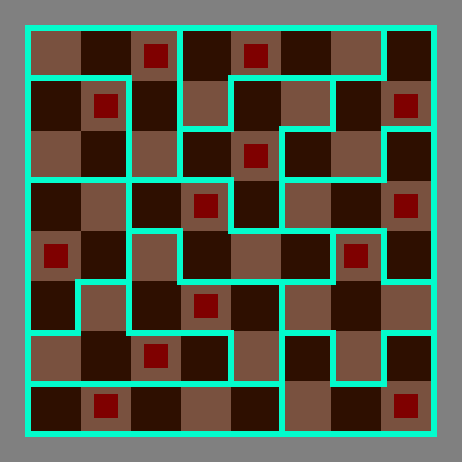


Solution #264


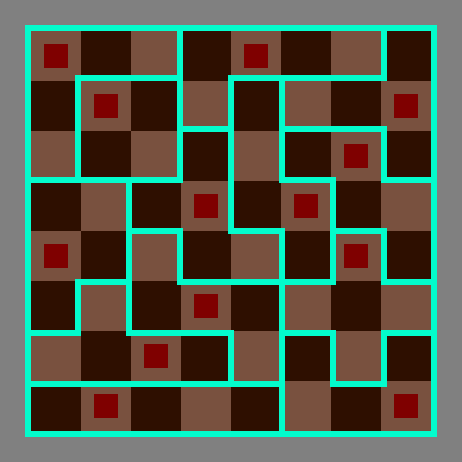


Solution #265


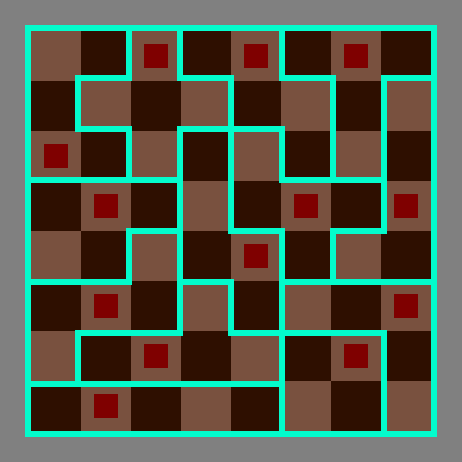


Solution #266


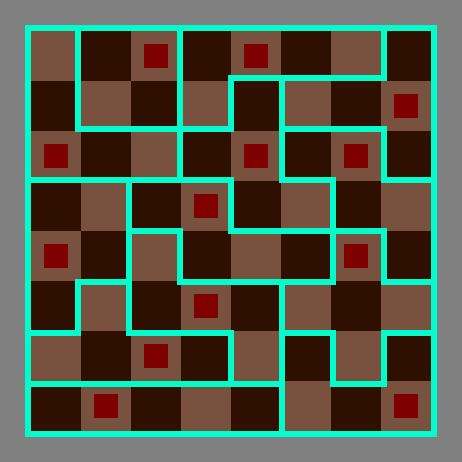


Solution #267


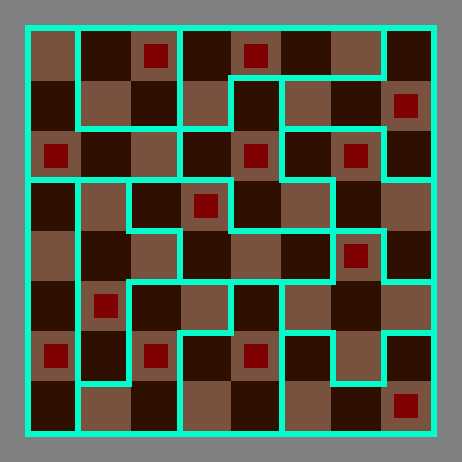


Solution #268


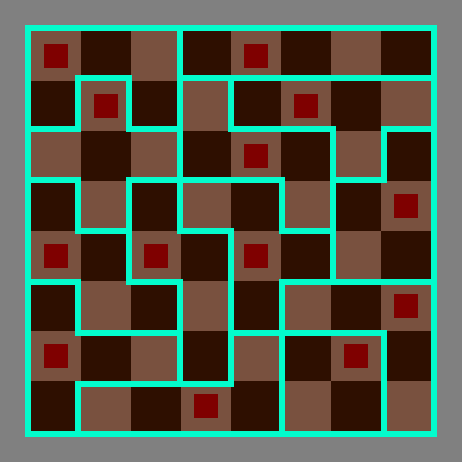


Solution #269


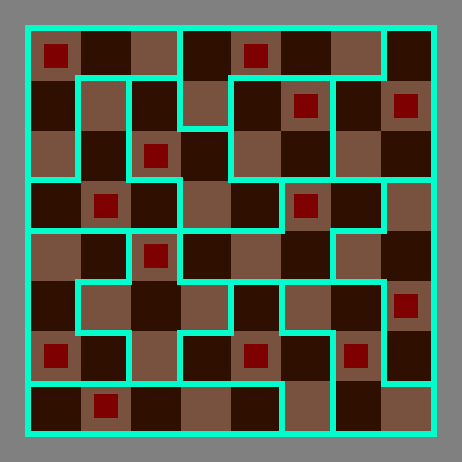


Solution #270


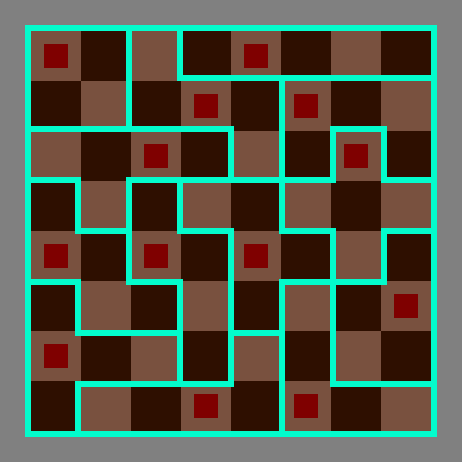


Solution #271


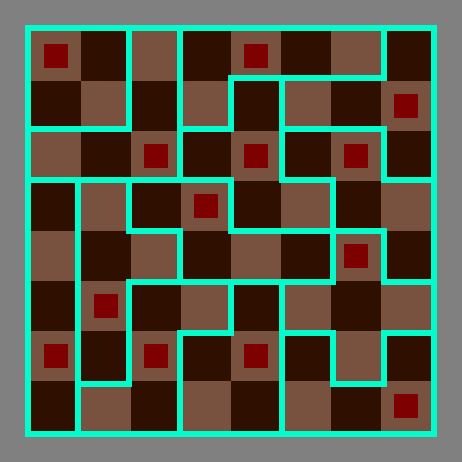


Solution #272


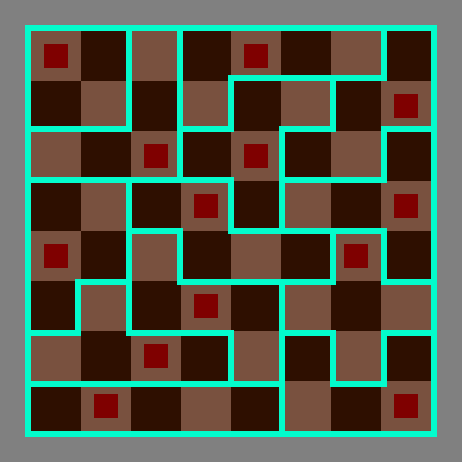


Solution #273


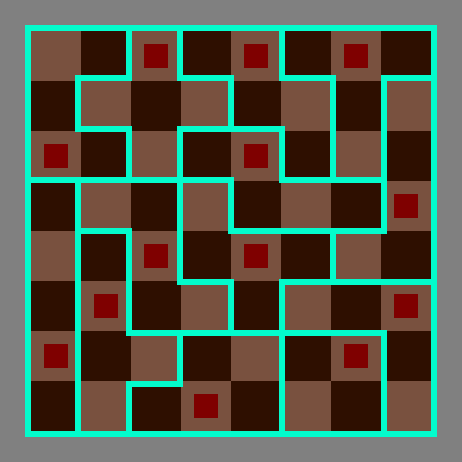


Solution #274


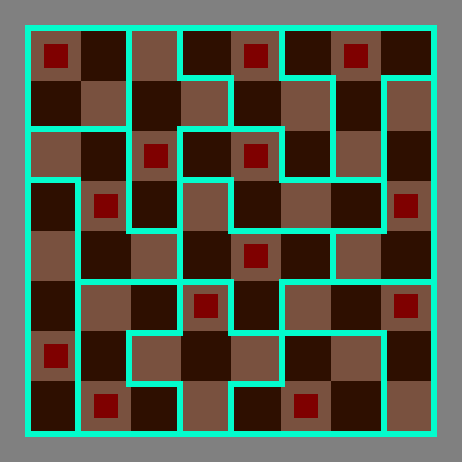


Solution #275


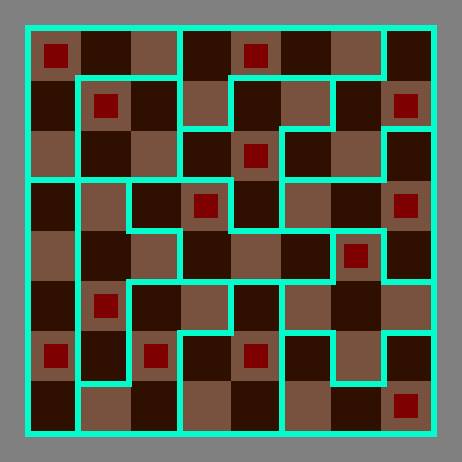


Solution #276


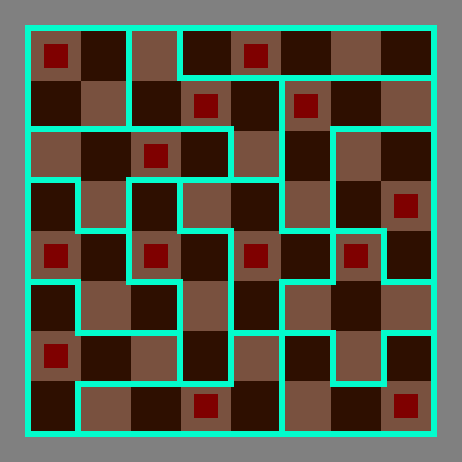


Solution #277


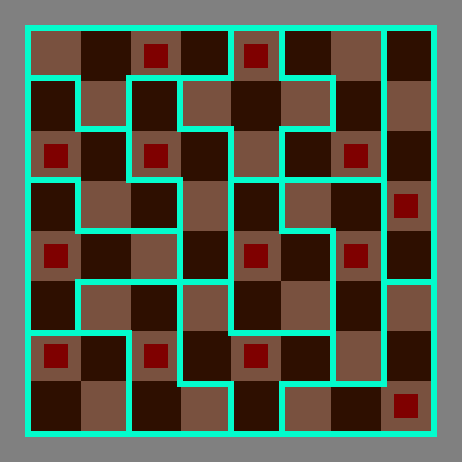


Solution #278


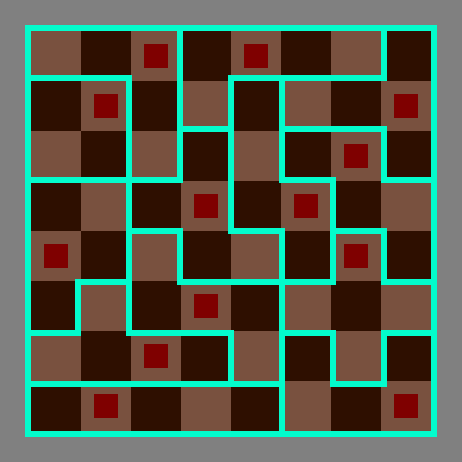


Solution #279


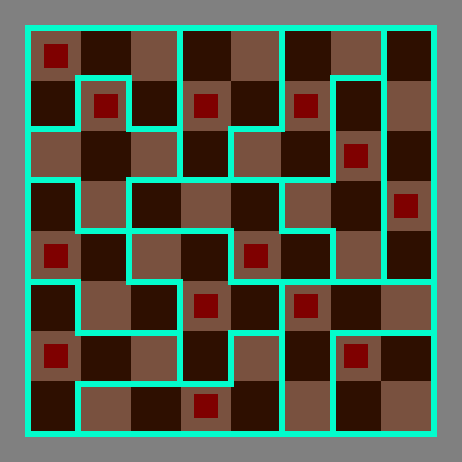


Solution #280


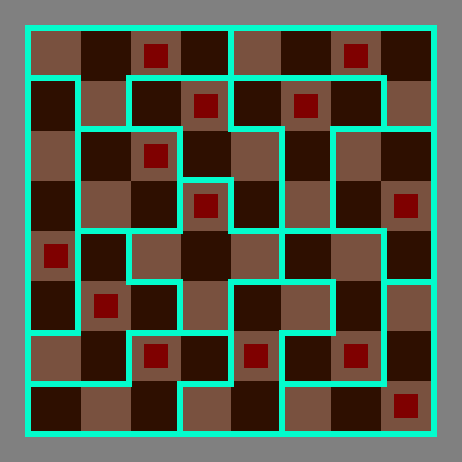


Solution #281


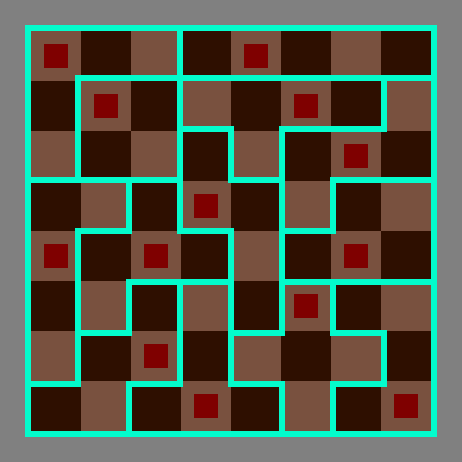


Solution #282


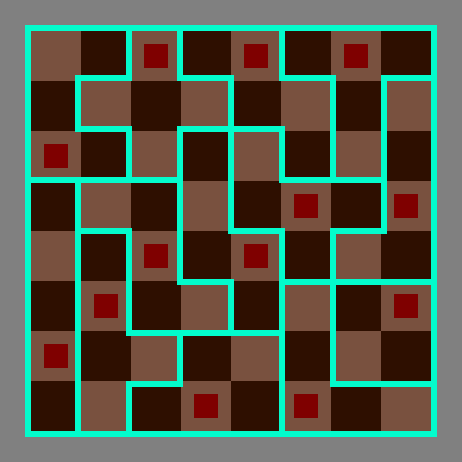


Solution #283


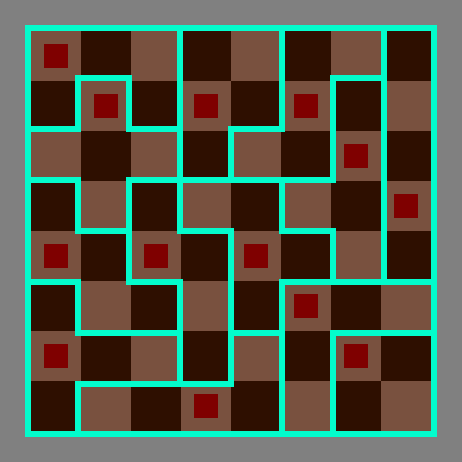


Solution #284


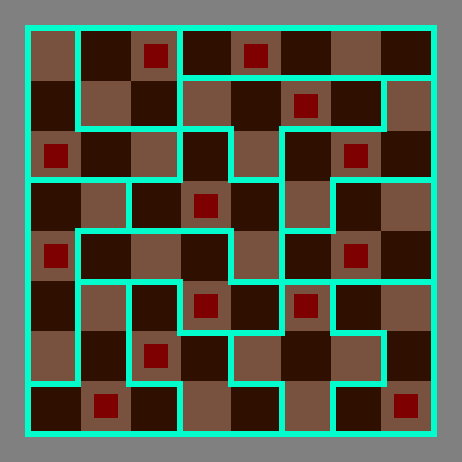


Solution #285


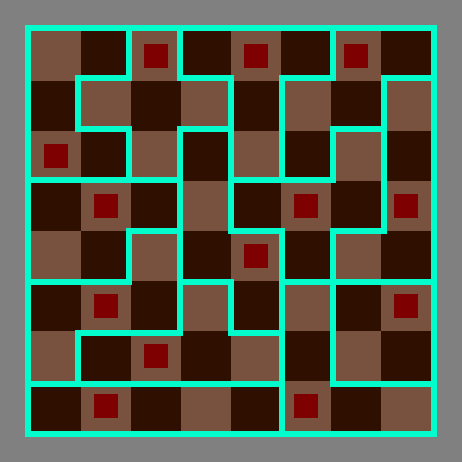


Solution #286


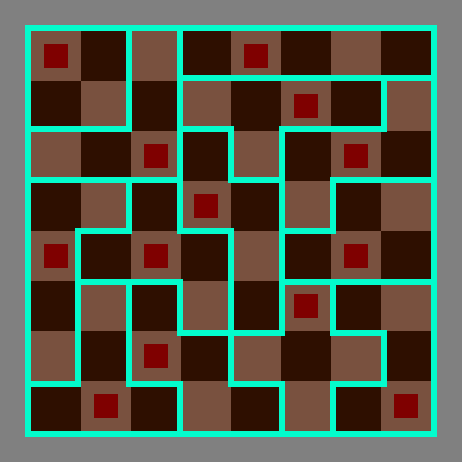


Solution #287


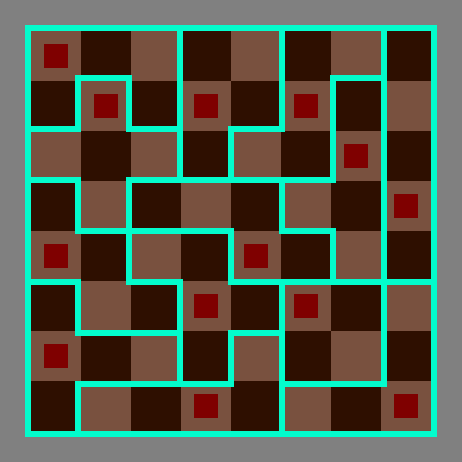


Solution #288


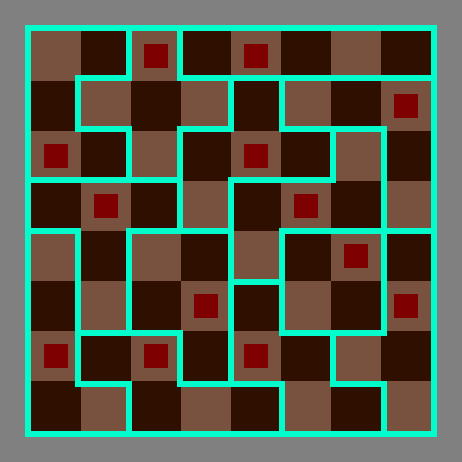


Solution #289


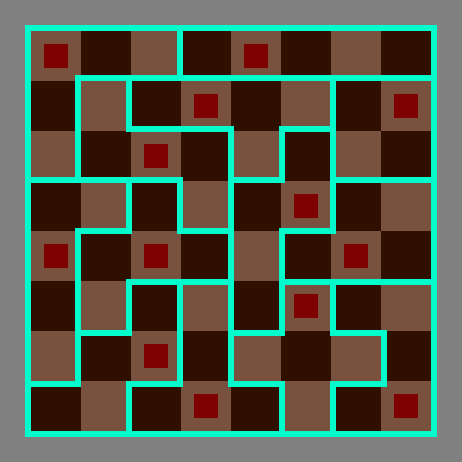


Solution #290


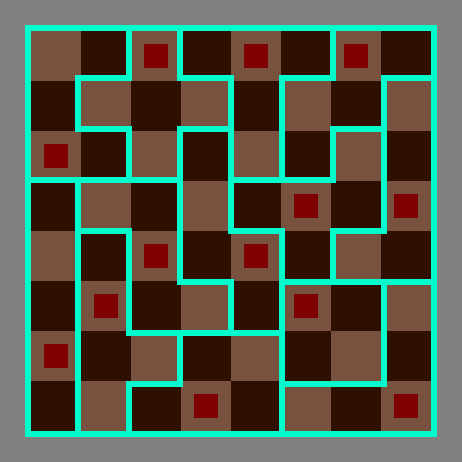


Solution #291


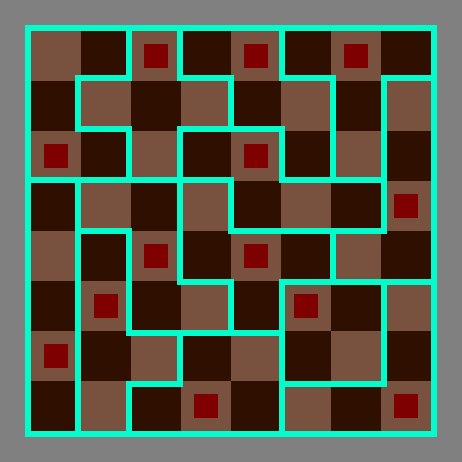


Solution #292


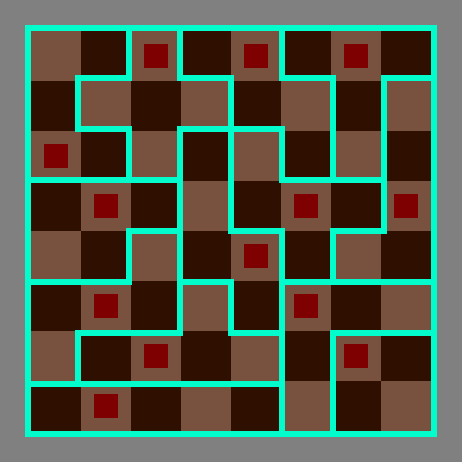


Solution #293


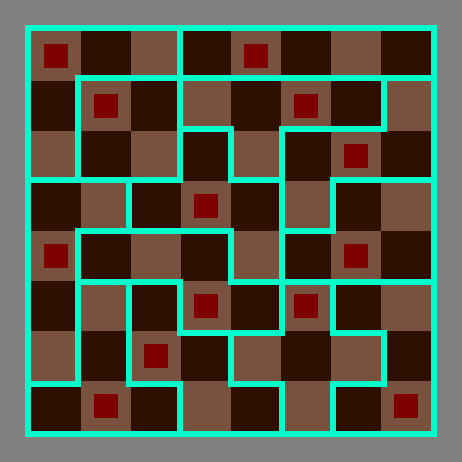


Solution #294


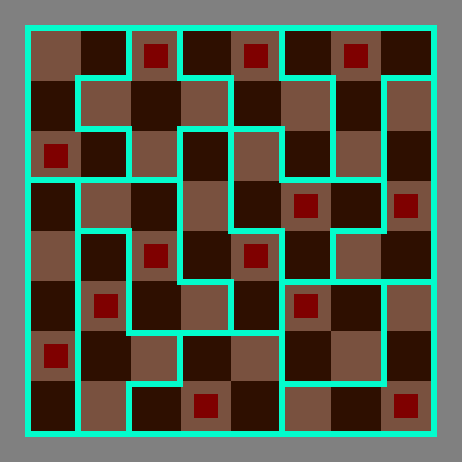


Solution #295


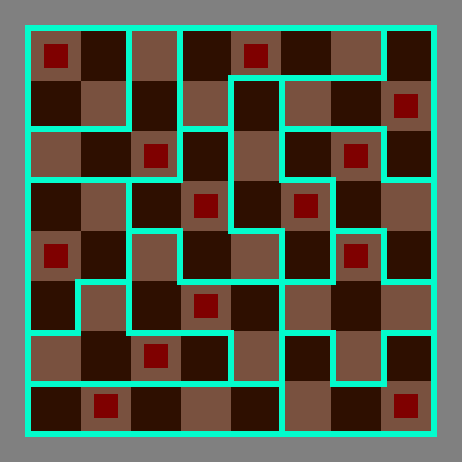


Solution #296


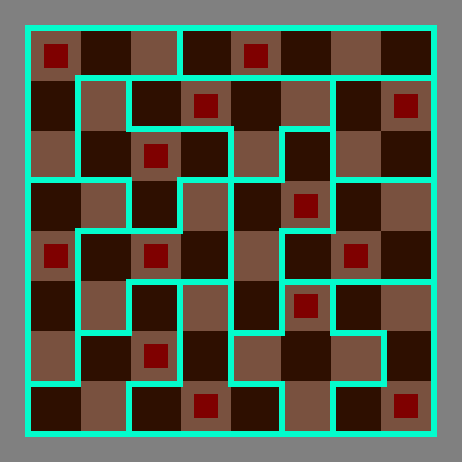


Solution #297


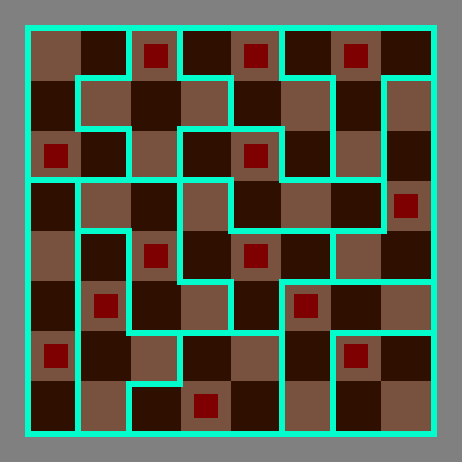


Solution #298


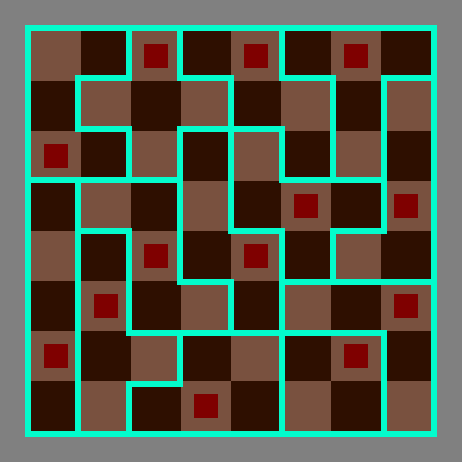


Solution #299


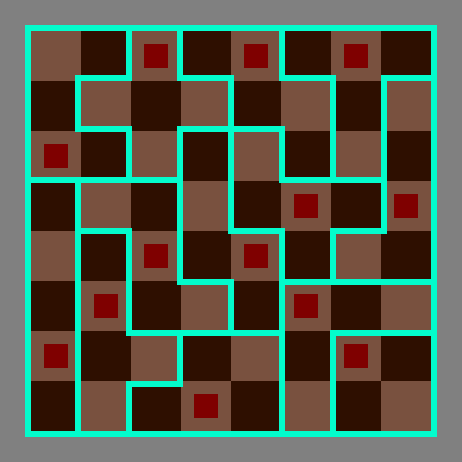


Solution #300


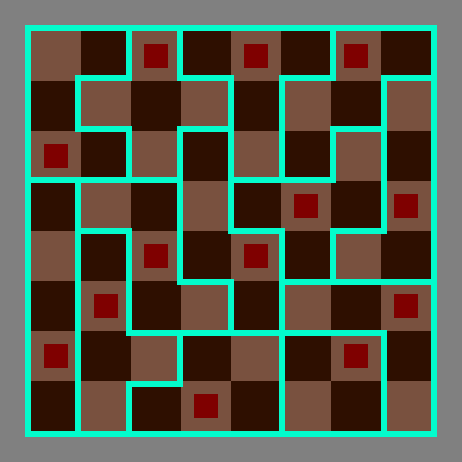


Solution #301


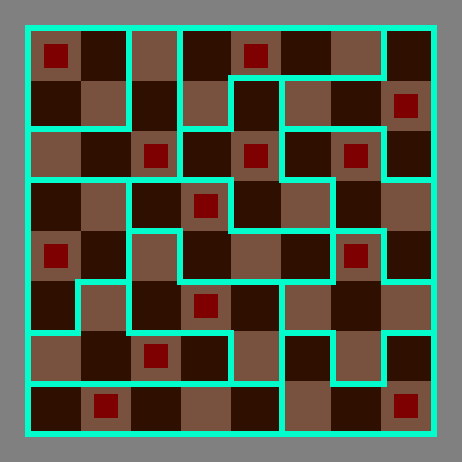


Solution #302


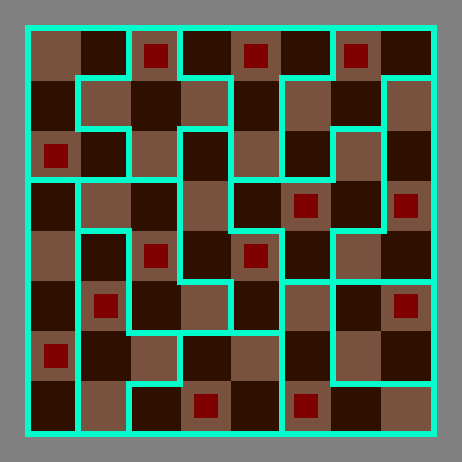


Solution #303


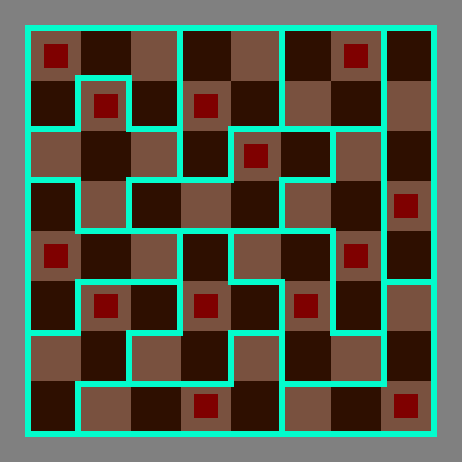


Solution #304


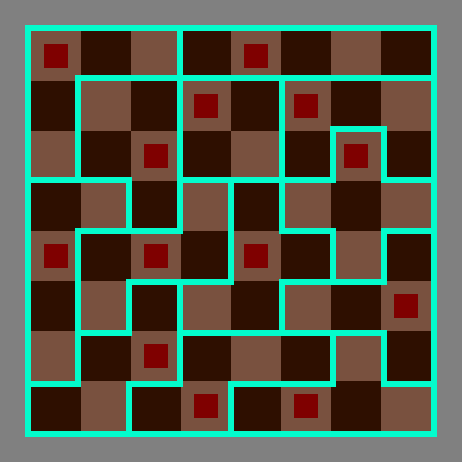


Solution #305


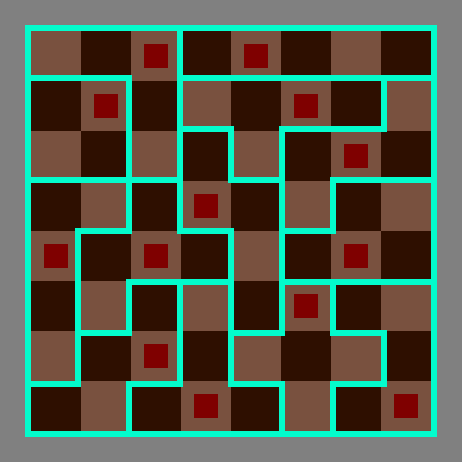


Solution #306


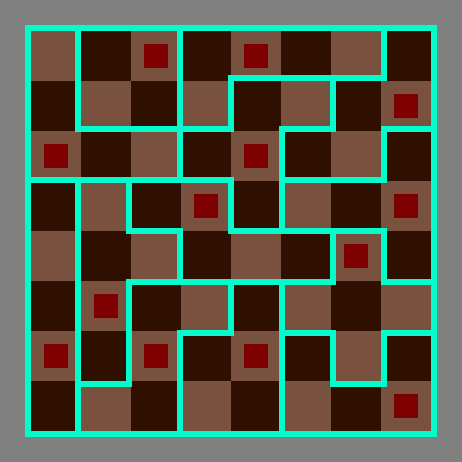


Solution #307


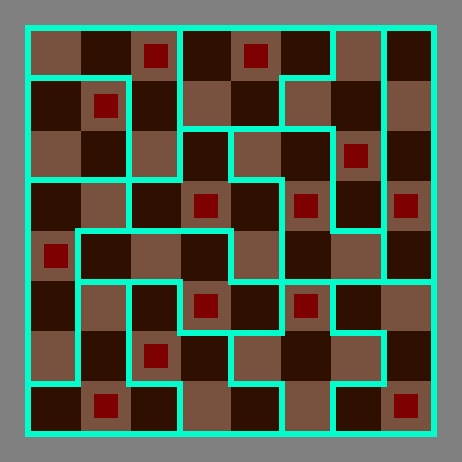


Solution #308


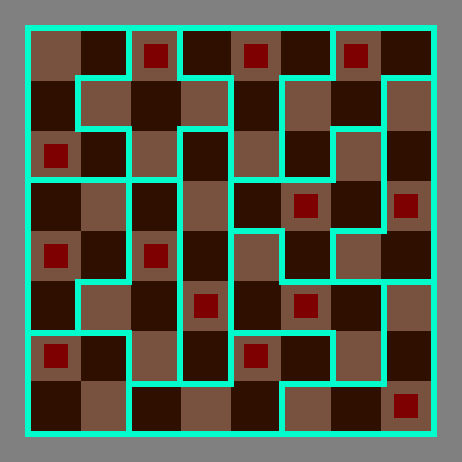


Solution #309


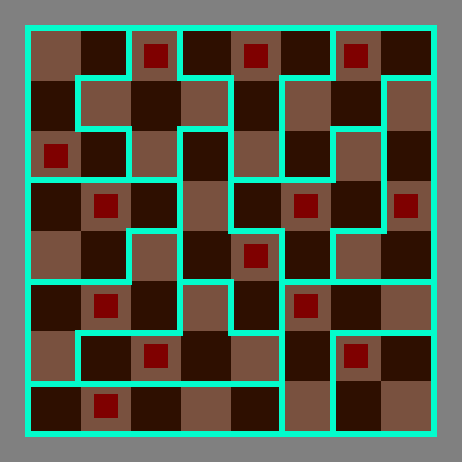


Solution #310


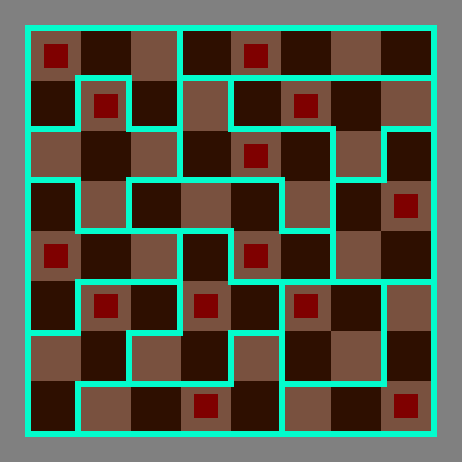


Solution #311


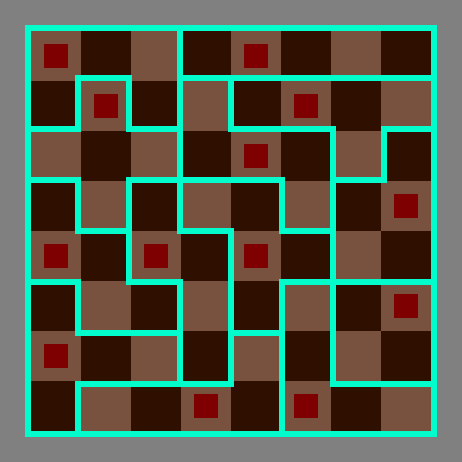


Solution #312


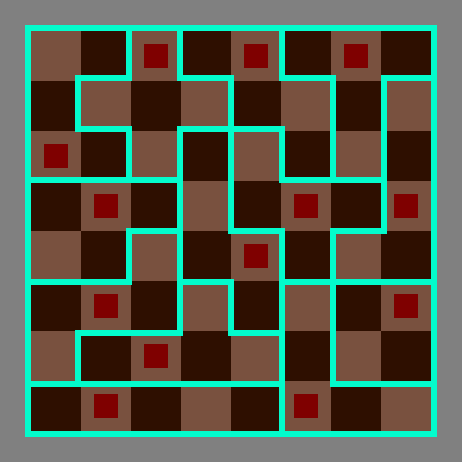


Solution #313


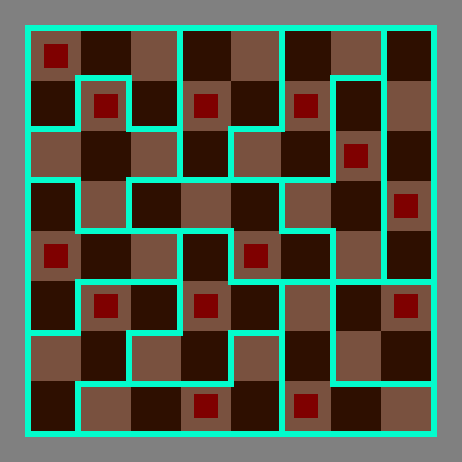


Solution #314


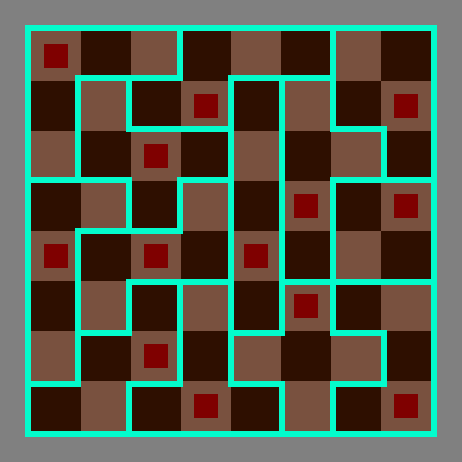


Solution #315


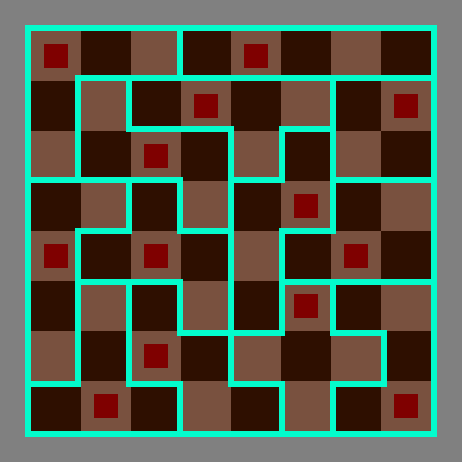


Solution #316


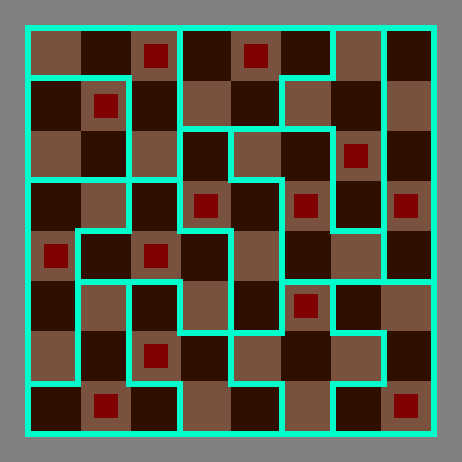


Solution #317


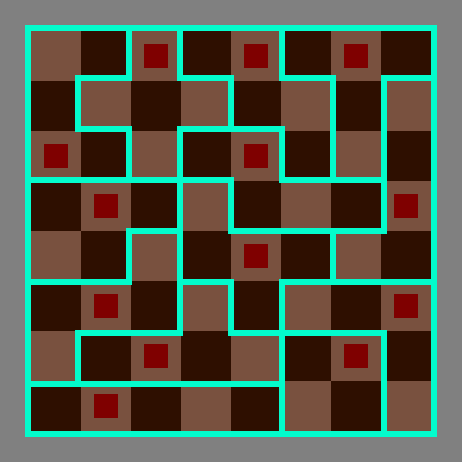


Solution #318


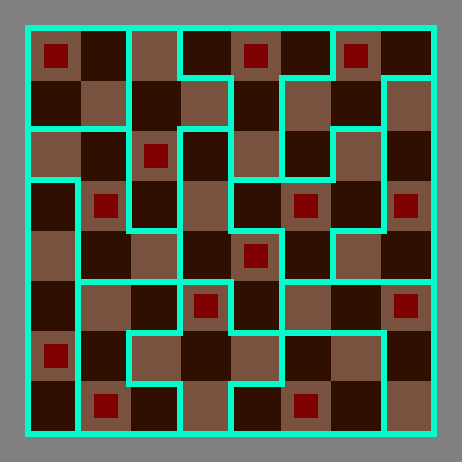


Solution #319


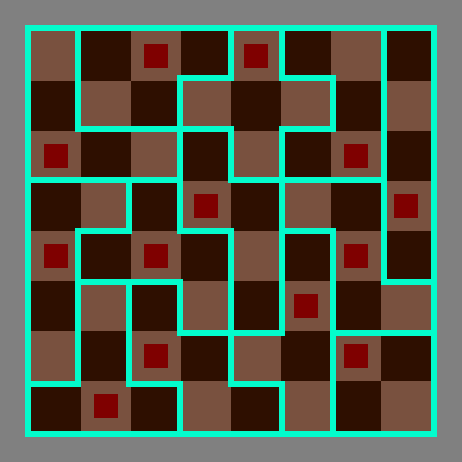


Solution #320


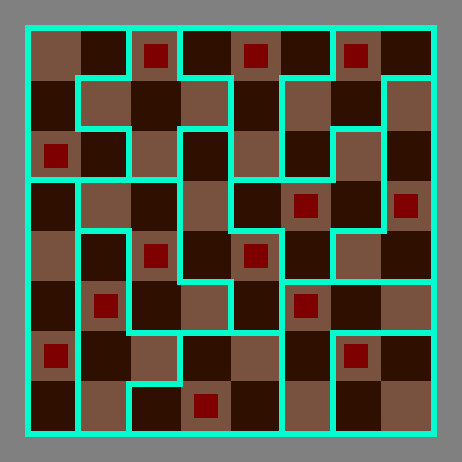


Solution #321


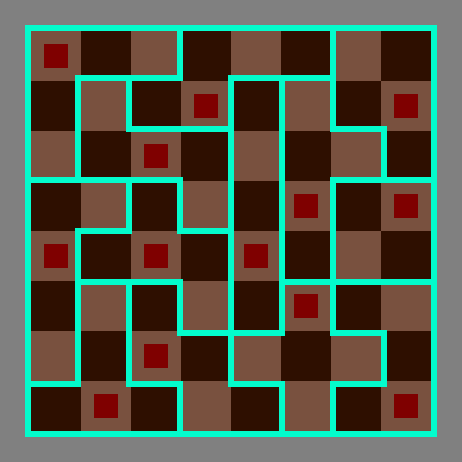


Solution #322


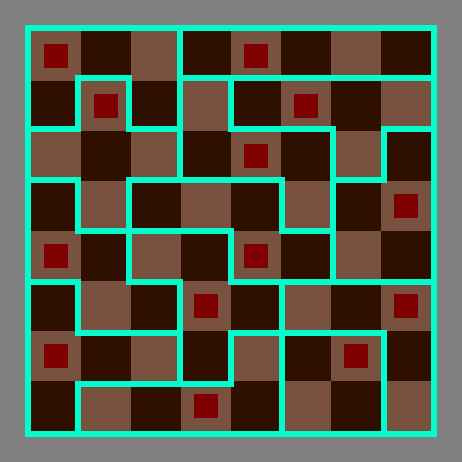


Solution #323


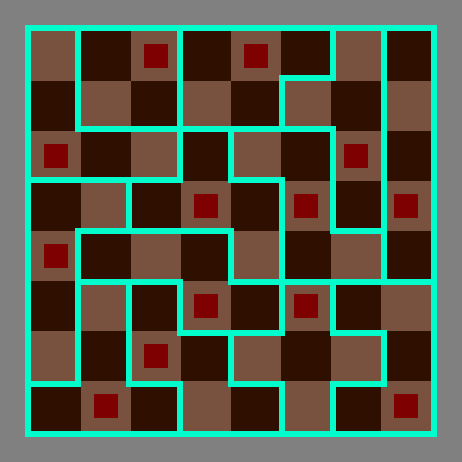


Solution #324


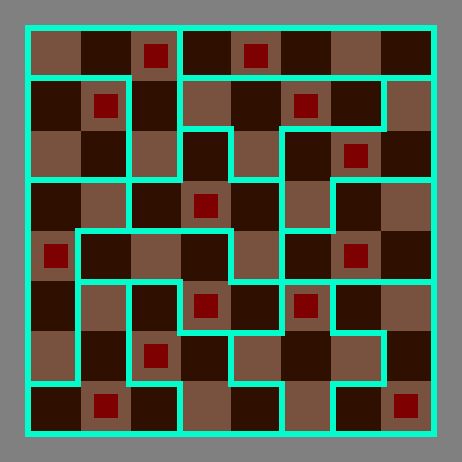


Solution #325


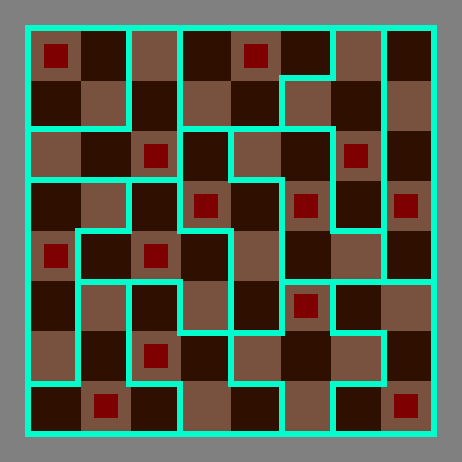


Solution #326


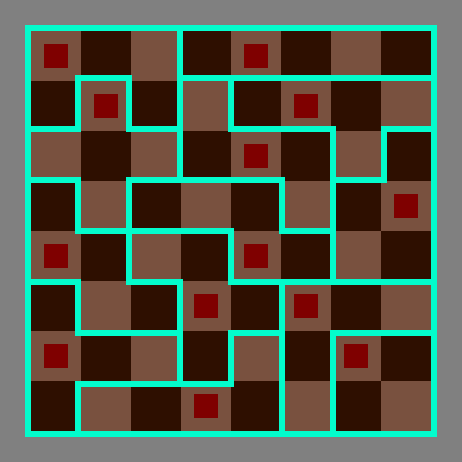


Solution #327


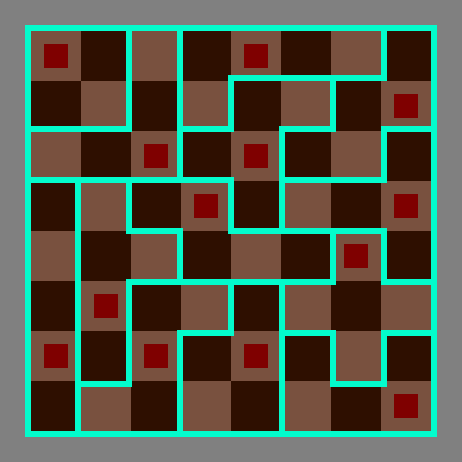


Solution #328


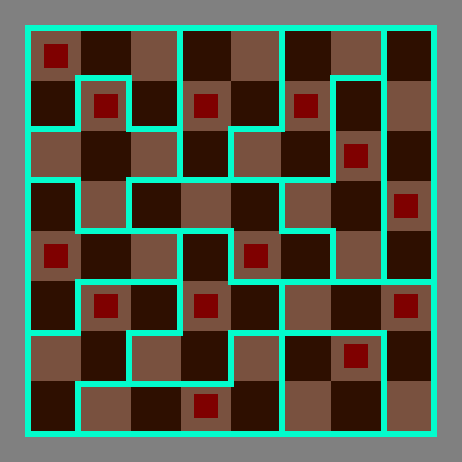


Solution #329


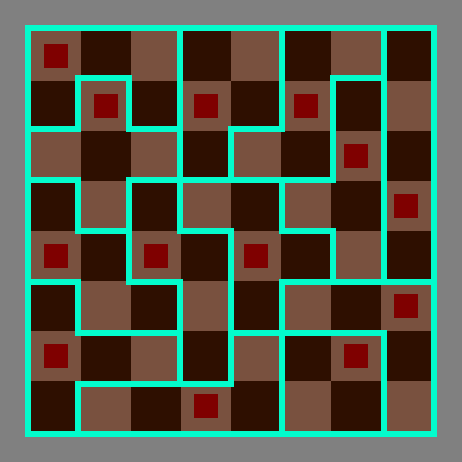


Solution #330


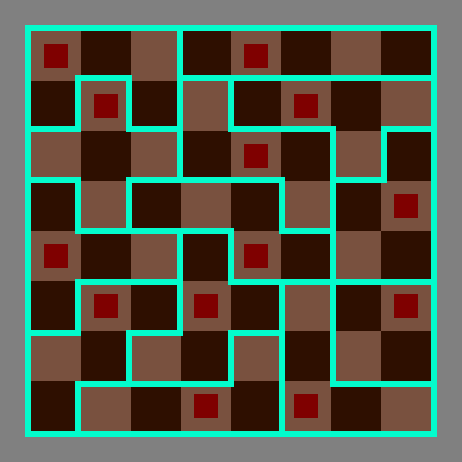


Solution #331


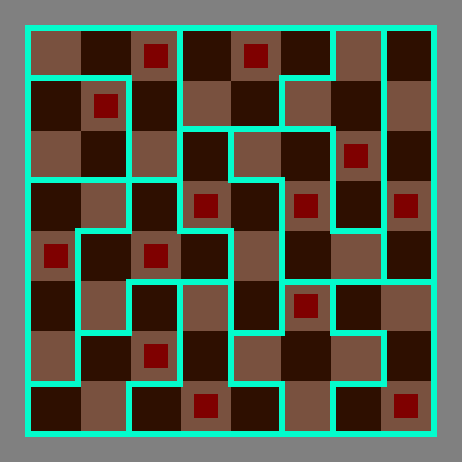


Solution #332


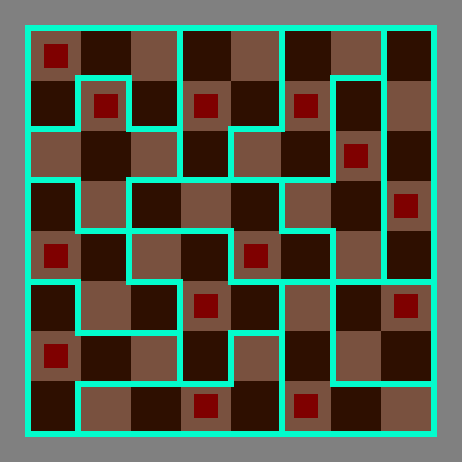


Solution #333


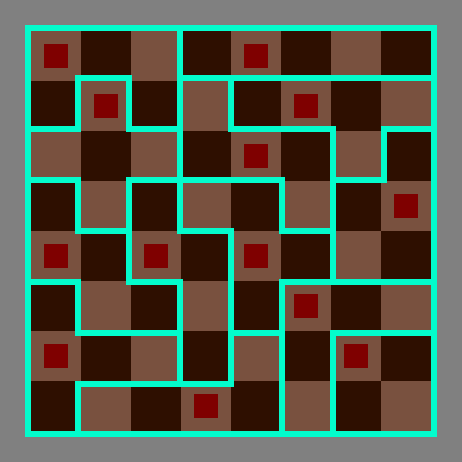


Solution #334


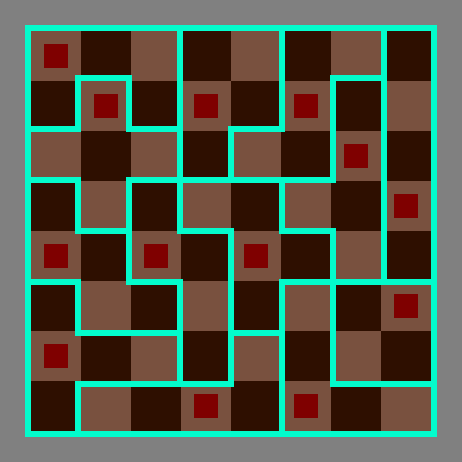


Solution #335


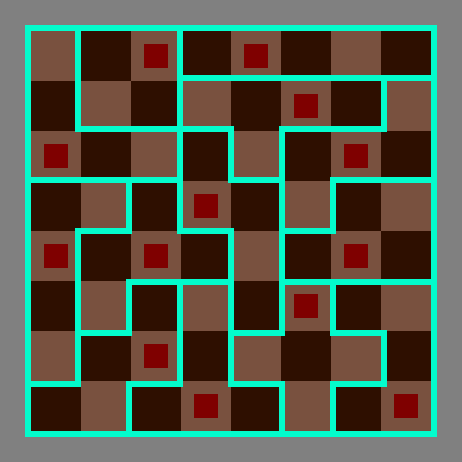


Solution #336


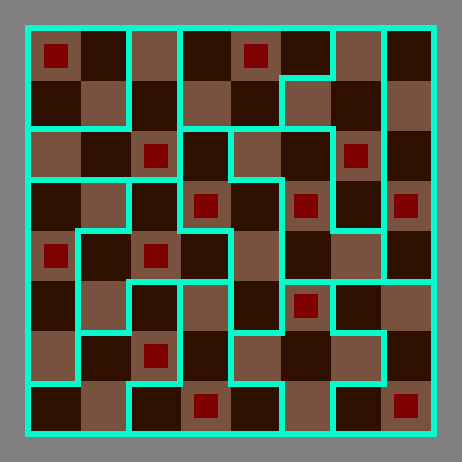


Solution #337


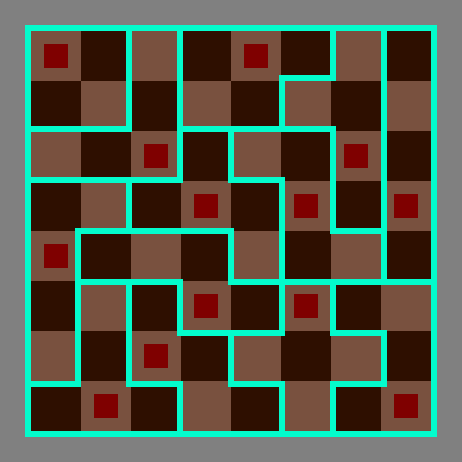


Solution #338


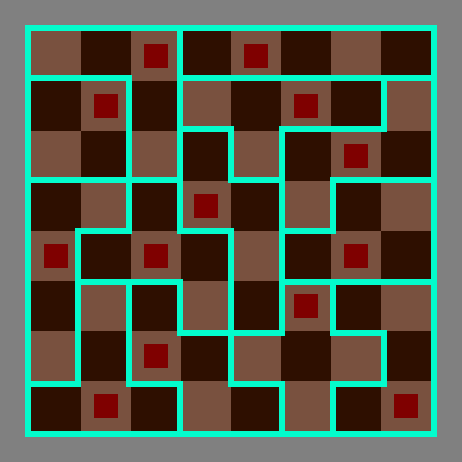


Solution #339


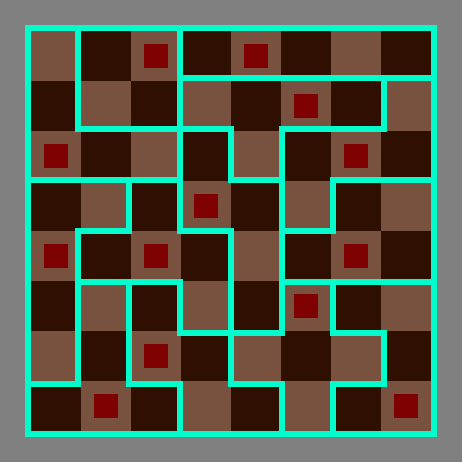


Solution #340


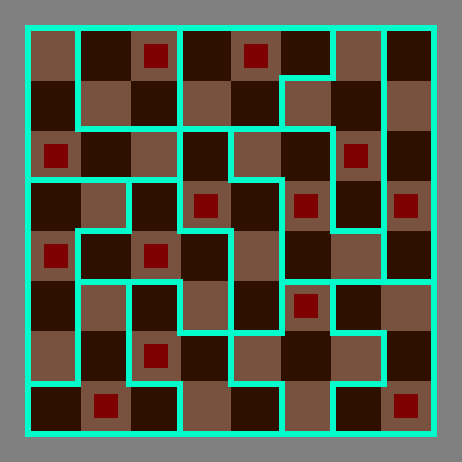

MIPSolverException: Gurobi: The problem is infeasible

In [30]:
solutions = []
while True:
    s.solve()
    
    sol_i = [i for i,b in s.get_values(bgens).items() if b]
    sol_pieces = [pos_vars[i] for i in sol_i]
    sol_board = Board.empty()
    for p, loc in sol_pieces:
        sol_board = sol_board.place_piece(p, loc)
    solutions.append(sol_board)

    solidx = len(solutions)
    board_plot = sol_board.plot_board()
    board_plot.save(f"solutions_ctf/solution_{format(solidx, '04d')}.png")
    print(f"Solution #{solidx}", flush=True)
    display(board_plot)
    print("", flush=True)
    
    s.add_constraint(sum(bgens[i] for i in sol_i) <= len(sol_i) - 1)

In [52]:
def get_hex_solution(sol):
    ps = sol.pieces
    ps = [(oriented_pieces[i].index(o), a,b) for i,(o,(a,b)) in enumerate(ps)]
    ps = [a for b in ps for a in b]
    return bytes(ps).hex()

In [81]:
from hashlib import sha256
solhex = sorted([*map(get_hex_solution, solutions)])
print(f"grey{{{sha256(b''.join(bytes.fromhex(s) for s in solhex)).hexdigest()}}}")

grey{ffd26ed19381530cd0484ec1d32e0188d8801208a942a966043bb492b23c6f92}


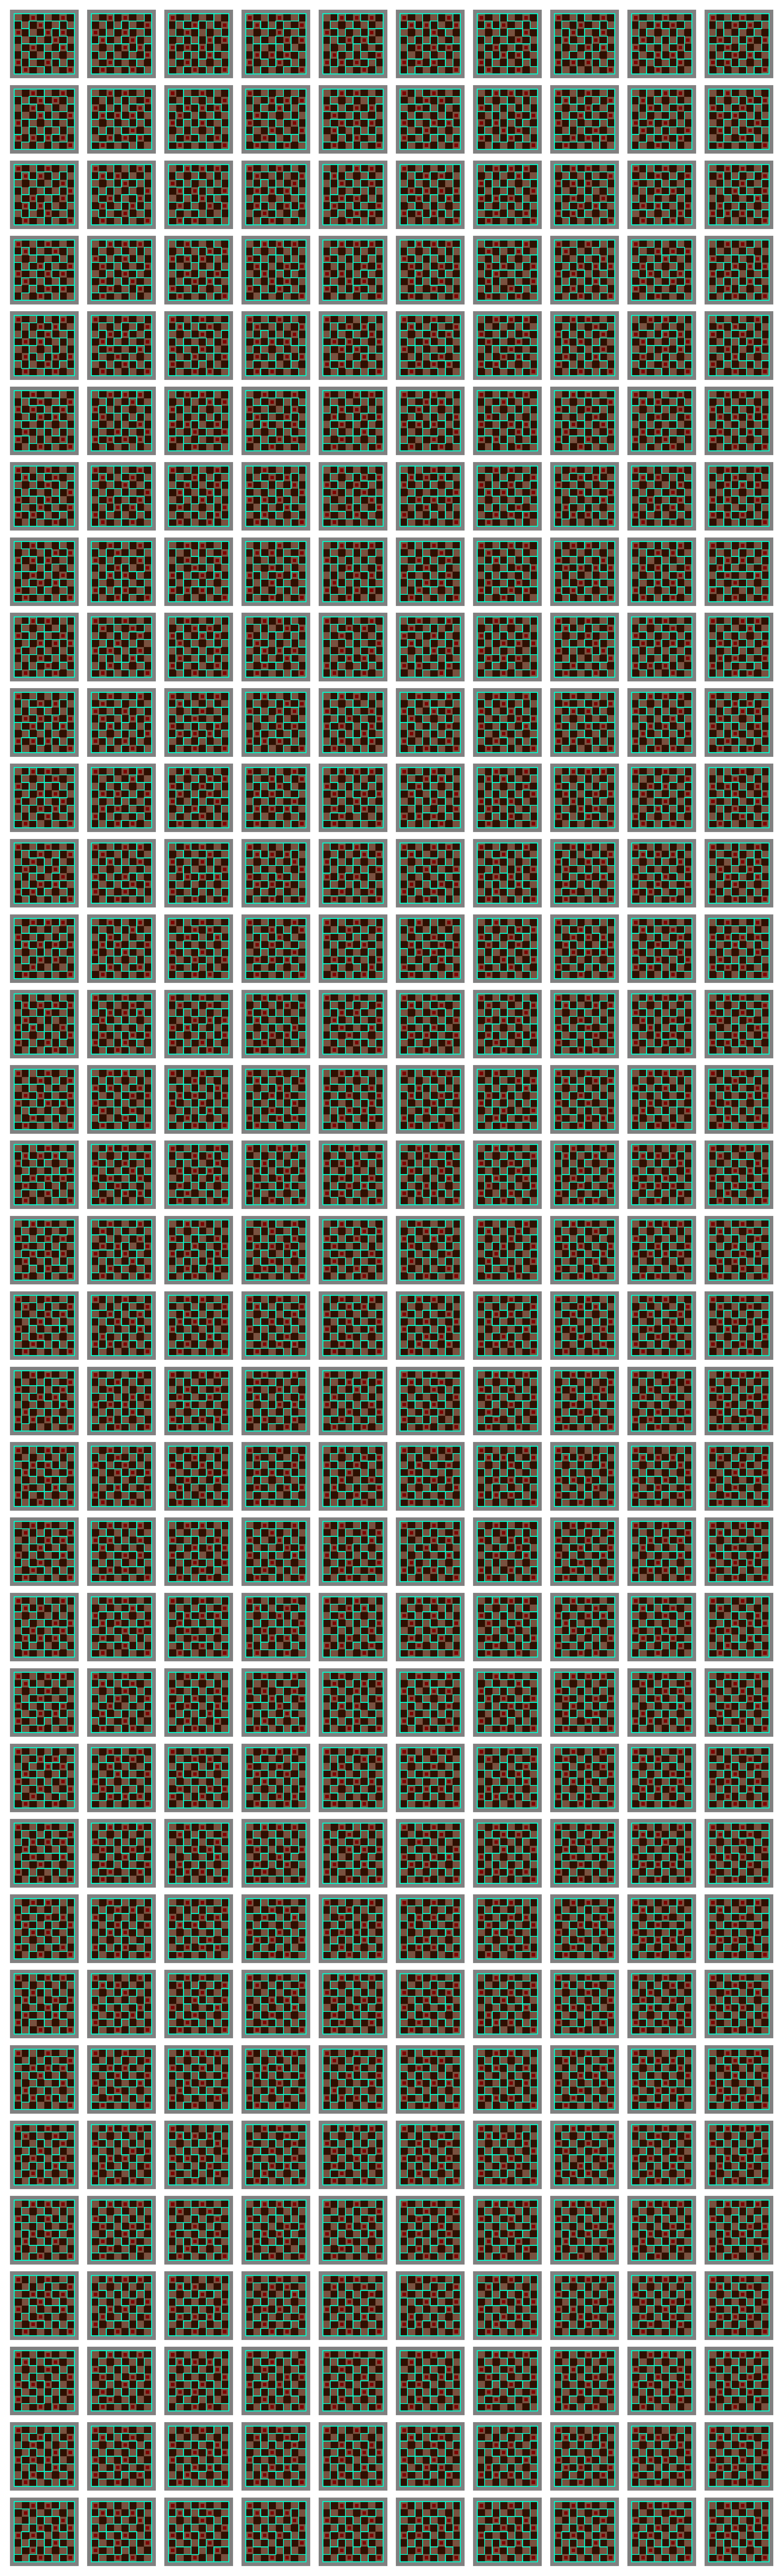

In [84]:
f, axarr = plt.subplots(34,10, figsize=(10,34))
f.set_dpi(400)
[a.axis("off") for axs in axarr for a in axs]
[a.set_xticklabels([]) for axs in axarr for a in axs]
[a.set_yticklabels([]) for axs in axarr for a in axs]

plt.subplots_adjust(wspace=0, hspace=0.1)
for sol,ax in zip(solutions, np.ravel(axarr)):
    ax.imshow(np.array(sol.plot_board()), interpolation='nearest')